## <center> <font color='purple'> Static Ensemble Machine Learning Models (Classification Task)</font></center> 
#### <center>Firuz Juraev (Sungkyunkwan Unniversity)</center>

In [1]:
import pandas as pd
import numpy as np 
from numpy import mean
from numpy import std
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

In [3]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score, 
                             f1_score,
                             roc_auc_score, 
                             precision_recall_curve,
                             balanced_accuracy_score,
                             auc)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

#### <font color='blue'>Libraries for Critical Diagram 

In [8]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks
from sklearn.metrics import mean_absolute_error

### <font color='purple'>Variables 

In [9]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'DEAD' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = None #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = [] #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

### <font color='purple'>Loading dataset 

In [10]:
train_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_train_data_4.csv")
test_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_test_data_4.csv")

X_train = train_dataset_upsampled.drop(["DEAD"], axis=1) 
y_train = train_dataset_upsampled["DEAD"]

X_test = test_dataset_upsampled.drop(["DEAD"], axis=1) 
y_test = test_dataset_upsampled["DEAD"]

In [11]:
columns = X_train.columns.to_list()

### <font color='purple'>Data Normalization 

In [12]:
Min_max_scaler = MinMaxScaler().fit(X_train)

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled, columns = columns)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled, columns = columns)

### <font color='purple'>Feature Selection 

In [13]:
tain_mm_scaled_df = df_train_mm_scaled[:]
tain_mm_scaled_df["DEAD"] = y_train 

test_mm_scaled_df = df_test_mm_scaled[:] 
test_mm_scaled_df["DEAD"] = y_test


importances = mutual_info_classif(df_train_mm_scaled, y_train)
feat_importance = pd.Series(importances, tain_mm_scaled_df.columns[0:len(tain_mm_scaled_df.columns)-1])
    
feat_importance = feat_importance.sort_values(ascending=False)
    
selected_features = feat_importance[:30]
selected_features_list_mm_scaled = selected_features.index.to_list()


tain_mm_scaled_df[selected_features_list_mm_scaled].head(2)

,temperature_mean,respRate_std,respRate_var,skinTemperature_std,skinTemperature_var,heartRate_std,heartRate_var,sao2_var,sao2_std,bpCuffMean_var,...,BIRTH_WEIGHT,bpCuffDiastolic_mean,bpCuffSystolic_mean,temperature_var,sao2_mean,temperature_std,glucometer_mean,bpCuffMean_mean,PLATELET,D10W_MEAN
0,0.775318,0.422245,0.178291,0.134078,0.017977,0.22911,0.057937,0.009568,0.097817,0.053294,...,0.264267,0.457143,0.602649,0.015695,0.881455,0.125281,0.312593,0.310696,0.281330,0.151138
1,0.709668,0.583964,0.341014,0.086672,0.007512,0.28258,0.086102,0.006551,0.080938,0.020317,...,0.437819,0.479330,0.644907,0.003770,0.926056,0.061399,0.272551,0.351928,0.392157,0.196784


In [14]:
X_train_mm = df_train_mm_scaled[selected_features_list_mm_scaled][:]
X_test_mm = df_test_mm_scaled[selected_features_list_mm_scaled][:]

### <font color='purple'>k-fold Cross Validation partitioning 

In [15]:
def cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed):
    #Partitioning-----------------------------------------------------------------------------------------
    #Shuffle instances to avoid potential biases
    td = td.sample(frac=1, random_state = randomSeed).reset_index(drop=True)
                
    #Temporarily convert data frame to list of lists (save header for later)
    header = list(td.columns.values)
    datasetList = list(list(x) for x in zip(*(td[x].values.tolist() for x in td.columns)))

    #Handle Special Variables for Nominal Outcomes
    outcomeIndex = None
    classList = None
    if categoricalOutcome:
        outcomeIndex = td.columns.get_loc(outcomeLabel)
        classList = []
        for each in datasetList:
            if each[outcomeIndex] not in classList:
                classList.append(each[outcomeIndex])
                
    #Initialize partitions
    partList = [] #Will store partitions
    for x in range(cv_partitions):
        partList.append([])
    
    #Stratified Partitioning Method-----------------------
    if partition_method == 'S':
        if categoricalOutcome: #Discrete outcome
            print("Nominal Stratitifed Partitioning")
            
            #Create data sublists, each having all rows with the same class
            byClassRows = [ [] for i in range(len(classList)) ] #create list of empty lists (one for each class)
            for row in datasetList:
                #find index in classList corresponding to the class of the current row. 
                cIndex = classList.index(row[outcomeIndex])
                byClassRows[cIndex].append(row)

            for classSet in byClassRows:
                currPart = 0
                counter = 0
                for row in classSet:
                    partList[currPart].append(row)
                    counter += 1
                    currPart = counter%cv_partitions
    
        else: # Do stratified partitioning for continuous endpoint data
            print("Error: Stratified partitioning only designed for discrete endpoints. ")    
                
    else:
        print('Error: Requested partition method not found.')
        
        
   #Generation of CV datasets from partitions---------------------------------------------------------------------------
    train_dfs = []

    for part in range(0, cv_partitions):      
        trainList=[]
        tempList = []                 
        for x in range(0,cv_partitions): 
            tempList.append(x)                            
        tempList.pop(part)

        for v in tempList: #for each training partition
            trainList.extend(partList[v])   
        
        train_dfs.append(pd.DataFrame(trainList, columns = header))
            
    return train_dfs #train_dfs, test_dfs 

In [16]:
train_data = X_train_mm[:]
train_data["DEAD"] = y_train

test_data = X_test_mm[:]
test_data["DEAD"] = y_test

In [17]:
test_dfs = cv_partitioner(test_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)
train_dfs = cv_partitioner(train_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)

Nominal Stratitifed Partitioning
Nominal Stratitifed Partitioning


### <font color='purple'>Model Training 

In [18]:
def get_result_part(train, test, classifier):
    X_train = train.drop(["DEAD"], axis=1) 
    y_train = train["DEAD"] 
    X_test = test.drop(["DEAD"], axis=1) 
    y_test = test["DEAD"]

    classifier.fit(X_train, y_train)
    y_preds = classifier.predict(X_test) 

    acc = accuracy_score(y_test, y_preds)
    balanced_acc = balanced_accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)

    yproba = classifier.predict_proba(X_test)[::,1] 

    fpr, tpr, thresholds = metrics.roc_curve(y_test, yproba)  
    roc_auc = auc(fpr, tpr) 

    results = {'accuracy': acc, 
                'balanced_accuracy': balanced_acc, 
                'precision': precision, 
                'recall': recall, 'f1': f1, 
                'fpr': fpr, 'tpr': tpr, 
                'auc': roc_auc}

    return results

In [19]:
def get_results(train_list, test_data, classifiers): 
    k_folds = 10 
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc']) 
    results_set = pd.DataFrame() 
    full_result = pd.DataFrame() 
    
    for cls in classifiers:   
        accuracy_list = []
        balanced_accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        fpr_list = [] 
        tpr_list = [] 
        auc_list = [] 
        
        for i in range(0, k_folds):
            result = get_result_part(train_list[i], test_data, cls)
            accuracy_list.append(result['accuracy']) 
            balanced_accuracy_list.append(result['balanced_accuracy'])
            precision_list.append(result['precision']) 
            recall_list.append(result['recall']) 
            f1_list.append(result['f1']) 
            fpr_list.append(result['fpr']) 
            tpr_list.append(result['tpr']) 
            auc_list.append(result['auc']) 
        
        result_table = result_table.append({'classifiers': cls.__class__.__name__,
                                        'fpr': fpr_list, 
                                        'tpr': tpr_list, 
                                        'auc': auc_list}, ignore_index=True)
        
        results_set = results_set.append({'classifiers': cls.__class__.__name__,
                                          'accuracy': round(mean(accuracy_list), 3), 
                                          'accuracy_std': round(std(accuracy_list), 3), 
                                          'precision': round(mean(precision_list), 3), 
                                          'precision_std': round(std(precision_list), 3), 
                                          'recall': round(mean(recall_list), 3), 
                                          'recall_std': round(std(recall_list), 3), 
                                          'f1': round(mean(f1_list), 3), 
                                          'f1_std': round(std(f1_list), 3), 
                                          'auc': round(mean(auc_list), 3), 
                                          'auc_std': round(std(auc_list), 3)}, ignore_index=True)
        
        full_result = full_result.append({'classifiers': cls.__class__.__name__,
                                            'accuracy': accuracy_list}, ignore_index=True) 
    
    result_table.set_index('classifiers', inplace=True)
    return result_table, results_set, full_result  

### <font color='green'> Static Ensemble ML models (+FS, +HO)

In [20]:
model_dt1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt3 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt4 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt5 = DecisionTreeClassifier(criterion='entropy', max_depth=3)

voting_classifiers = [("dt1", model_dt1),
                      ("dt2", model_dt2),
                      ("dt3", model_dt3),
                      ("dt4", model_dt4), 
                      ("dt5", model_dt5)]

classifiers = [AdaBoostClassifier(n_estimators=250, learning_rate=0.01),
               XGBClassifier(learning_rate = 0.002, n_estimators=200, max_depth=3), 
               RandomForestClassifier(criterion='gini', n_estimators=10, max_depth=2), 
               GradientBoostingClassifier(learning_rate = 0.005, n_estimators=120, max_depth=4),
               CatBoostClassifier(learning_rate=0.001, depth=3), 
               LGBMClassifier(max_depth=1, n_estimators=320, objective="binary"),
               VotingClassifier(estimators = voting_classifiers, voting='soft')
              ]

In [21]:
table, results_table, full_results = get_results(train_dfs, test_data, classifiers) # Just change to test_dfs

[15:04:53] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:53] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:53] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:54] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

199:	learn: 0.5235151	total: 496ms	remaining: 1.98s
200:	learn: 0.5229478	total: 498ms	remaining: 1.98s
201:	learn: 0.5223359	total: 500ms	remaining: 1.97s
202:	learn: 0.5217480	total: 501ms	remaining: 1.97s
203:	learn: 0.5211092	total: 503ms	remaining: 1.96s
204:	learn: 0.5201927	total: 505ms	remaining: 1.96s
205:	learn: 0.5196081	total: 507ms	remaining: 1.95s
206:	learn: 0.5190181	total: 508ms	remaining: 1.95s
207:	learn: 0.5183886	total: 510ms	remaining: 1.94s
208:	learn: 0.5177926	total: 512ms	remaining: 1.94s
209:	learn: 0.5172917	total: 513ms	remaining: 1.93s
210:	learn: 0.5163932	total: 515ms	remaining: 1.93s
211:	learn: 0.5158098	total: 517ms	remaining: 1.92s
212:	learn: 0.5151000	total: 518ms	remaining: 1.92s
213:	learn: 0.5146194	total: 520ms	remaining: 1.91s
214:	learn: 0.5137167	total: 522ms	remaining: 1.9s
215:	learn: 0.5130636	total: 523ms	remaining: 1.9s
216:	learn: 0.5124215	total: 525ms	remaining: 1.89s
217:	learn: 0.5117485	total: 527ms	remaining: 1.89s
218:	learn: 0.

399:	learn: 0.4138819	total: 842ms	remaining: 1.26s
400:	learn: 0.4134992	total: 844ms	remaining: 1.26s
401:	learn: 0.4131368	total: 845ms	remaining: 1.26s
402:	learn: 0.4127529	total: 847ms	remaining: 1.25s
403:	learn: 0.4123385	total: 849ms	remaining: 1.25s
404:	learn: 0.4119396	total: 851ms	remaining: 1.25s
405:	learn: 0.4115475	total: 852ms	remaining: 1.25s
406:	learn: 0.4111785	total: 854ms	remaining: 1.24s
407:	learn: 0.4108198	total: 856ms	remaining: 1.24s
408:	learn: 0.4103910	total: 858ms	remaining: 1.24s
409:	learn: 0.4100288	total: 859ms	remaining: 1.24s
410:	learn: 0.4096349	total: 861ms	remaining: 1.23s
411:	learn: 0.4089778	total: 863ms	remaining: 1.23s
412:	learn: 0.4086280	total: 864ms	remaining: 1.23s
413:	learn: 0.4082342	total: 866ms	remaining: 1.23s
414:	learn: 0.4077802	total: 868ms	remaining: 1.22s
415:	learn: 0.4073862	total: 869ms	remaining: 1.22s
416:	learn: 0.4069900	total: 871ms	remaining: 1.22s
417:	learn: 0.4065830	total: 873ms	remaining: 1.22s
418:	learn: 

583:	learn: 0.3422750	total: 1.19s	remaining: 848ms
584:	learn: 0.3420016	total: 1.19s	remaining: 846ms
585:	learn: 0.3416703	total: 1.19s	remaining: 844ms
586:	learn: 0.3412684	total: 1.2s	remaining: 842ms
587:	learn: 0.3410061	total: 1.2s	remaining: 840ms
588:	learn: 0.3405766	total: 1.2s	remaining: 838ms
589:	learn: 0.3402881	total: 1.2s	remaining: 837ms
590:	learn: 0.3400419	total: 1.21s	remaining: 835ms
591:	learn: 0.3395689	total: 1.21s	remaining: 833ms
592:	learn: 0.3391793	total: 1.21s	remaining: 830ms
593:	learn: 0.3387480	total: 1.21s	remaining: 828ms
594:	learn: 0.3384653	total: 1.21s	remaining: 827ms
595:	learn: 0.3380582	total: 1.22s	remaining: 825ms
596:	learn: 0.3377921	total: 1.22s	remaining: 823ms
597:	learn: 0.3373879	total: 1.22s	remaining: 821ms
598:	learn: 0.3369735	total: 1.22s	remaining: 819ms
599:	learn: 0.3366967	total: 1.23s	remaining: 817ms
600:	learn: 0.3362973	total: 1.23s	remaining: 815ms
601:	learn: 0.3360400	total: 1.23s	remaining: 813ms
602:	learn: 0.33

777:	learn: 0.2895171	total: 1.53s	remaining: 438ms
778:	learn: 0.2893101	total: 1.54s	remaining: 436ms
779:	learn: 0.2891006	total: 1.54s	remaining: 434ms
780:	learn: 0.2889027	total: 1.54s	remaining: 432ms
781:	learn: 0.2887033	total: 1.54s	remaining: 430ms
782:	learn: 0.2885791	total: 1.54s	remaining: 428ms
783:	learn: 0.2883660	total: 1.54s	remaining: 426ms
784:	learn: 0.2880888	total: 1.55s	remaining: 424ms
785:	learn: 0.2879403	total: 1.55s	remaining: 422ms
786:	learn: 0.2877349	total: 1.55s	remaining: 420ms
787:	learn: 0.2874974	total: 1.55s	remaining: 418ms
788:	learn: 0.2872474	total: 1.55s	remaining: 415ms
789:	learn: 0.2870183	total: 1.55s	remaining: 413ms
790:	learn: 0.2867840	total: 1.56s	remaining: 411ms
791:	learn: 0.2865686	total: 1.56s	remaining: 409ms
792:	learn: 0.2862644	total: 1.56s	remaining: 407ms
793:	learn: 0.2860549	total: 1.56s	remaining: 405ms
794:	learn: 0.2858787	total: 1.56s	remaining: 403ms
795:	learn: 0.2856957	total: 1.56s	remaining: 401ms
796:	learn: 

976:	learn: 0.2488131	total: 1.88s	remaining: 44.3ms
977:	learn: 0.2485766	total: 1.88s	remaining: 42.4ms
978:	learn: 0.2484280	total: 1.89s	remaining: 40.4ms
979:	learn: 0.2483000	total: 1.89s	remaining: 38.5ms
980:	learn: 0.2481383	total: 1.89s	remaining: 36.6ms
981:	learn: 0.2479764	total: 1.89s	remaining: 34.6ms
982:	learn: 0.2477448	total: 1.89s	remaining: 32.7ms
983:	learn: 0.2475263	total: 1.89s	remaining: 30.8ms
984:	learn: 0.2473430	total: 1.9s	remaining: 28.9ms
985:	learn: 0.2472340	total: 1.9s	remaining: 26.9ms
986:	learn: 0.2471271	total: 1.9s	remaining: 25ms
987:	learn: 0.2469446	total: 1.9s	remaining: 23.1ms
988:	learn: 0.2467873	total: 1.9s	remaining: 21.2ms
989:	learn: 0.2466047	total: 1.9s	remaining: 19.2ms
990:	learn: 0.2463528	total: 1.91s	remaining: 17.3ms
991:	learn: 0.2462195	total: 1.91s	remaining: 15.4ms
992:	learn: 0.2460014	total: 1.91s	remaining: 13.5ms
993:	learn: 0.2458388	total: 1.91s	remaining: 11.5ms
994:	learn: 0.2457111	total: 1.91s	remaining: 9.61ms
9

218:	learn: 0.5136170	total: 439ms	remaining: 1.56s
219:	learn: 0.5130449	total: 440ms	remaining: 1.56s
220:	learn: 0.5123123	total: 442ms	remaining: 1.56s
221:	learn: 0.5117261	total: 444ms	remaining: 1.55s
222:	learn: 0.5111698	total: 445ms	remaining: 1.55s
223:	learn: 0.5105651	total: 447ms	remaining: 1.55s
224:	learn: 0.5099935	total: 449ms	remaining: 1.55s
225:	learn: 0.5092089	total: 451ms	remaining: 1.54s
226:	learn: 0.5084246	total: 452ms	remaining: 1.54s
227:	learn: 0.5076214	total: 454ms	remaining: 1.54s
228:	learn: 0.5068342	total: 456ms	remaining: 1.53s
229:	learn: 0.5062334	total: 457ms	remaining: 1.53s
230:	learn: 0.5057116	total: 459ms	remaining: 1.53s
231:	learn: 0.5050282	total: 461ms	remaining: 1.52s
232:	learn: 0.5044313	total: 462ms	remaining: 1.52s
233:	learn: 0.5036394	total: 464ms	remaining: 1.52s
234:	learn: 0.5031119	total: 466ms	remaining: 1.52s
235:	learn: 0.5025855	total: 468ms	remaining: 1.51s
236:	learn: 0.5017649	total: 470ms	remaining: 1.51s
237:	learn: 

419:	learn: 0.4090191	total: 784ms	remaining: 1.08s
420:	learn: 0.4086276	total: 786ms	remaining: 1.08s
421:	learn: 0.4082882	total: 788ms	remaining: 1.08s
422:	learn: 0.4080221	total: 789ms	remaining: 1.08s
423:	learn: 0.4075652	total: 791ms	remaining: 1.07s
424:	learn: 0.4073020	total: 793ms	remaining: 1.07s
425:	learn: 0.4069040	total: 794ms	remaining: 1.07s
426:	learn: 0.4065486	total: 796ms	remaining: 1.07s
427:	learn: 0.4061523	total: 798ms	remaining: 1.07s
428:	learn: 0.4057698	total: 800ms	remaining: 1.06s
429:	learn: 0.4053989	total: 801ms	remaining: 1.06s
430:	learn: 0.4050092	total: 803ms	remaining: 1.06s
431:	learn: 0.4046585	total: 805ms	remaining: 1.06s
432:	learn: 0.4042750	total: 806ms	remaining: 1.06s
433:	learn: 0.4039020	total: 808ms	remaining: 1.05s
434:	learn: 0.4035375	total: 810ms	remaining: 1.05s
435:	learn: 0.4031954	total: 812ms	remaining: 1.05s
436:	learn: 0.4028281	total: 813ms	remaining: 1.05s
437:	learn: 0.4022603	total: 815ms	remaining: 1.04s
438:	learn: 

621:	learn: 0.3342519	total: 1.13s	remaining: 688ms
622:	learn: 0.3339562	total: 1.13s	remaining: 686ms
623:	learn: 0.3335752	total: 1.14s	remaining: 684ms
624:	learn: 0.3331414	total: 1.14s	remaining: 683ms
625:	learn: 0.3327363	total: 1.14s	remaining: 681ms
626:	learn: 0.3324785	total: 1.14s	remaining: 679ms
627:	learn: 0.3321783	total: 1.14s	remaining: 677ms
628:	learn: 0.3319497	total: 1.14s	remaining: 675ms
629:	learn: 0.3316814	total: 1.15s	remaining: 673ms
630:	learn: 0.3314658	total: 1.15s	remaining: 671ms
631:	learn: 0.3310401	total: 1.15s	remaining: 669ms
632:	learn: 0.3307200	total: 1.15s	remaining: 668ms
633:	learn: 0.3304702	total: 1.15s	remaining: 666ms
634:	learn: 0.3302765	total: 1.15s	remaining: 664ms
635:	learn: 0.3299927	total: 1.16s	remaining: 662ms
636:	learn: 0.3296289	total: 1.16s	remaining: 660ms
637:	learn: 0.3291889	total: 1.16s	remaining: 658ms
638:	learn: 0.3289259	total: 1.16s	remaining: 656ms
639:	learn: 0.3286659	total: 1.16s	remaining: 654ms
640:	learn: 

810:	learn: 0.2845673	total: 1.47s	remaining: 342ms
811:	learn: 0.2842861	total: 1.47s	remaining: 341ms
812:	learn: 0.2840257	total: 1.47s	remaining: 339ms
813:	learn: 0.2838894	total: 1.47s	remaining: 337ms
814:	learn: 0.2836704	total: 1.48s	remaining: 335ms
815:	learn: 0.2833967	total: 1.48s	remaining: 333ms
816:	learn: 0.2831148	total: 1.48s	remaining: 331ms
817:	learn: 0.2828440	total: 1.48s	remaining: 330ms
818:	learn: 0.2826907	total: 1.48s	remaining: 328ms
819:	learn: 0.2825103	total: 1.48s	remaining: 326ms
820:	learn: 0.2823016	total: 1.49s	remaining: 324ms
821:	learn: 0.2820212	total: 1.49s	remaining: 322ms
822:	learn: 0.2818631	total: 1.49s	remaining: 320ms
823:	learn: 0.2816719	total: 1.49s	remaining: 319ms
824:	learn: 0.2815408	total: 1.49s	remaining: 317ms
825:	learn: 0.2812625	total: 1.5s	remaining: 315ms
826:	learn: 0.2810854	total: 1.5s	remaining: 313ms
827:	learn: 0.2809379	total: 1.5s	remaining: 311ms
828:	learn: 0.2807314	total: 1.5s	remaining: 309ms
829:	learn: 0.28

1:	learn: 0.6909809	total: 4.74ms	remaining: 2.37s
2:	learn: 0.6899876	total: 6.92ms	remaining: 2.3s
3:	learn: 0.6890686	total: 9.18ms	remaining: 2.28s
4:	learn: 0.6881292	total: 11.4ms	remaining: 2.26s
5:	learn: 0.6870346	total: 13.7ms	remaining: 2.27s
6:	learn: 0.6860085	total: 16.1ms	remaining: 2.28s
7:	learn: 0.6848894	total: 18.9ms	remaining: 2.34s
8:	learn: 0.6840180	total: 21.3ms	remaining: 2.35s
9:	learn: 0.6831928	total: 23.5ms	remaining: 2.33s
10:	learn: 0.6823349	total: 26ms	remaining: 2.34s
11:	learn: 0.6812686	total: 28.5ms	remaining: 2.34s
12:	learn: 0.6802994	total: 30.7ms	remaining: 2.33s
13:	learn: 0.6793899	total: 32.7ms	remaining: 2.3s
14:	learn: 0.6782194	total: 34.9ms	remaining: 2.29s
15:	learn: 0.6771500	total: 37.1ms	remaining: 2.28s
16:	learn: 0.6761615	total: 39.1ms	remaining: 2.26s
17:	learn: 0.6748401	total: 41ms	remaining: 2.24s
18:	learn: 0.6738976	total: 42.8ms	remaining: 2.21s
19:	learn: 0.6729619	total: 44.9ms	remaining: 2.2s
20:	learn: 0.6717512	total: 

171:	learn: 0.5450702	total: 337ms	remaining: 1.62s
172:	learn: 0.5444103	total: 339ms	remaining: 1.62s
173:	learn: 0.5437024	total: 341ms	remaining: 1.62s
174:	learn: 0.5429730	total: 343ms	remaining: 1.62s
175:	learn: 0.5422061	total: 345ms	remaining: 1.61s
176:	learn: 0.5416932	total: 346ms	remaining: 1.61s
177:	learn: 0.5411006	total: 348ms	remaining: 1.61s
178:	learn: 0.5404692	total: 351ms	remaining: 1.61s
179:	learn: 0.5398057	total: 353ms	remaining: 1.61s
180:	learn: 0.5391552	total: 354ms	remaining: 1.6s
181:	learn: 0.5385217	total: 356ms	remaining: 1.6s
182:	learn: 0.5378979	total: 358ms	remaining: 1.6s
183:	learn: 0.5373054	total: 360ms	remaining: 1.6s
184:	learn: 0.5366628	total: 362ms	remaining: 1.59s
185:	learn: 0.5359592	total: 364ms	remaining: 1.59s
186:	learn: 0.5353613	total: 365ms	remaining: 1.59s
187:	learn: 0.5346866	total: 367ms	remaining: 1.58s
188:	learn: 0.5339354	total: 369ms	remaining: 1.58s
189:	learn: 0.5332720	total: 371ms	remaining: 1.58s
190:	learn: 0.53

353:	learn: 0.4385750	total: 683ms	remaining: 1.25s
354:	learn: 0.4381018	total: 686ms	remaining: 1.25s
355:	learn: 0.4376581	total: 688ms	remaining: 1.24s
356:	learn: 0.4369018	total: 691ms	remaining: 1.24s
357:	learn: 0.4365348	total: 695ms	remaining: 1.25s
358:	learn: 0.4361202	total: 697ms	remaining: 1.24s
359:	learn: 0.4357202	total: 699ms	remaining: 1.24s
360:	learn: 0.4352514	total: 704ms	remaining: 1.25s
361:	learn: 0.4347897	total: 707ms	remaining: 1.25s
362:	learn: 0.4343452	total: 709ms	remaining: 1.24s
363:	learn: 0.4337379	total: 711ms	remaining: 1.24s
364:	learn: 0.4331299	total: 715ms	remaining: 1.24s
365:	learn: 0.4325572	total: 717ms	remaining: 1.24s
366:	learn: 0.4321295	total: 719ms	remaining: 1.24s
367:	learn: 0.4317527	total: 721ms	remaining: 1.24s
368:	learn: 0.4313187	total: 723ms	remaining: 1.24s
369:	learn: 0.4309154	total: 725ms	remaining: 1.24s
370:	learn: 0.4305050	total: 729ms	remaining: 1.24s
371:	learn: 0.4301008	total: 730ms	remaining: 1.23s
372:	learn: 

540:	learn: 0.3617637	total: 1.02s	remaining: 870ms
541:	learn: 0.3614756	total: 1.03s	remaining: 868ms
542:	learn: 0.3611921	total: 1.03s	remaining: 866ms
543:	learn: 0.3608252	total: 1.03s	remaining: 864ms
544:	learn: 0.3603202	total: 1.03s	remaining: 862ms
545:	learn: 0.3600571	total: 1.03s	remaining: 860ms
546:	learn: 0.3597162	total: 1.04s	remaining: 858ms
547:	learn: 0.3593640	total: 1.04s	remaining: 856ms
548:	learn: 0.3590433	total: 1.04s	remaining: 854ms
549:	learn: 0.3587546	total: 1.04s	remaining: 852ms
550:	learn: 0.3584495	total: 1.04s	remaining: 850ms
551:	learn: 0.3579132	total: 1.04s	remaining: 848ms
552:	learn: 0.3576122	total: 1.05s	remaining: 846ms
553:	learn: 0.3572123	total: 1.05s	remaining: 844ms
554:	learn: 0.3569320	total: 1.05s	remaining: 842ms
555:	learn: 0.3566460	total: 1.05s	remaining: 840ms
556:	learn: 0.3562542	total: 1.05s	remaining: 838ms
557:	learn: 0.3557519	total: 1.05s	remaining: 836ms
558:	learn: 0.3554842	total: 1.06s	remaining: 834ms
559:	learn: 

741:	learn: 0.3035209	total: 1.37s	remaining: 477ms
742:	learn: 0.3033348	total: 1.37s	remaining: 475ms
743:	learn: 0.3030189	total: 1.38s	remaining: 473ms
744:	learn: 0.3027743	total: 1.38s	remaining: 472ms
745:	learn: 0.3026059	total: 1.38s	remaining: 470ms
746:	learn: 0.3023543	total: 1.38s	remaining: 468ms
747:	learn: 0.3021424	total: 1.38s	remaining: 466ms
748:	learn: 0.3019685	total: 1.38s	remaining: 464ms
749:	learn: 0.3017371	total: 1.39s	remaining: 462ms
750:	learn: 0.3015785	total: 1.39s	remaining: 460ms
751:	learn: 0.3014132	total: 1.39s	remaining: 458ms
752:	learn: 0.3012460	total: 1.39s	remaining: 457ms
753:	learn: 0.3009302	total: 1.39s	remaining: 455ms
754:	learn: 0.3007389	total: 1.4s	remaining: 453ms
755:	learn: 0.3005219	total: 1.4s	remaining: 451ms
756:	learn: 0.3002708	total: 1.4s	remaining: 449ms
757:	learn: 0.2999586	total: 1.4s	remaining: 447ms
758:	learn: 0.2995687	total: 1.4s	remaining: 445ms
759:	learn: 0.2994340	total: 1.4s	remaining: 443ms
760:	learn: 0.2992

942:	learn: 0.2608071	total: 1.72s	remaining: 104ms
943:	learn: 0.2606450	total: 1.72s	remaining: 102ms
944:	learn: 0.2605042	total: 1.72s	remaining: 100ms
945:	learn: 0.2603340	total: 1.72s	remaining: 98.4ms
946:	learn: 0.2601635	total: 1.73s	remaining: 96.6ms
947:	learn: 0.2598172	total: 1.73s	remaining: 94.7ms
948:	learn: 0.2596624	total: 1.73s	remaining: 92.9ms
949:	learn: 0.2595118	total: 1.73s	remaining: 91.1ms
950:	learn: 0.2592902	total: 1.73s	remaining: 89.3ms
951:	learn: 0.2591048	total: 1.73s	remaining: 87.4ms
952:	learn: 0.2589781	total: 1.74s	remaining: 85.6ms
953:	learn: 0.2588400	total: 1.74s	remaining: 83.8ms
954:	learn: 0.2586519	total: 1.74s	remaining: 82ms
955:	learn: 0.2584955	total: 1.74s	remaining: 80.1ms
956:	learn: 0.2583642	total: 1.74s	remaining: 78.3ms
957:	learn: 0.2582119	total: 1.74s	remaining: 76.5ms
958:	learn: 0.2580536	total: 1.75s	remaining: 74.7ms
959:	learn: 0.2579214	total: 1.75s	remaining: 72.8ms
960:	learn: 0.2577599	total: 1.75s	remaining: 71ms


121:	learn: 0.5811716	total: 216ms	remaining: 1.56s
122:	learn: 0.5804674	total: 218ms	remaining: 1.55s
123:	learn: 0.5797400	total: 220ms	remaining: 1.55s
124:	learn: 0.5790605	total: 221ms	remaining: 1.55s
125:	learn: 0.5781259	total: 223ms	remaining: 1.55s
126:	learn: 0.5771742	total: 225ms	remaining: 1.55s
127:	learn: 0.5764721	total: 227ms	remaining: 1.55s
128:	learn: 0.5757363	total: 229ms	remaining: 1.54s
129:	learn: 0.5750400	total: 231ms	remaining: 1.55s
130:	learn: 0.5743510	total: 233ms	remaining: 1.54s
131:	learn: 0.5734180	total: 235ms	remaining: 1.54s
132:	learn: 0.5724370	total: 237ms	remaining: 1.54s
133:	learn: 0.5717575	total: 238ms	remaining: 1.54s
134:	learn: 0.5706200	total: 240ms	remaining: 1.54s
135:	learn: 0.5699067	total: 242ms	remaining: 1.54s
136:	learn: 0.5691711	total: 244ms	remaining: 1.54s
137:	learn: 0.5684501	total: 246ms	remaining: 1.53s
138:	learn: 0.5675093	total: 247ms	remaining: 1.53s
139:	learn: 0.5668183	total: 249ms	remaining: 1.53s
140:	learn: 

310:	learn: 0.4609464	total: 562ms	remaining: 1.24s
311:	learn: 0.4602056	total: 564ms	remaining: 1.24s
312:	learn: 0.4596978	total: 565ms	remaining: 1.24s
313:	learn: 0.4593110	total: 567ms	remaining: 1.24s
314:	learn: 0.4586312	total: 569ms	remaining: 1.24s
315:	learn: 0.4581985	total: 570ms	remaining: 1.23s
316:	learn: 0.4577297	total: 572ms	remaining: 1.23s
317:	learn: 0.4572561	total: 574ms	remaining: 1.23s
318:	learn: 0.4567703	total: 575ms	remaining: 1.23s
319:	learn: 0.4563199	total: 577ms	remaining: 1.23s
320:	learn: 0.4558232	total: 579ms	remaining: 1.22s
321:	learn: 0.4553222	total: 581ms	remaining: 1.22s
322:	learn: 0.4546888	total: 582ms	remaining: 1.22s
323:	learn: 0.4542092	total: 584ms	remaining: 1.22s
324:	learn: 0.4535420	total: 586ms	remaining: 1.22s
325:	learn: 0.4530935	total: 588ms	remaining: 1.21s
326:	learn: 0.4526904	total: 589ms	remaining: 1.21s
327:	learn: 0.4518907	total: 591ms	remaining: 1.21s
328:	learn: 0.4514875	total: 593ms	remaining: 1.21s
329:	learn: 

517:	learn: 0.3694441	total: 912ms	remaining: 849ms
518:	learn: 0.3692155	total: 914ms	remaining: 847ms
519:	learn: 0.3689368	total: 916ms	remaining: 845ms
520:	learn: 0.3686393	total: 917ms	remaining: 844ms
521:	learn: 0.3682660	total: 919ms	remaining: 842ms
522:	learn: 0.3679620	total: 921ms	remaining: 840ms
523:	learn: 0.3676281	total: 923ms	remaining: 838ms
524:	learn: 0.3673461	total: 924ms	remaining: 836ms
525:	learn: 0.3668460	total: 926ms	remaining: 835ms
526:	learn: 0.3665195	total: 928ms	remaining: 833ms
527:	learn: 0.3662209	total: 930ms	remaining: 831ms
528:	learn: 0.3657630	total: 932ms	remaining: 829ms
529:	learn: 0.3654092	total: 933ms	remaining: 828ms
530:	learn: 0.3650853	total: 935ms	remaining: 826ms
531:	learn: 0.3647973	total: 937ms	remaining: 824ms
532:	learn: 0.3644946	total: 939ms	remaining: 823ms
533:	learn: 0.3640118	total: 941ms	remaining: 821ms
534:	learn: 0.3637388	total: 942ms	remaining: 819ms
535:	learn: 0.3631612	total: 944ms	remaining: 817ms
536:	learn: 

718:	learn: 0.3067091	total: 1.26s	remaining: 492ms
719:	learn: 0.3065043	total: 1.26s	remaining: 490ms
720:	learn: 0.3062786	total: 1.26s	remaining: 488ms
721:	learn: 0.3060452	total: 1.26s	remaining: 486ms
722:	learn: 0.3058293	total: 1.26s	remaining: 485ms
723:	learn: 0.3055894	total: 1.27s	remaining: 483ms
724:	learn: 0.3053947	total: 1.27s	remaining: 481ms
725:	learn: 0.3051756	total: 1.27s	remaining: 479ms
726:	learn: 0.3048186	total: 1.27s	remaining: 478ms
727:	learn: 0.3045056	total: 1.27s	remaining: 476ms
728:	learn: 0.3043030	total: 1.27s	remaining: 474ms
729:	learn: 0.3040902	total: 1.28s	remaining: 472ms
730:	learn: 0.3038905	total: 1.28s	remaining: 471ms
731:	learn: 0.3036053	total: 1.28s	remaining: 469ms
732:	learn: 0.3034508	total: 1.28s	remaining: 467ms
733:	learn: 0.3032303	total: 1.28s	remaining: 465ms
734:	learn: 0.3030221	total: 1.28s	remaining: 463ms
735:	learn: 0.3028411	total: 1.29s	remaining: 462ms
736:	learn: 0.3026166	total: 1.29s	remaining: 460ms
737:	learn: 

897:	learn: 0.2691969	total: 1.6s	remaining: 182ms
898:	learn: 0.2690202	total: 1.6s	remaining: 180ms
899:	learn: 0.2688351	total: 1.6s	remaining: 178ms
900:	learn: 0.2685550	total: 1.62s	remaining: 178ms
901:	learn: 0.2682437	total: 1.62s	remaining: 176ms
902:	learn: 0.2680437	total: 1.62s	remaining: 174ms
903:	learn: 0.2678630	total: 1.63s	remaining: 173ms
904:	learn: 0.2677097	total: 1.63s	remaining: 171ms
905:	learn: 0.2675904	total: 1.63s	remaining: 169ms
906:	learn: 0.2674043	total: 1.63s	remaining: 167ms
907:	learn: 0.2672871	total: 1.63s	remaining: 165ms
908:	learn: 0.2671439	total: 1.63s	remaining: 164ms
909:	learn: 0.2669553	total: 1.64s	remaining: 162ms
910:	learn: 0.2667541	total: 1.64s	remaining: 160ms
911:	learn: 0.2665820	total: 1.64s	remaining: 158ms
912:	learn: 0.2663530	total: 1.64s	remaining: 156ms
913:	learn: 0.2661358	total: 1.64s	remaining: 155ms
914:	learn: 0.2658782	total: 1.65s	remaining: 153ms
915:	learn: 0.2656594	total: 1.65s	remaining: 151ms
916:	learn: 0.2

118:	learn: 0.5837639	total: 244ms	remaining: 1.81s
119:	learn: 0.5830653	total: 248ms	remaining: 1.82s
120:	learn: 0.5823709	total: 251ms	remaining: 1.82s
121:	learn: 0.5816955	total: 253ms	remaining: 1.82s
122:	learn: 0.5810191	total: 255ms	remaining: 1.81s
123:	learn: 0.5800029	total: 257ms	remaining: 1.81s
124:	learn: 0.5794004	total: 260ms	remaining: 1.82s
125:	learn: 0.5786177	total: 263ms	remaining: 1.82s
126:	learn: 0.5778934	total: 265ms	remaining: 1.82s
127:	learn: 0.5771802	total: 267ms	remaining: 1.82s
128:	learn: 0.5765012	total: 269ms	remaining: 1.81s
129:	learn: 0.5758204	total: 271ms	remaining: 1.81s
130:	learn: 0.5746900	total: 273ms	remaining: 1.81s
131:	learn: 0.5736552	total: 275ms	remaining: 1.81s
132:	learn: 0.5729707	total: 277ms	remaining: 1.8s
133:	learn: 0.5720485	total: 278ms	remaining: 1.8s
134:	learn: 0.5713237	total: 280ms	remaining: 1.79s
135:	learn: 0.5706290	total: 282ms	remaining: 1.79s
136:	learn: 0.5696995	total: 283ms	remaining: 1.78s
137:	learn: 0.

311:	learn: 0.4590888	total: 588ms	remaining: 1.29s
312:	learn: 0.4586159	total: 589ms	remaining: 1.29s
313:	learn: 0.4579476	total: 591ms	remaining: 1.29s
314:	learn: 0.4574795	total: 593ms	remaining: 1.29s
315:	learn: 0.4570146	total: 595ms	remaining: 1.29s
316:	learn: 0.4565609	total: 596ms	remaining: 1.28s
317:	learn: 0.4562368	total: 598ms	remaining: 1.28s
318:	learn: 0.4557505	total: 600ms	remaining: 1.28s
319:	learn: 0.4553112	total: 602ms	remaining: 1.28s
320:	learn: 0.4548903	total: 603ms	remaining: 1.28s
321:	learn: 0.4544784	total: 605ms	remaining: 1.27s
322:	learn: 0.4538424	total: 607ms	remaining: 1.27s
323:	learn: 0.4531997	total: 608ms	remaining: 1.27s
324:	learn: 0.4523670	total: 610ms	remaining: 1.27s
325:	learn: 0.4518970	total: 612ms	remaining: 1.26s
326:	learn: 0.4514390	total: 614ms	remaining: 1.26s
327:	learn: 0.4509347	total: 615ms	remaining: 1.26s
328:	learn: 0.4504569	total: 617ms	remaining: 1.26s
329:	learn: 0.4501071	total: 619ms	remaining: 1.26s
330:	learn: 

504:	learn: 0.3748695	total: 931ms	remaining: 913ms
505:	learn: 0.3745510	total: 933ms	remaining: 911ms
506:	learn: 0.3742302	total: 935ms	remaining: 909ms
507:	learn: 0.3739017	total: 936ms	remaining: 907ms
508:	learn: 0.3732991	total: 938ms	remaining: 905ms
509:	learn: 0.3730321	total: 940ms	remaining: 903ms
510:	learn: 0.3727285	total: 942ms	remaining: 901ms
511:	learn: 0.3721709	total: 943ms	remaining: 899ms
512:	learn: 0.3718306	total: 945ms	remaining: 897ms
513:	learn: 0.3714896	total: 947ms	remaining: 895ms
514:	learn: 0.3711743	total: 948ms	remaining: 893ms
515:	learn: 0.3708626	total: 950ms	remaining: 891ms
516:	learn: 0.3705930	total: 952ms	remaining: 889ms
517:	learn: 0.3701597	total: 954ms	remaining: 887ms
518:	learn: 0.3698255	total: 955ms	remaining: 885ms
519:	learn: 0.3695624	total: 957ms	remaining: 884ms
520:	learn: 0.3692558	total: 959ms	remaining: 882ms
521:	learn: 0.3689556	total: 961ms	remaining: 880ms
522:	learn: 0.3685137	total: 963ms	remaining: 878ms
523:	learn: 

706:	learn: 0.3116010	total: 1.28s	remaining: 529ms
707:	learn: 0.3113976	total: 1.28s	remaining: 528ms
708:	learn: 0.3110597	total: 1.28s	remaining: 526ms
709:	learn: 0.3108064	total: 1.28s	remaining: 524ms
710:	learn: 0.3105747	total: 1.28s	remaining: 522ms
711:	learn: 0.3103777	total: 1.29s	remaining: 520ms
712:	learn: 0.3100681	total: 1.29s	remaining: 518ms
713:	learn: 0.3098398	total: 1.29s	remaining: 517ms
714:	learn: 0.3096085	total: 1.29s	remaining: 515ms
715:	learn: 0.3092543	total: 1.29s	remaining: 513ms
716:	learn: 0.3090554	total: 1.29s	remaining: 511ms
717:	learn: 0.3088249	total: 1.3s	remaining: 509ms
718:	learn: 0.3086531	total: 1.3s	remaining: 507ms
719:	learn: 0.3084516	total: 1.3s	remaining: 505ms
720:	learn: 0.3082212	total: 1.3s	remaining: 504ms
721:	learn: 0.3079918	total: 1.3s	remaining: 502ms
722:	learn: 0.3077080	total: 1.3s	remaining: 500ms
723:	learn: 0.3075370	total: 1.31s	remaining: 498ms
724:	learn: 0.3071885	total: 1.31s	remaining: 496ms
725:	learn: 0.3070

908:	learn: 0.2671137	total: 1.62s	remaining: 163ms
909:	learn: 0.2669355	total: 1.63s	remaining: 161ms
910:	learn: 0.2667929	total: 1.63s	remaining: 159ms
911:	learn: 0.2666657	total: 1.63s	remaining: 157ms
912:	learn: 0.2665134	total: 1.63s	remaining: 155ms
913:	learn: 0.2663437	total: 1.63s	remaining: 154ms
914:	learn: 0.2661827	total: 1.63s	remaining: 152ms
915:	learn: 0.2660353	total: 1.64s	remaining: 150ms
916:	learn: 0.2657828	total: 1.64s	remaining: 148ms
917:	learn: 0.2656238	total: 1.64s	remaining: 146ms
918:	learn: 0.2653759	total: 1.64s	remaining: 145ms
919:	learn: 0.2652158	total: 1.64s	remaining: 143ms
920:	learn: 0.2650837	total: 1.64s	remaining: 141ms
921:	learn: 0.2649295	total: 1.65s	remaining: 139ms
922:	learn: 0.2647504	total: 1.65s	remaining: 137ms
923:	learn: 0.2645960	total: 1.65s	remaining: 136ms
924:	learn: 0.2644337	total: 1.65s	remaining: 134ms
925:	learn: 0.2643001	total: 1.65s	remaining: 132ms
926:	learn: 0.2641208	total: 1.65s	remaining: 130ms
927:	learn: 

83:	learn: 0.6132272	total: 167ms	remaining: 1.82s
84:	learn: 0.6124302	total: 168ms	remaining: 1.81s
85:	learn: 0.6116945	total: 170ms	remaining: 1.81s
86:	learn: 0.6109210	total: 172ms	remaining: 1.8s
87:	learn: 0.6101541	total: 174ms	remaining: 1.8s
88:	learn: 0.6093343	total: 175ms	remaining: 1.79s
89:	learn: 0.6085277	total: 177ms	remaining: 1.79s
90:	learn: 0.6076357	total: 179ms	remaining: 1.78s
91:	learn: 0.6068205	total: 180ms	remaining: 1.78s
92:	learn: 0.6057900	total: 182ms	remaining: 1.78s
93:	learn: 0.6050003	total: 184ms	remaining: 1.77s
94:	learn: 0.6042289	total: 186ms	remaining: 1.77s
95:	learn: 0.6035107	total: 187ms	remaining: 1.76s
96:	learn: 0.6027202	total: 189ms	remaining: 1.76s
97:	learn: 0.6019223	total: 191ms	remaining: 1.75s
98:	learn: 0.6011339	total: 192ms	remaining: 1.75s
99:	learn: 0.6003642	total: 194ms	remaining: 1.75s
100:	learn: 0.5996054	total: 196ms	remaining: 1.74s
101:	learn: 0.5988383	total: 197ms	remaining: 1.74s
102:	learn: 0.5980256	total: 19

276:	learn: 0.4794387	total: 513ms	remaining: 1.34s
277:	learn: 0.4790533	total: 515ms	remaining: 1.34s
278:	learn: 0.4785883	total: 516ms	remaining: 1.33s
279:	learn: 0.4780081	total: 518ms	remaining: 1.33s
280:	learn: 0.4775080	total: 520ms	remaining: 1.33s
281:	learn: 0.4769979	total: 521ms	remaining: 1.33s
282:	learn: 0.4765174	total: 523ms	remaining: 1.32s
283:	learn: 0.4757472	total: 525ms	remaining: 1.32s
284:	learn: 0.4752566	total: 527ms	remaining: 1.32s
285:	learn: 0.4747356	total: 528ms	remaining: 1.32s
286:	learn: 0.4741703	total: 530ms	remaining: 1.32s
287:	learn: 0.4736000	total: 532ms	remaining: 1.31s
288:	learn: 0.4730843	total: 533ms	remaining: 1.31s
289:	learn: 0.4723875	total: 535ms	remaining: 1.31s
290:	learn: 0.4715096	total: 537ms	remaining: 1.31s
291:	learn: 0.4709575	total: 538ms	remaining: 1.3s
292:	learn: 0.4704594	total: 540ms	remaining: 1.3s
293:	learn: 0.4697536	total: 542ms	remaining: 1.3s
294:	learn: 0.4692749	total: 544ms	remaining: 1.3s
295:	learn: 0.46

471:	learn: 0.3871454	total: 858ms	remaining: 960ms
472:	learn: 0.3867704	total: 860ms	remaining: 958ms
473:	learn: 0.3864335	total: 862ms	remaining: 956ms
474:	learn: 0.3861114	total: 863ms	remaining: 954ms
475:	learn: 0.3857428	total: 865ms	remaining: 952ms
476:	learn: 0.3853830	total: 867ms	remaining: 950ms
477:	learn: 0.3848313	total: 868ms	remaining: 948ms
478:	learn: 0.3845242	total: 870ms	remaining: 946ms
479:	learn: 0.3841801	total: 872ms	remaining: 944ms
480:	learn: 0.3836672	total: 874ms	remaining: 943ms
481:	learn: 0.3832834	total: 875ms	remaining: 941ms
482:	learn: 0.3829402	total: 877ms	remaining: 939ms
483:	learn: 0.3826539	total: 879ms	remaining: 937ms
484:	learn: 0.3821179	total: 880ms	remaining: 935ms
485:	learn: 0.3815065	total: 882ms	remaining: 933ms
486:	learn: 0.3808757	total: 884ms	remaining: 931ms
487:	learn: 0.3805517	total: 885ms	remaining: 929ms
488:	learn: 0.3802461	total: 887ms	remaining: 927ms
489:	learn: 0.3798894	total: 889ms	remaining: 925ms
490:	learn: 

643:	learn: 0.3277348	total: 1.2s	remaining: 662ms
644:	learn: 0.3274662	total: 1.2s	remaining: 660ms
645:	learn: 0.3271901	total: 1.2s	remaining: 658ms
646:	learn: 0.3269654	total: 1.2s	remaining: 656ms
647:	learn: 0.3265656	total: 1.2s	remaining: 654ms
648:	learn: 0.3263280	total: 1.21s	remaining: 652ms
649:	learn: 0.3260610	total: 1.21s	remaining: 651ms
650:	learn: 0.3258116	total: 1.21s	remaining: 649ms
651:	learn: 0.3255919	total: 1.21s	remaining: 647ms
652:	learn: 0.3252252	total: 1.21s	remaining: 645ms
653:	learn: 0.3250480	total: 1.22s	remaining: 643ms
654:	learn: 0.3247997	total: 1.22s	remaining: 641ms
655:	learn: 0.3244587	total: 1.22s	remaining: 639ms
656:	learn: 0.3242141	total: 1.22s	remaining: 638ms
657:	learn: 0.3240344	total: 1.22s	remaining: 636ms
658:	learn: 0.3235947	total: 1.22s	remaining: 634ms
659:	learn: 0.3232627	total: 1.23s	remaining: 632ms
660:	learn: 0.3228870	total: 1.23s	remaining: 630ms
661:	learn: 0.3226583	total: 1.23s	remaining: 628ms
662:	learn: 0.322

837:	learn: 0.2806577	total: 1.54s	remaining: 298ms
838:	learn: 0.2804593	total: 1.54s	remaining: 296ms
839:	learn: 0.2802678	total: 1.54s	remaining: 294ms
840:	learn: 0.2800019	total: 1.54s	remaining: 292ms
841:	learn: 0.2798342	total: 1.55s	remaining: 290ms
842:	learn: 0.2796524	total: 1.55s	remaining: 288ms
843:	learn: 0.2795035	total: 1.55s	remaining: 287ms
844:	learn: 0.2793291	total: 1.55s	remaining: 285ms
845:	learn: 0.2790461	total: 1.55s	remaining: 283ms
846:	learn: 0.2788583	total: 1.55s	remaining: 281ms
847:	learn: 0.2787066	total: 1.56s	remaining: 279ms
848:	learn: 0.2784896	total: 1.56s	remaining: 277ms
849:	learn: 0.2783121	total: 1.56s	remaining: 276ms
850:	learn: 0.2781412	total: 1.56s	remaining: 274ms
851:	learn: 0.2778461	total: 1.56s	remaining: 272ms
852:	learn: 0.2777247	total: 1.57s	remaining: 270ms
853:	learn: 0.2774487	total: 1.57s	remaining: 268ms
854:	learn: 0.2772738	total: 1.57s	remaining: 266ms
855:	learn: 0.2770687	total: 1.57s	remaining: 265ms
856:	learn: 

0:	learn: 0.6921247	total: 2.19ms	remaining: 2.19s
1:	learn: 0.6909008	total: 4.21ms	remaining: 2.1s
2:	learn: 0.6899350	total: 6.23ms	remaining: 2.07s
3:	learn: 0.6890388	total: 8.07ms	remaining: 2.01s
4:	learn: 0.6878698	total: 10.5ms	remaining: 2.1s
5:	learn: 0.6867990	total: 12.3ms	remaining: 2.04s
6:	learn: 0.6858618	total: 14.3ms	remaining: 2.03s
7:	learn: 0.6847469	total: 16.2ms	remaining: 2.01s
8:	learn: 0.6838671	total: 18.1ms	remaining: 1.99s
9:	learn: 0.6829335	total: 19.9ms	remaining: 1.97s
10:	learn: 0.6819166	total: 21.5ms	remaining: 1.94s
11:	learn: 0.6806308	total: 23.2ms	remaining: 1.91s
12:	learn: 0.6796197	total: 25ms	remaining: 1.9s
13:	learn: 0.6787156	total: 26.7ms	remaining: 1.88s
14:	learn: 0.6777234	total: 29ms	remaining: 1.91s
15:	learn: 0.6766703	total: 30.9ms	remaining: 1.9s
16:	learn: 0.6756991	total: 32.8ms	remaining: 1.9s
17:	learn: 0.6747201	total: 34.7ms	remaining: 1.89s
18:	learn: 0.6737870	total: 36.7ms	remaining: 1.89s
19:	learn: 0.6728303	total: 38.

186:	learn: 0.5350751	total: 340ms	remaining: 1.48s
187:	learn: 0.5344442	total: 342ms	remaining: 1.48s
188:	learn: 0.5337006	total: 343ms	remaining: 1.47s
189:	learn: 0.5330190	total: 345ms	remaining: 1.47s
190:	learn: 0.5324255	total: 347ms	remaining: 1.47s
191:	learn: 0.5317656	total: 349ms	remaining: 1.47s
192:	learn: 0.5312047	total: 351ms	remaining: 1.47s
193:	learn: 0.5305387	total: 353ms	remaining: 1.46s
194:	learn: 0.5299541	total: 354ms	remaining: 1.46s
195:	learn: 0.5293736	total: 356ms	remaining: 1.46s
196:	learn: 0.5287902	total: 358ms	remaining: 1.46s
197:	learn: 0.5280933	total: 360ms	remaining: 1.46s
198:	learn: 0.5274860	total: 362ms	remaining: 1.46s
199:	learn: 0.5266463	total: 364ms	remaining: 1.45s
200:	learn: 0.5261069	total: 365ms	remaining: 1.45s
201:	learn: 0.5255243	total: 367ms	remaining: 1.45s
202:	learn: 0.5249081	total: 369ms	remaining: 1.45s
203:	learn: 0.5241014	total: 370ms	remaining: 1.45s
204:	learn: 0.5233069	total: 372ms	remaining: 1.44s
205:	learn: 

356:	learn: 0.4385889	total: 676ms	remaining: 1.22s
357:	learn: 0.4379807	total: 678ms	remaining: 1.22s
358:	learn: 0.4375395	total: 680ms	remaining: 1.21s
359:	learn: 0.4369371	total: 682ms	remaining: 1.21s
360:	learn: 0.4361945	total: 684ms	remaining: 1.21s
361:	learn: 0.4357832	total: 686ms	remaining: 1.21s
362:	learn: 0.4353500	total: 689ms	remaining: 1.21s
363:	learn: 0.4349020	total: 691ms	remaining: 1.21s
364:	learn: 0.4345521	total: 693ms	remaining: 1.21s
365:	learn: 0.4341219	total: 694ms	remaining: 1.2s
366:	learn: 0.4336964	total: 696ms	remaining: 1.2s
367:	learn: 0.4329229	total: 699ms	remaining: 1.2s
368:	learn: 0.4324819	total: 701ms	remaining: 1.2s
369:	learn: 0.4320724	total: 703ms	remaining: 1.2s
370:	learn: 0.4316473	total: 705ms	remaining: 1.2s
371:	learn: 0.4310730	total: 707ms	remaining: 1.19s
372:	learn: 0.4303881	total: 709ms	remaining: 1.19s
373:	learn: 0.4297344	total: 711ms	remaining: 1.19s
374:	learn: 0.4292985	total: 713ms	remaining: 1.19s
375:	learn: 0.4288

562:	learn: 0.3563005	total: 1.17s	remaining: 905ms
563:	learn: 0.3557482	total: 1.17s	remaining: 904ms
564:	learn: 0.3554256	total: 1.17s	remaining: 904ms
565:	learn: 0.3551120	total: 1.18s	remaining: 903ms
566:	learn: 0.3548535	total: 1.18s	remaining: 901ms
567:	learn: 0.3545144	total: 1.18s	remaining: 900ms
568:	learn: 0.3542183	total: 1.19s	remaining: 899ms
569:	learn: 0.3538563	total: 1.19s	remaining: 897ms
570:	learn: 0.3535910	total: 1.19s	remaining: 895ms
571:	learn: 0.3532967	total: 1.2s	remaining: 896ms
572:	learn: 0.3529937	total: 1.2s	remaining: 895ms
573:	learn: 0.3527380	total: 1.2s	remaining: 893ms
574:	learn: 0.3522379	total: 1.2s	remaining: 891ms
575:	learn: 0.3517429	total: 1.21s	remaining: 890ms
576:	learn: 0.3514896	total: 1.21s	remaining: 889ms
577:	learn: 0.3509244	total: 1.21s	remaining: 887ms
578:	learn: 0.3505021	total: 1.22s	remaining: 885ms
579:	learn: 0.3500981	total: 1.22s	remaining: 883ms
580:	learn: 0.3495837	total: 1.22s	remaining: 882ms
581:	learn: 0.34

783:	learn: 0.2946380	total: 1.65s	remaining: 456ms
784:	learn: 0.2944358	total: 1.66s	remaining: 454ms
785:	learn: 0.2942176	total: 1.66s	remaining: 451ms
786:	learn: 0.2940079	total: 1.66s	remaining: 449ms
787:	learn: 0.2938032	total: 1.66s	remaining: 447ms
788:	learn: 0.2934538	total: 1.66s	remaining: 445ms
789:	learn: 0.2931448	total: 1.67s	remaining: 443ms
790:	learn: 0.2928448	total: 1.67s	remaining: 441ms
791:	learn: 0.2926204	total: 1.67s	remaining: 438ms
792:	learn: 0.2924204	total: 1.67s	remaining: 436ms
793:	learn: 0.2922254	total: 1.67s	remaining: 434ms
794:	learn: 0.2920165	total: 1.67s	remaining: 432ms
795:	learn: 0.2918070	total: 1.68s	remaining: 430ms
796:	learn: 0.2916397	total: 1.68s	remaining: 427ms
797:	learn: 0.2914182	total: 1.68s	remaining: 425ms
798:	learn: 0.2911245	total: 1.68s	remaining: 423ms
799:	learn: 0.2909429	total: 1.68s	remaining: 421ms
800:	learn: 0.2907381	total: 1.69s	remaining: 419ms
801:	learn: 0.2905303	total: 1.69s	remaining: 416ms
802:	learn: 

978:	learn: 0.2562542	total: 2s	remaining: 42.9ms
979:	learn: 0.2560888	total: 2s	remaining: 40.8ms
980:	learn: 0.2559632	total: 2s	remaining: 38.8ms
981:	learn: 0.2558119	total: 2s	remaining: 36.7ms
982:	learn: 0.2555778	total: 2.01s	remaining: 34.7ms
983:	learn: 0.2554057	total: 2.01s	remaining: 32.7ms
984:	learn: 0.2552688	total: 2.01s	remaining: 30.6ms
985:	learn: 0.2551177	total: 2.01s	remaining: 28.6ms
986:	learn: 0.2549693	total: 2.01s	remaining: 26.5ms
987:	learn: 0.2547906	total: 2.02s	remaining: 24.5ms
988:	learn: 0.2545631	total: 2.02s	remaining: 22.4ms
989:	learn: 0.2544150	total: 2.02s	remaining: 20.4ms
990:	learn: 0.2541322	total: 2.02s	remaining: 18.4ms
991:	learn: 0.2539797	total: 2.02s	remaining: 16.3ms
992:	learn: 0.2537586	total: 2.02s	remaining: 14.3ms
993:	learn: 0.2534506	total: 2.02s	remaining: 12.2ms
994:	learn: 0.2533107	total: 2.03s	remaining: 10.2ms
995:	learn: 0.2531993	total: 2.03s	remaining: 8.15ms
996:	learn: 0.2530496	total: 2.03s	remaining: 6.11ms
997:	

235:	learn: 0.5035412	total: 410ms	remaining: 1.33s
236:	learn: 0.5029640	total: 412ms	remaining: 1.32s
237:	learn: 0.5024086	total: 413ms	remaining: 1.32s
238:	learn: 0.5019011	total: 415ms	remaining: 1.32s
239:	learn: 0.5013788	total: 417ms	remaining: 1.32s
240:	learn: 0.5007101	total: 419ms	remaining: 1.32s
241:	learn: 0.4999617	total: 420ms	remaining: 1.32s
242:	learn: 0.4994666	total: 422ms	remaining: 1.31s
243:	learn: 0.4989068	total: 424ms	remaining: 1.31s
244:	learn: 0.4981477	total: 425ms	remaining: 1.31s
245:	learn: 0.4972995	total: 427ms	remaining: 1.31s
246:	learn: 0.4967340	total: 429ms	remaining: 1.31s
247:	learn: 0.4963680	total: 430ms	remaining: 1.3s
248:	learn: 0.4956235	total: 432ms	remaining: 1.3s
249:	learn: 0.4950490	total: 434ms	remaining: 1.3s
250:	learn: 0.4942989	total: 435ms	remaining: 1.3s
251:	learn: 0.4935741	total: 437ms	remaining: 1.3s
252:	learn: 0.4930071	total: 439ms	remaining: 1.29s
253:	learn: 0.4924912	total: 441ms	remaining: 1.29s
254:	learn: 0.491

422:	learn: 0.4056861	total: 748ms	remaining: 1.02s
423:	learn: 0.4050282	total: 750ms	remaining: 1.02s
424:	learn: 0.4046181	total: 752ms	remaining: 1.02s
425:	learn: 0.4043089	total: 753ms	remaining: 1.01s
426:	learn: 0.4039001	total: 755ms	remaining: 1.01s
427:	learn: 0.4035449	total: 757ms	remaining: 1.01s
428:	learn: 0.4029164	total: 759ms	remaining: 1.01s
429:	learn: 0.4024053	total: 761ms	remaining: 1.01s
430:	learn: 0.4020743	total: 763ms	remaining: 1.01s
431:	learn: 0.4014341	total: 765ms	remaining: 1s
432:	learn: 0.4010564	total: 766ms	remaining: 1s
433:	learn: 0.4006838	total: 768ms	remaining: 1s
434:	learn: 0.4002048	total: 770ms	remaining: 1000ms
435:	learn: 0.3998491	total: 772ms	remaining: 998ms
436:	learn: 0.3994961	total: 774ms	remaining: 997ms
437:	learn: 0.3991352	total: 775ms	remaining: 995ms
438:	learn: 0.3986355	total: 777ms	remaining: 993ms
439:	learn: 0.3981916	total: 779ms	remaining: 992ms
440:	learn: 0.3975497	total: 781ms	remaining: 990ms
441:	learn: 0.397226

601:	learn: 0.3396932	total: 1.09s	remaining: 718ms
602:	learn: 0.3394153	total: 1.09s	remaining: 717ms
603:	learn: 0.3389454	total: 1.09s	remaining: 715ms
604:	learn: 0.3385642	total: 1.09s	remaining: 713ms
605:	learn: 0.3383119	total: 1.09s	remaining: 712ms
606:	learn: 0.3380848	total: 1.1s	remaining: 710ms
607:	learn: 0.3378908	total: 1.1s	remaining: 708ms
608:	learn: 0.3376381	total: 1.1s	remaining: 706ms
609:	learn: 0.3371696	total: 1.1s	remaining: 704ms
610:	learn: 0.3369094	total: 1.1s	remaining: 703ms
611:	learn: 0.3366367	total: 1.1s	remaining: 701ms
612:	learn: 0.3364555	total: 1.11s	remaining: 699ms
613:	learn: 0.3360424	total: 1.11s	remaining: 698ms
614:	learn: 0.3357610	total: 1.11s	remaining: 696ms
615:	learn: 0.3355017	total: 1.11s	remaining: 694ms
616:	learn: 0.3351446	total: 1.11s	remaining: 692ms
617:	learn: 0.3348669	total: 1.12s	remaining: 690ms
618:	learn: 0.3346529	total: 1.12s	remaining: 688ms
619:	learn: 0.3344112	total: 1.12s	remaining: 687ms
620:	learn: 0.3341

785:	learn: 0.2910119	total: 1.43s	remaining: 389ms
786:	learn: 0.2907015	total: 1.43s	remaining: 387ms
787:	learn: 0.2904760	total: 1.43s	remaining: 385ms
788:	learn: 0.2902453	total: 1.43s	remaining: 383ms
789:	learn: 0.2900670	total: 1.44s	remaining: 382ms
790:	learn: 0.2898638	total: 1.44s	remaining: 380ms
791:	learn: 0.2896345	total: 1.44s	remaining: 378ms
792:	learn: 0.2894327	total: 1.44s	remaining: 376ms
793:	learn: 0.2892711	total: 1.44s	remaining: 374ms
794:	learn: 0.2890677	total: 1.44s	remaining: 373ms
795:	learn: 0.2888612	total: 1.45s	remaining: 371ms
796:	learn: 0.2886798	total: 1.45s	remaining: 369ms
797:	learn: 0.2885064	total: 1.45s	remaining: 367ms
798:	learn: 0.2883014	total: 1.45s	remaining: 365ms
799:	learn: 0.2880828	total: 1.45s	remaining: 364ms
800:	learn: 0.2879059	total: 1.46s	remaining: 362ms
801:	learn: 0.2876970	total: 1.46s	remaining: 360ms
802:	learn: 0.2874046	total: 1.46s	remaining: 358ms
803:	learn: 0.2872447	total: 1.46s	remaining: 356ms
804:	learn: 

949:	learn: 0.2589851	total: 1.76s	remaining: 92.9ms
950:	learn: 0.2588365	total: 1.77s	remaining: 91.1ms
951:	learn: 0.2586870	total: 1.77s	remaining: 89.2ms
952:	learn: 0.2584949	total: 1.77s	remaining: 87.4ms
953:	learn: 0.2583643	total: 1.77s	remaining: 85.5ms
954:	learn: 0.2582137	total: 1.77s	remaining: 83.7ms
955:	learn: 0.2579819	total: 1.78s	remaining: 81.8ms
956:	learn: 0.2578495	total: 1.78s	remaining: 80ms
957:	learn: 0.2576771	total: 1.78s	remaining: 78.1ms
958:	learn: 0.2574870	total: 1.78s	remaining: 76.3ms
959:	learn: 0.2570379	total: 1.78s	remaining: 74.4ms
960:	learn: 0.2569296	total: 1.79s	remaining: 72.6ms
961:	learn: 0.2567563	total: 1.79s	remaining: 70.7ms
962:	learn: 0.2564077	total: 1.79s	remaining: 68.8ms
963:	learn: 0.2562557	total: 1.79s	remaining: 67ms
964:	learn: 0.2561401	total: 1.79s	remaining: 65.1ms
965:	learn: 0.2560181	total: 1.8s	remaining: 63.3ms
966:	learn: 0.2558954	total: 1.8s	remaining: 61.4ms
967:	learn: 0.2557325	total: 1.8s	remaining: 59.5ms


187:	learn: 0.5383611	total: 350ms	remaining: 1.51s
188:	learn: 0.5377165	total: 352ms	remaining: 1.51s
189:	learn: 0.5371144	total: 354ms	remaining: 1.51s
190:	learn: 0.5366842	total: 356ms	remaining: 1.51s
191:	learn: 0.5360631	total: 360ms	remaining: 1.51s
192:	learn: 0.5354236	total: 363ms	remaining: 1.51s
193:	learn: 0.5348035	total: 364ms	remaining: 1.51s
194:	learn: 0.5341692	total: 366ms	remaining: 1.51s
195:	learn: 0.5335991	total: 368ms	remaining: 1.51s
196:	learn: 0.5329711	total: 371ms	remaining: 1.51s
197:	learn: 0.5318978	total: 374ms	remaining: 1.51s
198:	learn: 0.5312634	total: 376ms	remaining: 1.51s
199:	learn: 0.5306117	total: 379ms	remaining: 1.51s
200:	learn: 0.5299667	total: 381ms	remaining: 1.51s
201:	learn: 0.5294152	total: 384ms	remaining: 1.52s
202:	learn: 0.5286009	total: 387ms	remaining: 1.52s
203:	learn: 0.5277340	total: 390ms	remaining: 1.52s
204:	learn: 0.5271231	total: 392ms	remaining: 1.52s
205:	learn: 0.5265188	total: 394ms	remaining: 1.52s
206:	learn: 

356:	learn: 0.4445548	total: 703ms	remaining: 1.27s
357:	learn: 0.4441423	total: 706ms	remaining: 1.26s
358:	learn: 0.4437245	total: 707ms	remaining: 1.26s
359:	learn: 0.4432673	total: 709ms	remaining: 1.26s
360:	learn: 0.4428276	total: 711ms	remaining: 1.26s
361:	learn: 0.4423682	total: 712ms	remaining: 1.25s
362:	learn: 0.4415977	total: 714ms	remaining: 1.25s
363:	learn: 0.4409817	total: 716ms	remaining: 1.25s
364:	learn: 0.4405886	total: 718ms	remaining: 1.25s
365:	learn: 0.4401422	total: 719ms	remaining: 1.25s
366:	learn: 0.4395960	total: 721ms	remaining: 1.24s
367:	learn: 0.4392820	total: 723ms	remaining: 1.24s
368:	learn: 0.4386792	total: 725ms	remaining: 1.24s
369:	learn: 0.4380585	total: 726ms	remaining: 1.24s
370:	learn: 0.4374593	total: 728ms	remaining: 1.23s
371:	learn: 0.4368123	total: 730ms	remaining: 1.23s
372:	learn: 0.4363953	total: 732ms	remaining: 1.23s
373:	learn: 0.4358019	total: 733ms	remaining: 1.23s
374:	learn: 0.4354147	total: 735ms	remaining: 1.22s
375:	learn: 

540:	learn: 0.3662266	total: 1.04s	remaining: 881ms
541:	learn: 0.3659036	total: 1.04s	remaining: 879ms
542:	learn: 0.3655392	total: 1.04s	remaining: 877ms
543:	learn: 0.3652678	total: 1.04s	remaining: 875ms
544:	learn: 0.3649027	total: 1.04s	remaining: 873ms
545:	learn: 0.3646354	total: 1.05s	remaining: 871ms
546:	learn: 0.3642981	total: 1.05s	remaining: 868ms
547:	learn: 0.3640362	total: 1.05s	remaining: 866ms
548:	learn: 0.3636557	total: 1.05s	remaining: 864ms
549:	learn: 0.3633420	total: 1.05s	remaining: 862ms
550:	learn: 0.3630266	total: 1.05s	remaining: 860ms
551:	learn: 0.3627414	total: 1.06s	remaining: 858ms
552:	learn: 0.3624480	total: 1.06s	remaining: 856ms
553:	learn: 0.3621746	total: 1.06s	remaining: 854ms
554:	learn: 0.3619079	total: 1.06s	remaining: 852ms
555:	learn: 0.3615984	total: 1.06s	remaining: 850ms
556:	learn: 0.3613638	total: 1.06s	remaining: 848ms
557:	learn: 0.3610619	total: 1.07s	remaining: 846ms
558:	learn: 0.3605912	total: 1.07s	remaining: 844ms
559:	learn: 

740:	learn: 0.3072783	total: 1.38s	remaining: 483ms
741:	learn: 0.3070271	total: 1.38s	remaining: 482ms
742:	learn: 0.3066988	total: 1.39s	remaining: 480ms
743:	learn: 0.3065031	total: 1.39s	remaining: 478ms
744:	learn: 0.3063016	total: 1.39s	remaining: 476ms
745:	learn: 0.3061019	total: 1.39s	remaining: 474ms
746:	learn: 0.3058993	total: 1.39s	remaining: 472ms
747:	learn: 0.3057105	total: 1.4s	remaining: 470ms
748:	learn: 0.3055208	total: 1.4s	remaining: 468ms
749:	learn: 0.3051931	total: 1.4s	remaining: 466ms
750:	learn: 0.3050000	total: 1.4s	remaining: 464ms
751:	learn: 0.3047856	total: 1.4s	remaining: 463ms
752:	learn: 0.3044364	total: 1.4s	remaining: 461ms
753:	learn: 0.3042564	total: 1.41s	remaining: 459ms
754:	learn: 0.3040671	total: 1.41s	remaining: 457ms
755:	learn: 0.3038140	total: 1.41s	remaining: 455ms
756:	learn: 0.3035762	total: 1.41s	remaining: 453ms
757:	learn: 0.3033391	total: 1.41s	remaining: 451ms
758:	learn: 0.3030997	total: 1.42s	remaining: 449ms
759:	learn: 0.3028

927:	learn: 0.2672360	total: 1.73s	remaining: 134ms
928:	learn: 0.2670807	total: 1.73s	remaining: 132ms
929:	learn: 0.2668756	total: 1.73s	remaining: 130ms
930:	learn: 0.2667010	total: 1.73s	remaining: 128ms
931:	learn: 0.2665129	total: 1.73s	remaining: 126ms
932:	learn: 0.2662394	total: 1.73s	remaining: 125ms
933:	learn: 0.2660768	total: 1.74s	remaining: 123ms
934:	learn: 0.2658974	total: 1.74s	remaining: 121ms
935:	learn: 0.2657207	total: 1.74s	remaining: 119ms
936:	learn: 0.2655596	total: 1.74s	remaining: 117ms
937:	learn: 0.2653776	total: 1.74s	remaining: 115ms
938:	learn: 0.2652743	total: 1.75s	remaining: 113ms
939:	learn: 0.2650295	total: 1.75s	remaining: 112ms
940:	learn: 0.2648671	total: 1.75s	remaining: 110ms
941:	learn: 0.2646997	total: 1.75s	remaining: 108ms
942:	learn: 0.2645604	total: 1.75s	remaining: 106ms
943:	learn: 0.2643453	total: 1.75s	remaining: 104ms
944:	learn: 0.2642401	total: 1.76s	remaining: 102ms
945:	learn: 0.2640987	total: 1.76s	remaining: 100ms
946:	learn: 

96:	learn: 0.6040852	total: 167ms	remaining: 1.55s
97:	learn: 0.6033189	total: 168ms	remaining: 1.55s
98:	learn: 0.6025301	total: 170ms	remaining: 1.55s
99:	learn: 0.6018050	total: 172ms	remaining: 1.54s
100:	learn: 0.6010871	total: 173ms	remaining: 1.54s
101:	learn: 0.6000706	total: 175ms	remaining: 1.54s
102:	learn: 0.5989012	total: 177ms	remaining: 1.54s
103:	learn: 0.5981619	total: 178ms	remaining: 1.54s
104:	learn: 0.5974189	total: 180ms	remaining: 1.53s
105:	learn: 0.5967310	total: 182ms	remaining: 1.53s
106:	learn: 0.5956614	total: 184ms	remaining: 1.53s
107:	learn: 0.5945942	total: 185ms	remaining: 1.53s
108:	learn: 0.5935901	total: 187ms	remaining: 1.53s
109:	learn: 0.5925718	total: 189ms	remaining: 1.52s
110:	learn: 0.5918050	total: 190ms	remaining: 1.52s
111:	learn: 0.5905914	total: 192ms	remaining: 1.52s
112:	learn: 0.5898697	total: 194ms	remaining: 1.52s
113:	learn: 0.5888772	total: 195ms	remaining: 1.52s
114:	learn: 0.5877527	total: 197ms	remaining: 1.52s
115:	learn: 0.58

298:	learn: 0.4671288	total: 514ms	remaining: 1.21s
299:	learn: 0.4666044	total: 516ms	remaining: 1.2s
300:	learn: 0.4661443	total: 518ms	remaining: 1.2s
301:	learn: 0.4655987	total: 519ms	remaining: 1.2s
302:	learn: 0.4649039	total: 521ms	remaining: 1.2s
303:	learn: 0.4644160	total: 523ms	remaining: 1.2s
304:	learn: 0.4639361	total: 525ms	remaining: 1.2s
305:	learn: 0.4634770	total: 526ms	remaining: 1.19s
306:	learn: 0.4627364	total: 528ms	remaining: 1.19s
307:	learn: 0.4622625	total: 530ms	remaining: 1.19s
308:	learn: 0.4614587	total: 532ms	remaining: 1.19s
309:	learn: 0.4608117	total: 533ms	remaining: 1.19s
310:	learn: 0.4603351	total: 535ms	remaining: 1.19s
311:	learn: 0.4595965	total: 537ms	remaining: 1.18s
312:	learn: 0.4590909	total: 539ms	remaining: 1.18s
313:	learn: 0.4586920	total: 540ms	remaining: 1.18s
314:	learn: 0.4581630	total: 542ms	remaining: 1.18s
315:	learn: 0.4573591	total: 544ms	remaining: 1.18s
316:	learn: 0.4568898	total: 546ms	remaining: 1.18s
317:	learn: 0.4561

491:	learn: 0.3781462	total: 862ms	remaining: 891ms
492:	learn: 0.3778740	total: 864ms	remaining: 889ms
493:	learn: 0.3775291	total: 866ms	remaining: 887ms
494:	learn: 0.3772740	total: 868ms	remaining: 885ms
495:	learn: 0.3768232	total: 869ms	remaining: 883ms
496:	learn: 0.3763242	total: 871ms	remaining: 882ms
497:	learn: 0.3760769	total: 873ms	remaining: 880ms
498:	learn: 0.3757580	total: 874ms	remaining: 878ms
499:	learn: 0.3752054	total: 876ms	remaining: 876ms
500:	learn: 0.3748197	total: 878ms	remaining: 875ms
501:	learn: 0.3742935	total: 880ms	remaining: 873ms
502:	learn: 0.3740207	total: 882ms	remaining: 871ms
503:	learn: 0.3736979	total: 884ms	remaining: 870ms
504:	learn: 0.3732271	total: 885ms	remaining: 868ms
505:	learn: 0.3728815	total: 887ms	remaining: 866ms
506:	learn: 0.3724215	total: 889ms	remaining: 864ms
507:	learn: 0.3721077	total: 891ms	remaining: 863ms
508:	learn: 0.3718399	total: 892ms	remaining: 861ms
509:	learn: 0.3715022	total: 894ms	remaining: 859ms
510:	learn: 

679:	learn: 0.3181933	total: 1.21s	remaining: 570ms
680:	learn: 0.3177462	total: 1.21s	remaining: 568ms
681:	learn: 0.3174914	total: 1.21s	remaining: 566ms
682:	learn: 0.3173020	total: 1.22s	remaining: 565ms
683:	learn: 0.3170937	total: 1.22s	remaining: 564ms
684:	learn: 0.3166941	total: 1.22s	remaining: 562ms
685:	learn: 0.3164326	total: 1.22s	remaining: 560ms
686:	learn: 0.3160259	total: 1.23s	remaining: 559ms
687:	learn: 0.3157791	total: 1.23s	remaining: 557ms
688:	learn: 0.3155322	total: 1.23s	remaining: 555ms
689:	learn: 0.3153049	total: 1.23s	remaining: 554ms
690:	learn: 0.3151103	total: 1.24s	remaining: 553ms
691:	learn: 0.3148932	total: 1.24s	remaining: 551ms
692:	learn: 0.3146757	total: 1.24s	remaining: 550ms
693:	learn: 0.3144446	total: 1.24s	remaining: 548ms
694:	learn: 0.3142072	total: 1.25s	remaining: 547ms
695:	learn: 0.3138673	total: 1.25s	remaining: 545ms
696:	learn: 0.3135193	total: 1.25s	remaining: 544ms
697:	learn: 0.3132888	total: 1.25s	remaining: 542ms
698:	learn: 

873:	learn: 0.2731409	total: 1.55s	remaining: 224ms
874:	learn: 0.2729071	total: 1.56s	remaining: 222ms
875:	learn: 0.2726176	total: 1.56s	remaining: 221ms
876:	learn: 0.2723952	total: 1.56s	remaining: 219ms
877:	learn: 0.2722576	total: 1.56s	remaining: 217ms
878:	learn: 0.2720860	total: 1.56s	remaining: 215ms
879:	learn: 0.2718945	total: 1.56s	remaining: 213ms
880:	learn: 0.2717054	total: 1.57s	remaining: 212ms
881:	learn: 0.2714481	total: 1.57s	remaining: 210ms
882:	learn: 0.2712641	total: 1.57s	remaining: 208ms
883:	learn: 0.2708789	total: 1.57s	remaining: 206ms
884:	learn: 0.2707042	total: 1.57s	remaining: 205ms
885:	learn: 0.2705221	total: 1.57s	remaining: 203ms
886:	learn: 0.2703164	total: 1.58s	remaining: 201ms
887:	learn: 0.2701354	total: 1.58s	remaining: 199ms
888:	learn: 0.2699842	total: 1.58s	remaining: 197ms
889:	learn: 0.2696888	total: 1.58s	remaining: 196ms
890:	learn: 0.2693777	total: 1.58s	remaining: 194ms
891:	learn: 0.2692063	total: 1.58s	remaining: 192ms
892:	learn: 

In [22]:
results_table

,accuracy,accuracy_std,auc,auc_std,classifiers,f1,f1_std,precision,precision_std,recall,recall_std
0,0.947,0.003,0.988,0.001,AdaBoostClassifier,0.950,0.003,0.904,0.005,1.000,0.000
1,0.919,0.011,0.965,0.007,XGBClassifier,0.919,0.012,0.916,0.010,0.922,0.026
2,0.949,0.012,0.984,0.003,RandomForestClassifier,0.951,0.013,0.917,0.005,0.987,0.026
3,0.910,0.018,0.970,0.004,GradientBoostingClassifier,0.907,0.020,0.931,0.009,0.886,0.037
4,0.934,0.001,0.979,0.001,CatBoostClassifier,0.934,0.001,0.932,0.002,0.935,0.000
5,0.940,0.001,0.969,0.002,LGBMClassifier,0.939,0.001,0.965,0.001,0.914,0.000
6,0.926,0.015,0.933,0.017,VotingClassifier,0.925,0.017,0.927,0.003,0.924,0.030


### <font color='purple'> ROC Curve 

In [23]:
results_table.auc.to_list()

[0.988, 0.965, 0.984, 0.97, 0.979, 0.969, 0.933]

In [24]:
def Extract(lst):
    return [item[2] for item in lst]

In [25]:
fpr_results = Extract(table.fpr.to_list())
tpr_results = Extract(table.tpr.to_list())

names = ["AdaBoostClassifier", "XGBClassifier", "RandomForestClassifier", "GradientBoostingClassifier", 
         "CatBoostClassifier", "LGBMClassifier", "MajorityVoting"]

roc_results = {"Models": names, 
              "auc": results_table.auc.to_list(), 
              "fpr": fpr_results, 
              "tpr": tpr_results}

res = pd.DataFrame.from_dict(roc_results)

res.set_index('Models', inplace=True)

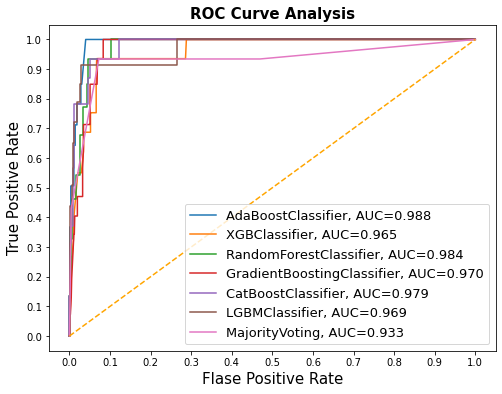

In [26]:
fig = plt.figure(figsize=(8,6))

for i in res.index:
    plt.plot(res.loc[i]['fpr'], 
             res.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, res.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### <font color='purple'> Critical Diagram 

In [27]:
def compare_results(results, lst_models):      
        fried_result = friedmanchisquare(*results)
        
        ranks = np.array([rankdata(-p) for p in results])
        
        # Calculating the average ranks.
        average_ranks = np.mean(ranks, axis=0)

        names = [lst_models[i] + ' - ' + str(round(average_ranks[i], 3)) for i in range(len(average_ranks))]
        
        # This method computes the critical difference for Nemenyi test with alpha=0.1.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd = compute_CD(average_ranks, n=len(results),alpha='0.05', test='nemenyi')
        
        # This method computes the critical difference for Bonferroni-Dunn test with alpha=0.05.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd1 = compute_CD(average_ranks, n=len(results), alpha='0.05', test='bonferroni-dunn')
        
        return fried_result, ranks, names, (cd, cd1), average_ranks

In [28]:
def plot_comparisons(fried_result, names, cd, cd1, average_ranks):    
    # This method generates the plot.
    graph_ranks(average_ranks, names=names,
                        cd=cd, width=10, textspace=1.5)
        
    plt.title(f'Friedman-Nemenyi={round(fried_result.pvalue, 4)}\nCD={round(cd, 3)}')
    plt.show()
    
    return

In [29]:
names = ['AdaBoostClassifier', 'XGBClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 
         'CatBoostClassifier', 'LGBMClassifier', 'VotingClassifier']

dct_results = {}

for n in names:
    res = full_results[full_results.classifiers == n].accuracy.to_list()[0]
    dct_results[n] = res

results = np.c_[dct_results['AdaBoostClassifier'], dct_results['XGBClassifier'], dct_results['RandomForestClassifier'], 
                dct_results['GradientBoostingClassifier'], dct_results['CatBoostClassifier'], dct_results['LGBMClassifier'], 
                dct_results['VotingClassifier']]

fried_result, ranks, names, (cd, cd1), average_ranks = compare_results(results, names)

In [30]:
names

['AdaBoostClassifier - 1.8',
 'XGBClassifier - 6.0',
 'RandomForestClassifier - 1.9',
 'GradientBoostingClassifier - 6.2',
 'CatBoostClassifier - 4.05',
 'LGBMClassifier - 2.9',
 'VotingClassifier - 5.15']

In [31]:
edited_names = ['AdaBoostClassifier - 2.1',
                 'XGBClassifier - 6.1',
                 'RandomForestClassifier - 1.6',
                 'GradientBoostingClassifier - 6.3',
                 'CatBoostClassifier - 4.3',
                 'LGBMClassifier - 3.2',
                 'MajorityVoting - 4.4']

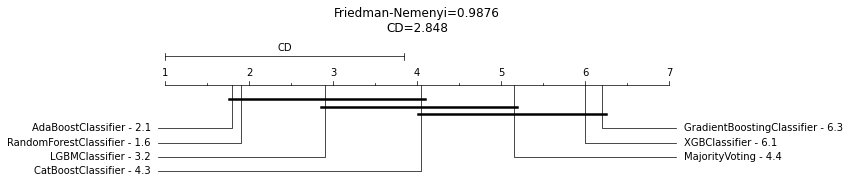

In [32]:
plot_comparisons(fried_result, edited_names, cd, cd1, average_ranks)

### <font color='green'> Static Ensemble ML models (+FS)

In [47]:
model_dt1 = DecisionTreeClassifier()
model_dt2 = DecisionTreeClassifier()
model_dt3 = DecisionTreeClassifier()
model_dt4 = DecisionTreeClassifier()
model_dt5 = DecisionTreeClassifier()

voting_classifiers = [("dt1", model_dt1),
                      ("dt2", model_dt2),
                      ("dt3", model_dt3),
                      ("dt4", model_dt4), 
                      ("dt5", model_dt5)]

classifiers = [
               AdaBoostClassifier(),
               XGBClassifier(), 
               RandomForestClassifier(criterion='gini', max_depth=7), 
               GradientBoostingClassifier(),
               CatBoostClassifier(), 
               LGBMClassifier(),
               VotingClassifier(estimators = voting_classifiers, voting='soft')
              ]

table, results_table, full_results = get_results(train_dfs, test_data, classifiers)

[15:55:44] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:44] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:44] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:44] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

140:	learn: 0.0280489	total: 524ms	remaining: 3.19s
141:	learn: 0.0276107	total: 527ms	remaining: 3.19s
142:	learn: 0.0272780	total: 531ms	remaining: 3.18s
143:	learn: 0.0270353	total: 535ms	remaining: 3.18s
144:	learn: 0.0265187	total: 539ms	remaining: 3.18s
145:	learn: 0.0262505	total: 543ms	remaining: 3.17s
146:	learn: 0.0259681	total: 546ms	remaining: 3.17s
147:	learn: 0.0256923	total: 550ms	remaining: 3.16s
148:	learn: 0.0254166	total: 554ms	remaining: 3.16s
149:	learn: 0.0251590	total: 557ms	remaining: 3.16s
150:	learn: 0.0249252	total: 561ms	remaining: 3.15s
151:	learn: 0.0247318	total: 564ms	remaining: 3.15s
152:	learn: 0.0245067	total: 568ms	remaining: 3.15s
153:	learn: 0.0241921	total: 572ms	remaining: 3.14s
154:	learn: 0.0239636	total: 576ms	remaining: 3.14s
155:	learn: 0.0237527	total: 580ms	remaining: 3.14s
156:	learn: 0.0234480	total: 584ms	remaining: 3.13s
157:	learn: 0.0230787	total: 588ms	remaining: 3.13s
158:	learn: 0.0228132	total: 600ms	remaining: 3.17s
159:	learn: 

318:	learn: 0.0068582	total: 1.22s	remaining: 2.6s
319:	learn: 0.0068153	total: 1.22s	remaining: 2.6s
320:	learn: 0.0067645	total: 1.23s	remaining: 2.6s
321:	learn: 0.0067421	total: 1.23s	remaining: 2.59s
322:	learn: 0.0067089	total: 1.24s	remaining: 2.59s
323:	learn: 0.0066658	total: 1.24s	remaining: 2.58s
324:	learn: 0.0066291	total: 1.25s	remaining: 2.59s
325:	learn: 0.0066142	total: 1.25s	remaining: 2.59s
326:	learn: 0.0065791	total: 1.25s	remaining: 2.58s
327:	learn: 0.0065585	total: 1.26s	remaining: 2.58s
328:	learn: 0.0065142	total: 1.26s	remaining: 2.58s
329:	learn: 0.0064602	total: 1.27s	remaining: 2.57s
330:	learn: 0.0064268	total: 1.27s	remaining: 2.57s
331:	learn: 0.0063990	total: 1.27s	remaining: 2.56s
332:	learn: 0.0063556	total: 1.28s	remaining: 2.56s
333:	learn: 0.0062950	total: 1.28s	remaining: 2.55s
334:	learn: 0.0062491	total: 1.28s	remaining: 2.55s
335:	learn: 0.0062123	total: 1.29s	remaining: 2.54s
336:	learn: 0.0061863	total: 1.29s	remaining: 2.54s
337:	learn: 0.0

519:	learn: 0.0029161	total: 1.91s	remaining: 1.76s
520:	learn: 0.0029104	total: 1.92s	remaining: 1.76s
521:	learn: 0.0029002	total: 1.92s	remaining: 1.76s
522:	learn: 0.0028905	total: 1.92s	remaining: 1.75s
523:	learn: 0.0028856	total: 1.93s	remaining: 1.75s
524:	learn: 0.0028743	total: 1.93s	remaining: 1.75s
525:	learn: 0.0028655	total: 1.93s	remaining: 1.74s
526:	learn: 0.0028539	total: 1.94s	remaining: 1.74s
527:	learn: 0.0028392	total: 1.94s	remaining: 1.73s
528:	learn: 0.0028255	total: 1.94s	remaining: 1.73s
529:	learn: 0.0028179	total: 1.95s	remaining: 1.73s
530:	learn: 0.0028066	total: 1.95s	remaining: 1.72s
531:	learn: 0.0027962	total: 1.95s	remaining: 1.72s
532:	learn: 0.0027908	total: 1.96s	remaining: 1.71s
533:	learn: 0.0027798	total: 1.96s	remaining: 1.71s
534:	learn: 0.0027744	total: 1.96s	remaining: 1.71s
535:	learn: 0.0027708	total: 1.97s	remaining: 1.7s
536:	learn: 0.0027634	total: 1.97s	remaining: 1.7s
537:	learn: 0.0027596	total: 1.97s	remaining: 1.69s
538:	learn: 0.

722:	learn: 0.0019621	total: 2.6s	remaining: 997ms
723:	learn: 0.0019621	total: 2.61s	remaining: 994ms
724:	learn: 0.0019621	total: 2.61s	remaining: 990ms
725:	learn: 0.0019621	total: 2.61s	remaining: 986ms
726:	learn: 0.0019575	total: 2.62s	remaining: 983ms
727:	learn: 0.0019575	total: 2.62s	remaining: 979ms
728:	learn: 0.0019529	total: 2.63s	remaining: 976ms
729:	learn: 0.0019481	total: 2.63s	remaining: 972ms
730:	learn: 0.0019481	total: 2.63s	remaining: 968ms
731:	learn: 0.0019481	total: 2.63s	remaining: 965ms
732:	learn: 0.0019428	total: 2.64s	remaining: 961ms
733:	learn: 0.0019381	total: 2.64s	remaining: 957ms
734:	learn: 0.0019337	total: 2.65s	remaining: 954ms
735:	learn: 0.0019293	total: 2.65s	remaining: 950ms
736:	learn: 0.0019236	total: 2.65s	remaining: 947ms
737:	learn: 0.0019192	total: 2.66s	remaining: 943ms
738:	learn: 0.0019143	total: 2.66s	remaining: 939ms
739:	learn: 0.0019080	total: 2.66s	remaining: 936ms
740:	learn: 0.0019039	total: 2.67s	remaining: 933ms
741:	learn: 0

889:	learn: 0.0017358	total: 3.3s	remaining: 408ms
890:	learn: 0.0017358	total: 3.31s	remaining: 404ms
891:	learn: 0.0017358	total: 3.31s	remaining: 401ms
892:	learn: 0.0017358	total: 3.32s	remaining: 397ms
893:	learn: 0.0017358	total: 3.32s	remaining: 394ms
894:	learn: 0.0017358	total: 3.33s	remaining: 390ms
895:	learn: 0.0017358	total: 3.33s	remaining: 387ms
896:	learn: 0.0017358	total: 3.33s	remaining: 383ms
897:	learn: 0.0017358	total: 3.34s	remaining: 379ms
898:	learn: 0.0017358	total: 3.34s	remaining: 376ms
899:	learn: 0.0017358	total: 3.35s	remaining: 372ms
900:	learn: 0.0017358	total: 3.35s	remaining: 368ms
901:	learn: 0.0017358	total: 3.36s	remaining: 365ms
902:	learn: 0.0017315	total: 3.36s	remaining: 361ms
903:	learn: 0.0017268	total: 3.37s	remaining: 358ms
904:	learn: 0.0017268	total: 3.37s	remaining: 354ms
905:	learn: 0.0017268	total: 3.38s	remaining: 351ms
906:	learn: 0.0017230	total: 3.38s	remaining: 347ms
907:	learn: 0.0017188	total: 3.39s	remaining: 343ms
908:	learn: 0

75:	learn: 0.0706822	total: 347ms	remaining: 4.22s
76:	learn: 0.0694734	total: 351ms	remaining: 4.21s
77:	learn: 0.0677610	total: 354ms	remaining: 4.19s
78:	learn: 0.0665727	total: 358ms	remaining: 4.17s
79:	learn: 0.0653700	total: 361ms	remaining: 4.15s
80:	learn: 0.0642315	total: 364ms	remaining: 4.13s
81:	learn: 0.0633861	total: 368ms	remaining: 4.12s
82:	learn: 0.0621546	total: 371ms	remaining: 4.1s
83:	learn: 0.0611761	total: 376ms	remaining: 4.1s
84:	learn: 0.0602059	total: 380ms	remaining: 4.09s
85:	learn: 0.0590628	total: 383ms	remaining: 4.07s
86:	learn: 0.0581136	total: 386ms	remaining: 4.05s
87:	learn: 0.0570614	total: 392ms	remaining: 4.06s
88:	learn: 0.0560772	total: 397ms	remaining: 4.06s
89:	learn: 0.0546984	total: 401ms	remaining: 4.06s
90:	learn: 0.0536219	total: 405ms	remaining: 4.05s
91:	learn: 0.0525213	total: 409ms	remaining: 4.04s
92:	learn: 0.0513498	total: 412ms	remaining: 4.02s
93:	learn: 0.0507378	total: 416ms	remaining: 4.01s
94:	learn: 0.0500401	total: 419ms

273:	learn: 0.0091377	total: 1.04s	remaining: 2.77s
274:	learn: 0.0090815	total: 1.05s	remaining: 2.76s
275:	learn: 0.0090140	total: 1.05s	remaining: 2.76s
276:	learn: 0.0089374	total: 1.05s	remaining: 2.75s
277:	learn: 0.0088557	total: 1.06s	remaining: 2.75s
278:	learn: 0.0087823	total: 1.06s	remaining: 2.74s
279:	learn: 0.0087275	total: 1.06s	remaining: 2.74s
280:	learn: 0.0086371	total: 1.07s	remaining: 2.73s
281:	learn: 0.0085825	total: 1.07s	remaining: 2.73s
282:	learn: 0.0085208	total: 1.07s	remaining: 2.73s
283:	learn: 0.0084783	total: 1.08s	remaining: 2.72s
284:	learn: 0.0084432	total: 1.08s	remaining: 2.71s
285:	learn: 0.0084118	total: 1.08s	remaining: 2.71s
286:	learn: 0.0083609	total: 1.09s	remaining: 2.71s
287:	learn: 0.0083185	total: 1.09s	remaining: 2.71s
288:	learn: 0.0082818	total: 1.1s	remaining: 2.7s
289:	learn: 0.0082694	total: 1.1s	remaining: 2.7s
290:	learn: 0.0081947	total: 1.1s	remaining: 2.69s
291:	learn: 0.0081491	total: 1.11s	remaining: 2.69s
292:	learn: 0.008

461:	learn: 0.0036637	total: 1.74s	remaining: 2.03s
462:	learn: 0.0036467	total: 1.74s	remaining: 2.02s
463:	learn: 0.0036334	total: 1.75s	remaining: 2.02s
464:	learn: 0.0036177	total: 1.75s	remaining: 2.01s
465:	learn: 0.0036091	total: 1.75s	remaining: 2.01s
466:	learn: 0.0035919	total: 1.76s	remaining: 2s
467:	learn: 0.0035765	total: 1.76s	remaining: 2s
468:	learn: 0.0035654	total: 1.76s	remaining: 2s
469:	learn: 0.0035485	total: 1.76s	remaining: 1.99s
470:	learn: 0.0035348	total: 1.77s	remaining: 1.99s
471:	learn: 0.0035348	total: 1.77s	remaining: 1.98s
472:	learn: 0.0035286	total: 1.77s	remaining: 1.98s
473:	learn: 0.0035286	total: 1.78s	remaining: 1.97s
474:	learn: 0.0035179	total: 1.78s	remaining: 1.97s
475:	learn: 0.0035179	total: 1.78s	remaining: 1.97s
476:	learn: 0.0035050	total: 1.79s	remaining: 1.97s
477:	learn: 0.0034871	total: 1.79s	remaining: 1.96s
478:	learn: 0.0034762	total: 1.8s	remaining: 1.96s
479:	learn: 0.0034660	total: 1.8s	remaining: 1.95s
480:	learn: 0.0034502	t

673:	learn: 0.0020881	total: 2.44s	remaining: 1.18s
674:	learn: 0.0020881	total: 2.44s	remaining: 1.18s
675:	learn: 0.0020881	total: 2.44s	remaining: 1.17s
676:	learn: 0.0020881	total: 2.45s	remaining: 1.17s
677:	learn: 0.0020881	total: 2.45s	remaining: 1.16s
678:	learn: 0.0020881	total: 2.45s	remaining: 1.16s
679:	learn: 0.0020881	total: 2.46s	remaining: 1.16s
680:	learn: 0.0020881	total: 2.46s	remaining: 1.15s
681:	learn: 0.0020880	total: 2.46s	remaining: 1.15s
682:	learn: 0.0020880	total: 2.46s	remaining: 1.14s
683:	learn: 0.0020880	total: 2.47s	remaining: 1.14s
684:	learn: 0.0020880	total: 2.47s	remaining: 1.14s
685:	learn: 0.0020880	total: 2.47s	remaining: 1.13s
686:	learn: 0.0020880	total: 2.48s	remaining: 1.13s
687:	learn: 0.0020880	total: 2.48s	remaining: 1.12s
688:	learn: 0.0020880	total: 2.48s	remaining: 1.12s
689:	learn: 0.0020880	total: 2.48s	remaining: 1.12s
690:	learn: 0.0020880	total: 2.49s	remaining: 1.11s
691:	learn: 0.0020880	total: 2.49s	remaining: 1.11s
692:	learn: 

846:	learn: 0.0020482	total: 2.96s	remaining: 535ms
847:	learn: 0.0020482	total: 2.96s	remaining: 532ms
848:	learn: 0.0020482	total: 2.97s	remaining: 528ms
849:	learn: 0.0020482	total: 2.97s	remaining: 524ms
850:	learn: 0.0020482	total: 2.97s	remaining: 521ms
851:	learn: 0.0020482	total: 2.98s	remaining: 517ms
852:	learn: 0.0020482	total: 2.98s	remaining: 514ms
853:	learn: 0.0020482	total: 2.98s	remaining: 510ms
854:	learn: 0.0020482	total: 2.99s	remaining: 506ms
855:	learn: 0.0020482	total: 2.99s	remaining: 503ms
856:	learn: 0.0020482	total: 2.99s	remaining: 499ms
857:	learn: 0.0020482	total: 2.99s	remaining: 496ms
858:	learn: 0.0020482	total: 3s	remaining: 492ms
859:	learn: 0.0020482	total: 3s	remaining: 488ms
860:	learn: 0.0020482	total: 3s	remaining: 485ms
861:	learn: 0.0020482	total: 3.01s	remaining: 481ms
862:	learn: 0.0020482	total: 3.01s	remaining: 478ms
863:	learn: 0.0020482	total: 3.01s	remaining: 474ms
864:	learn: 0.0020482	total: 3.01s	remaining: 471ms
865:	learn: 0.0020482

26:	learn: 0.2388206	total: 171ms	remaining: 6.15s
27:	learn: 0.2299717	total: 174ms	remaining: 6.05s
28:	learn: 0.2218547	total: 178ms	remaining: 5.95s
29:	learn: 0.2137667	total: 181ms	remaining: 5.85s
30:	learn: 0.2047034	total: 184ms	remaining: 5.75s
31:	learn: 0.1980464	total: 187ms	remaining: 5.67s
32:	learn: 0.1936514	total: 191ms	remaining: 5.58s
33:	learn: 0.1880363	total: 194ms	remaining: 5.51s
34:	learn: 0.1839853	total: 197ms	remaining: 5.43s
35:	learn: 0.1805056	total: 200ms	remaining: 5.36s
36:	learn: 0.1769127	total: 204ms	remaining: 5.3s
37:	learn: 0.1721498	total: 207ms	remaining: 5.24s
38:	learn: 0.1672016	total: 210ms	remaining: 5.18s
39:	learn: 0.1627555	total: 214ms	remaining: 5.12s
40:	learn: 0.1581693	total: 217ms	remaining: 5.07s
41:	learn: 0.1540897	total: 220ms	remaining: 5.02s
42:	learn: 0.1510762	total: 224ms	remaining: 4.97s
43:	learn: 0.1465171	total: 227ms	remaining: 4.93s
44:	learn: 0.1431065	total: 230ms	remaining: 4.89s
45:	learn: 0.1390597	total: 234m

212:	learn: 0.0154757	total: 869ms	remaining: 3.21s
213:	learn: 0.0153621	total: 873ms	remaining: 3.2s
214:	learn: 0.0151992	total: 876ms	remaining: 3.2s
215:	learn: 0.0150563	total: 879ms	remaining: 3.19s
216:	learn: 0.0149142	total: 882ms	remaining: 3.18s
217:	learn: 0.0147830	total: 886ms	remaining: 3.18s
218:	learn: 0.0146633	total: 889ms	remaining: 3.17s
219:	learn: 0.0145914	total: 892ms	remaining: 3.16s
220:	learn: 0.0145008	total: 895ms	remaining: 3.15s
221:	learn: 0.0143906	total: 899ms	remaining: 3.15s
222:	learn: 0.0143035	total: 902ms	remaining: 3.14s
223:	learn: 0.0141993	total: 906ms	remaining: 3.14s
224:	learn: 0.0141466	total: 909ms	remaining: 3.13s
225:	learn: 0.0140616	total: 913ms	remaining: 3.13s
226:	learn: 0.0139590	total: 916ms	remaining: 3.12s
227:	learn: 0.0138038	total: 919ms	remaining: 3.11s
228:	learn: 0.0136707	total: 922ms	remaining: 3.1s
229:	learn: 0.0135913	total: 926ms	remaining: 3.1s
230:	learn: 0.0135126	total: 929ms	remaining: 3.09s
231:	learn: 0.01

372:	learn: 0.0057845	total: 1.39s	remaining: 2.34s
373:	learn: 0.0057605	total: 1.4s	remaining: 2.34s
374:	learn: 0.0057403	total: 1.4s	remaining: 2.33s
375:	learn: 0.0057132	total: 1.4s	remaining: 2.33s
376:	learn: 0.0056737	total: 1.41s	remaining: 2.33s
377:	learn: 0.0056505	total: 1.41s	remaining: 2.32s
378:	learn: 0.0056273	total: 1.41s	remaining: 2.32s
379:	learn: 0.0055846	total: 1.42s	remaining: 2.31s
380:	learn: 0.0055606	total: 1.42s	remaining: 2.31s
381:	learn: 0.0055223	total: 1.42s	remaining: 2.3s
382:	learn: 0.0054925	total: 1.43s	remaining: 2.3s
383:	learn: 0.0054645	total: 1.43s	remaining: 2.29s
384:	learn: 0.0054387	total: 1.43s	remaining: 2.29s
385:	learn: 0.0054255	total: 1.44s	remaining: 2.29s
386:	learn: 0.0053982	total: 1.44s	remaining: 2.28s
387:	learn: 0.0053704	total: 1.44s	remaining: 2.28s
388:	learn: 0.0053411	total: 1.45s	remaining: 2.27s
389:	learn: 0.0053252	total: 1.45s	remaining: 2.27s
390:	learn: 0.0052867	total: 1.45s	remaining: 2.26s
391:	learn: 0.005

531:	learn: 0.0029120	total: 1.92s	remaining: 1.69s
532:	learn: 0.0028978	total: 1.92s	remaining: 1.69s
533:	learn: 0.0028903	total: 1.93s	remaining: 1.68s
534:	learn: 0.0028819	total: 1.93s	remaining: 1.68s
535:	learn: 0.0028780	total: 1.93s	remaining: 1.67s
536:	learn: 0.0028689	total: 1.94s	remaining: 1.67s
537:	learn: 0.0028581	total: 1.94s	remaining: 1.67s
538:	learn: 0.0028462	total: 1.94s	remaining: 1.66s
539:	learn: 0.0028369	total: 1.95s	remaining: 1.66s
540:	learn: 0.0028305	total: 1.95s	remaining: 1.66s
541:	learn: 0.0028235	total: 1.95s	remaining: 1.65s
542:	learn: 0.0028141	total: 1.96s	remaining: 1.65s
543:	learn: 0.0028075	total: 1.96s	remaining: 1.64s
544:	learn: 0.0028006	total: 1.96s	remaining: 1.64s
545:	learn: 0.0027936	total: 1.97s	remaining: 1.64s
546:	learn: 0.0027791	total: 1.97s	remaining: 1.63s
547:	learn: 0.0027632	total: 1.97s	remaining: 1.63s
548:	learn: 0.0027541	total: 1.98s	remaining: 1.62s
549:	learn: 0.0027482	total: 1.98s	remaining: 1.62s
550:	learn: 

692:	learn: 0.0018724	total: 2.44s	remaining: 1.08s
693:	learn: 0.0018611	total: 2.45s	remaining: 1.08s
694:	learn: 0.0018544	total: 2.45s	remaining: 1.07s
695:	learn: 0.0018544	total: 2.45s	remaining: 1.07s
696:	learn: 0.0018544	total: 2.46s	remaining: 1.07s
697:	learn: 0.0018544	total: 2.46s	remaining: 1.06s
698:	learn: 0.0018510	total: 2.46s	remaining: 1.06s
699:	learn: 0.0018510	total: 2.47s	remaining: 1.06s
700:	learn: 0.0018510	total: 2.47s	remaining: 1.05s
701:	learn: 0.0018510	total: 2.47s	remaining: 1.05s
702:	learn: 0.0018510	total: 2.48s	remaining: 1.04s
703:	learn: 0.0018510	total: 2.48s	remaining: 1.04s
704:	learn: 0.0018427	total: 2.48s	remaining: 1.04s
705:	learn: 0.0018361	total: 2.48s	remaining: 1.03s
706:	learn: 0.0018325	total: 2.49s	remaining: 1.03s
707:	learn: 0.0018267	total: 2.49s	remaining: 1.03s
708:	learn: 0.0018217	total: 2.5s	remaining: 1.02s
709:	learn: 0.0018184	total: 2.5s	remaining: 1.02s
710:	learn: 0.0018184	total: 2.5s	remaining: 1.02s
711:	learn: 0.0

868:	learn: 0.0017547	total: 2.96s	remaining: 447ms
869:	learn: 0.0017547	total: 2.97s	remaining: 443ms
870:	learn: 0.0017547	total: 2.97s	remaining: 440ms
871:	learn: 0.0017547	total: 2.97s	remaining: 436ms
872:	learn: 0.0017547	total: 2.98s	remaining: 433ms
873:	learn: 0.0017547	total: 2.98s	remaining: 429ms
874:	learn: 0.0017547	total: 2.98s	remaining: 426ms
875:	learn: 0.0017547	total: 2.98s	remaining: 423ms
876:	learn: 0.0017547	total: 2.99s	remaining: 419ms
877:	learn: 0.0017547	total: 2.99s	remaining: 416ms
878:	learn: 0.0017547	total: 2.99s	remaining: 412ms
879:	learn: 0.0017547	total: 3s	remaining: 409ms
880:	learn: 0.0017547	total: 3s	remaining: 405ms
881:	learn: 0.0017547	total: 3s	remaining: 402ms
882:	learn: 0.0017547	total: 3s	remaining: 398ms
883:	learn: 0.0017547	total: 3.01s	remaining: 395ms
884:	learn: 0.0017547	total: 3.01s	remaining: 391ms
885:	learn: 0.0017547	total: 3.01s	remaining: 388ms
886:	learn: 0.0017547	total: 3.02s	remaining: 384ms
887:	learn: 0.0017547	to

71:	learn: 0.0785094	total: 254ms	remaining: 3.28s
72:	learn: 0.0764295	total: 258ms	remaining: 3.27s
73:	learn: 0.0754560	total: 261ms	remaining: 3.27s
74:	learn: 0.0741189	total: 265ms	remaining: 3.27s
75:	learn: 0.0727794	total: 269ms	remaining: 3.27s
76:	learn: 0.0714960	total: 273ms	remaining: 3.27s
77:	learn: 0.0702942	total: 276ms	remaining: 3.26s
78:	learn: 0.0686362	total: 280ms	remaining: 3.26s
79:	learn: 0.0677389	total: 284ms	remaining: 3.27s
80:	learn: 0.0665710	total: 287ms	remaining: 3.26s
81:	learn: 0.0655279	total: 291ms	remaining: 3.25s
82:	learn: 0.0642179	total: 294ms	remaining: 3.25s
83:	learn: 0.0632606	total: 298ms	remaining: 3.25s
84:	learn: 0.0621289	total: 301ms	remaining: 3.24s
85:	learn: 0.0610570	total: 304ms	remaining: 3.23s
86:	learn: 0.0596490	total: 308ms	remaining: 3.23s
87:	learn: 0.0587277	total: 311ms	remaining: 3.23s
88:	learn: 0.0577750	total: 315ms	remaining: 3.22s
89:	learn: 0.0570803	total: 318ms	remaining: 3.21s
90:	learn: 0.0557381	total: 321

268:	learn: 0.0096955	total: 953ms	remaining: 2.59s
269:	learn: 0.0096348	total: 956ms	remaining: 2.58s
270:	learn: 0.0095879	total: 959ms	remaining: 2.58s
271:	learn: 0.0095588	total: 962ms	remaining: 2.58s
272:	learn: 0.0094842	total: 966ms	remaining: 2.57s
273:	learn: 0.0093974	total: 969ms	remaining: 2.57s
274:	learn: 0.0093531	total: 972ms	remaining: 2.56s
275:	learn: 0.0092763	total: 975ms	remaining: 2.56s
276:	learn: 0.0092040	total: 979ms	remaining: 2.55s
277:	learn: 0.0091484	total: 982ms	remaining: 2.55s
278:	learn: 0.0091015	total: 985ms	remaining: 2.54s
279:	learn: 0.0090600	total: 988ms	remaining: 2.54s
280:	learn: 0.0090193	total: 992ms	remaining: 2.54s
281:	learn: 0.0089710	total: 995ms	remaining: 2.53s
282:	learn: 0.0088863	total: 999ms	remaining: 2.53s
283:	learn: 0.0088525	total: 1s	remaining: 2.52s
284:	learn: 0.0088101	total: 1s	remaining: 2.52s
285:	learn: 0.0087859	total: 1.01s	remaining: 2.52s
286:	learn: 0.0087181	total: 1.01s	remaining: 2.51s
287:	learn: 0.0086

478:	learn: 0.0034604	total: 1.65s	remaining: 1.8s
479:	learn: 0.0034475	total: 1.66s	remaining: 1.79s
480:	learn: 0.0034270	total: 1.66s	remaining: 1.79s
481:	learn: 0.0034117	total: 1.66s	remaining: 1.79s
482:	learn: 0.0034012	total: 1.67s	remaining: 1.78s
483:	learn: 0.0033935	total: 1.68s	remaining: 1.79s
484:	learn: 0.0033849	total: 1.69s	remaining: 1.79s
485:	learn: 0.0033771	total: 1.69s	remaining: 1.79s
486:	learn: 0.0033627	total: 1.7s	remaining: 1.79s
487:	learn: 0.0033513	total: 1.7s	remaining: 1.79s
488:	learn: 0.0033424	total: 1.71s	remaining: 1.78s
489:	learn: 0.0033309	total: 1.71s	remaining: 1.78s
490:	learn: 0.0033108	total: 1.72s	remaining: 1.78s
491:	learn: 0.0033042	total: 1.72s	remaining: 1.77s
492:	learn: 0.0032991	total: 1.72s	remaining: 1.77s
493:	learn: 0.0032886	total: 1.73s	remaining: 1.77s
494:	learn: 0.0032800	total: 1.73s	remaining: 1.76s
495:	learn: 0.0032732	total: 1.73s	remaining: 1.76s
496:	learn: 0.0032694	total: 1.74s	remaining: 1.76s
497:	learn: 0.0

680:	learn: 0.0021228	total: 2.35s	remaining: 1.1s
681:	learn: 0.0021173	total: 2.35s	remaining: 1.1s
682:	learn: 0.0021125	total: 2.36s	remaining: 1.09s
683:	learn: 0.0021061	total: 2.36s	remaining: 1.09s
684:	learn: 0.0021061	total: 2.36s	remaining: 1.09s
685:	learn: 0.0020951	total: 2.37s	remaining: 1.08s
686:	learn: 0.0020881	total: 2.37s	remaining: 1.08s
687:	learn: 0.0020814	total: 2.37s	remaining: 1.08s
688:	learn: 0.0020731	total: 2.38s	remaining: 1.07s
689:	learn: 0.0020675	total: 2.38s	remaining: 1.07s
690:	learn: 0.0020642	total: 2.38s	remaining: 1.06s
691:	learn: 0.0020642	total: 2.39s	remaining: 1.06s
692:	learn: 0.0020642	total: 2.39s	remaining: 1.06s
693:	learn: 0.0020545	total: 2.39s	remaining: 1.05s
694:	learn: 0.0020545	total: 2.4s	remaining: 1.05s
695:	learn: 0.0020493	total: 2.4s	remaining: 1.05s
696:	learn: 0.0020432	total: 2.4s	remaining: 1.04s
697:	learn: 0.0020387	total: 2.4s	remaining: 1.04s
698:	learn: 0.0020339	total: 2.41s	remaining: 1.04s
699:	learn: 0.0020

851:	learn: 0.0017644	total: 2.87s	remaining: 499ms
852:	learn: 0.0017644	total: 2.88s	remaining: 496ms
853:	learn: 0.0017644	total: 2.88s	remaining: 492ms
854:	learn: 0.0017644	total: 2.88s	remaining: 489ms
855:	learn: 0.0017644	total: 2.88s	remaining: 485ms
856:	learn: 0.0017644	total: 2.89s	remaining: 482ms
857:	learn: 0.0017644	total: 2.89s	remaining: 479ms
858:	learn: 0.0017644	total: 2.89s	remaining: 475ms
859:	learn: 0.0017644	total: 2.9s	remaining: 472ms
860:	learn: 0.0017596	total: 2.9s	remaining: 468ms
861:	learn: 0.0017564	total: 2.9s	remaining: 465ms
862:	learn: 0.0017564	total: 2.91s	remaining: 461ms
863:	learn: 0.0017531	total: 2.91s	remaining: 458ms
864:	learn: 0.0017531	total: 2.91s	remaining: 455ms
865:	learn: 0.0017531	total: 2.92s	remaining: 451ms
866:	learn: 0.0017531	total: 2.92s	remaining: 448ms
867:	learn: 0.0017484	total: 2.92s	remaining: 444ms
868:	learn: 0.0017457	total: 2.92s	remaining: 441ms
869:	learn: 0.0017457	total: 2.93s	remaining: 438ms
870:	learn: 0.0

10:	learn: 0.4234795	total: 37ms	remaining: 3.33s
11:	learn: 0.4072983	total: 40.4ms	remaining: 3.33s
12:	learn: 0.3858193	total: 44.1ms	remaining: 3.35s
13:	learn: 0.3719267	total: 47.3ms	remaining: 3.33s
14:	learn: 0.3579264	total: 50.7ms	remaining: 3.33s
15:	learn: 0.3434727	total: 54ms	remaining: 3.32s
16:	learn: 0.3279384	total: 57.3ms	remaining: 3.31s
17:	learn: 0.3165099	total: 60.4ms	remaining: 3.3s
18:	learn: 0.3054482	total: 63.8ms	remaining: 3.29s
19:	learn: 0.2959480	total: 67.4ms	remaining: 3.3s
20:	learn: 0.2858757	total: 71.2ms	remaining: 3.32s
21:	learn: 0.2753888	total: 75.1ms	remaining: 3.34s
22:	learn: 0.2656118	total: 79.2ms	remaining: 3.36s
23:	learn: 0.2569056	total: 82.9ms	remaining: 3.37s
24:	learn: 0.2488147	total: 86.3ms	remaining: 3.37s
25:	learn: 0.2422303	total: 90ms	remaining: 3.37s
26:	learn: 0.2340505	total: 93.7ms	remaining: 3.38s
27:	learn: 0.2270365	total: 97.3ms	remaining: 3.38s
28:	learn: 0.2206233	total: 101ms	remaining: 3.37s
29:	learn: 0.2143466	

207:	learn: 0.0150255	total: 736ms	remaining: 2.8s
208:	learn: 0.0149221	total: 740ms	remaining: 2.8s
209:	learn: 0.0148113	total: 743ms	remaining: 2.79s
210:	learn: 0.0147187	total: 746ms	remaining: 2.79s
211:	learn: 0.0146481	total: 749ms	remaining: 2.78s
212:	learn: 0.0145604	total: 753ms	remaining: 2.78s
213:	learn: 0.0144544	total: 756ms	remaining: 2.78s
214:	learn: 0.0142758	total: 759ms	remaining: 2.77s
215:	learn: 0.0141079	total: 762ms	remaining: 2.77s
216:	learn: 0.0139835	total: 766ms	remaining: 2.76s
217:	learn: 0.0138495	total: 769ms	remaining: 2.76s
218:	learn: 0.0137511	total: 772ms	remaining: 2.75s
219:	learn: 0.0136655	total: 775ms	remaining: 2.75s
220:	learn: 0.0135790	total: 779ms	remaining: 2.74s
221:	learn: 0.0135001	total: 782ms	remaining: 2.74s
222:	learn: 0.0133896	total: 785ms	remaining: 2.73s
223:	learn: 0.0133046	total: 788ms	remaining: 2.73s
224:	learn: 0.0132287	total: 792ms	remaining: 2.73s
225:	learn: 0.0131328	total: 795ms	remaining: 2.72s
226:	learn: 0.

404:	learn: 0.0045507	total: 1.44s	remaining: 2.11s
405:	learn: 0.0045317	total: 1.44s	remaining: 2.1s
406:	learn: 0.0045091	total: 1.44s	remaining: 2.1s
407:	learn: 0.0044867	total: 1.45s	remaining: 2.1s
408:	learn: 0.0044755	total: 1.45s	remaining: 2.09s
409:	learn: 0.0044642	total: 1.45s	remaining: 2.09s
410:	learn: 0.0044382	total: 1.45s	remaining: 2.08s
411:	learn: 0.0044161	total: 1.46s	remaining: 2.08s
412:	learn: 0.0044002	total: 1.46s	remaining: 2.08s
413:	learn: 0.0043768	total: 1.46s	remaining: 2.07s
414:	learn: 0.0043495	total: 1.47s	remaining: 2.07s
415:	learn: 0.0043245	total: 1.47s	remaining: 2.06s
416:	learn: 0.0043132	total: 1.47s	remaining: 2.06s
417:	learn: 0.0042997	total: 1.48s	remaining: 2.06s
418:	learn: 0.0042785	total: 1.48s	remaining: 2.05s
419:	learn: 0.0042517	total: 1.48s	remaining: 2.05s
420:	learn: 0.0042364	total: 1.49s	remaining: 2.05s
421:	learn: 0.0042236	total: 1.49s	remaining: 2.04s
422:	learn: 0.0042122	total: 1.49s	remaining: 2.04s
423:	learn: 0.0

566:	learn: 0.0025508	total: 1.96s	remaining: 1.5s
567:	learn: 0.0025410	total: 1.96s	remaining: 1.49s
568:	learn: 0.0025352	total: 1.97s	remaining: 1.49s
569:	learn: 0.0025268	total: 1.97s	remaining: 1.49s
570:	learn: 0.0025114	total: 1.97s	remaining: 1.48s
571:	learn: 0.0025075	total: 1.98s	remaining: 1.48s
572:	learn: 0.0024946	total: 1.98s	remaining: 1.48s
573:	learn: 0.0024898	total: 1.98s	remaining: 1.47s
574:	learn: 0.0024828	total: 1.99s	remaining: 1.47s
575:	learn: 0.0024753	total: 1.99s	remaining: 1.46s
576:	learn: 0.0024688	total: 1.99s	remaining: 1.46s
577:	learn: 0.0024622	total: 2s	remaining: 1.46s
578:	learn: 0.0024558	total: 2s	remaining: 1.45s
579:	learn: 0.0024486	total: 2s	remaining: 1.45s
580:	learn: 0.0024408	total: 2s	remaining: 1.45s
581:	learn: 0.0024361	total: 2.01s	remaining: 1.44s
582:	learn: 0.0024297	total: 2.01s	remaining: 1.44s
583:	learn: 0.0024222	total: 2.02s	remaining: 1.44s
584:	learn: 0.0024154	total: 2.02s	remaining: 1.43s
585:	learn: 0.0024154	tot

729:	learn: 0.0019125	total: 2.48s	remaining: 919ms
730:	learn: 0.0019125	total: 2.49s	remaining: 915ms
731:	learn: 0.0019125	total: 2.49s	remaining: 912ms
732:	learn: 0.0019125	total: 2.49s	remaining: 908ms
733:	learn: 0.0019125	total: 2.5s	remaining: 904ms
734:	learn: 0.0019125	total: 2.5s	remaining: 901ms
735:	learn: 0.0019048	total: 2.5s	remaining: 897ms
736:	learn: 0.0019047	total: 2.5s	remaining: 894ms
737:	learn: 0.0019047	total: 2.51s	remaining: 890ms
738:	learn: 0.0019047	total: 2.51s	remaining: 887ms
739:	learn: 0.0019047	total: 2.51s	remaining: 883ms
740:	learn: 0.0019007	total: 2.52s	remaining: 880ms
741:	learn: 0.0019007	total: 2.52s	remaining: 877ms
742:	learn: 0.0019007	total: 2.52s	remaining: 873ms
743:	learn: 0.0019007	total: 2.53s	remaining: 870ms
744:	learn: 0.0019007	total: 2.53s	remaining: 866ms
745:	learn: 0.0019007	total: 2.53s	remaining: 863ms
746:	learn: 0.0019007	total: 2.54s	remaining: 859ms
747:	learn: 0.0019007	total: 2.54s	remaining: 856ms
748:	learn: 0.00

899:	learn: 0.0018038	total: 3s	remaining: 334ms
900:	learn: 0.0018038	total: 3.01s	remaining: 330ms
901:	learn: 0.0018038	total: 3.01s	remaining: 327ms
902:	learn: 0.0018038	total: 3.01s	remaining: 324ms
903:	learn: 0.0018038	total: 3.02s	remaining: 320ms
904:	learn: 0.0018038	total: 3.02s	remaining: 317ms
905:	learn: 0.0018038	total: 3.02s	remaining: 314ms
906:	learn: 0.0018038	total: 3.02s	remaining: 310ms
907:	learn: 0.0018038	total: 3.03s	remaining: 307ms
908:	learn: 0.0018038	total: 3.03s	remaining: 303ms
909:	learn: 0.0018038	total: 3.03s	remaining: 300ms
910:	learn: 0.0018038	total: 3.04s	remaining: 297ms
911:	learn: 0.0018038	total: 3.04s	remaining: 293ms
912:	learn: 0.0018038	total: 3.04s	remaining: 290ms
913:	learn: 0.0018038	total: 3.04s	remaining: 287ms
914:	learn: 0.0018038	total: 3.05s	remaining: 283ms
915:	learn: 0.0018038	total: 3.05s	remaining: 280ms
916:	learn: 0.0018038	total: 3.05s	remaining: 276ms
917:	learn: 0.0018038	total: 3.06s	remaining: 273ms
918:	learn: 0.0

76:	learn: 0.0735454	total: 343ms	remaining: 4.11s
77:	learn: 0.0720942	total: 348ms	remaining: 4.11s
78:	learn: 0.0703677	total: 356ms	remaining: 4.14s
79:	learn: 0.0691895	total: 360ms	remaining: 4.14s
80:	learn: 0.0682512	total: 364ms	remaining: 4.13s
81:	learn: 0.0670041	total: 369ms	remaining: 4.13s
82:	learn: 0.0657497	total: 373ms	remaining: 4.12s
83:	learn: 0.0646630	total: 377ms	remaining: 4.11s
84:	learn: 0.0635599	total: 381ms	remaining: 4.1s
85:	learn: 0.0626429	total: 385ms	remaining: 4.09s
86:	learn: 0.0611708	total: 389ms	remaining: 4.08s
87:	learn: 0.0601290	total: 394ms	remaining: 4.08s
88:	learn: 0.0591796	total: 398ms	remaining: 4.07s
89:	learn: 0.0577189	total: 402ms	remaining: 4.06s
90:	learn: 0.0570484	total: 406ms	remaining: 4.05s
91:	learn: 0.0561929	total: 409ms	remaining: 4.04s
92:	learn: 0.0553461	total: 414ms	remaining: 4.04s
93:	learn: 0.0542188	total: 418ms	remaining: 4.03s
94:	learn: 0.0532335	total: 421ms	remaining: 4.01s
95:	learn: 0.0519070	total: 424m

244:	learn: 0.0117815	total: 1.04s	remaining: 3.2s
245:	learn: 0.0116392	total: 1.04s	remaining: 3.19s
246:	learn: 0.0115436	total: 1.04s	remaining: 3.19s
247:	learn: 0.0114340	total: 1.05s	remaining: 3.19s
248:	learn: 0.0113745	total: 1.05s	remaining: 3.18s
249:	learn: 0.0113177	total: 1.06s	remaining: 3.18s
250:	learn: 0.0112603	total: 1.06s	remaining: 3.18s
251:	learn: 0.0111735	total: 1.07s	remaining: 3.17s
252:	learn: 0.0111371	total: 1.07s	remaining: 3.16s
253:	learn: 0.0110648	total: 1.08s	remaining: 3.16s
254:	learn: 0.0109678	total: 1.08s	remaining: 3.16s
255:	learn: 0.0108707	total: 1.08s	remaining: 3.15s
256:	learn: 0.0107903	total: 1.09s	remaining: 3.15s
257:	learn: 0.0107197	total: 1.09s	remaining: 3.15s
258:	learn: 0.0106510	total: 1.1s	remaining: 3.14s
259:	learn: 0.0105670	total: 1.1s	remaining: 3.13s
260:	learn: 0.0104810	total: 1.1s	remaining: 3.13s
261:	learn: 0.0104096	total: 1.11s	remaining: 3.12s
262:	learn: 0.0103462	total: 1.11s	remaining: 3.12s
263:	learn: 0.01

432:	learn: 0.0042370	total: 1.73s	remaining: 2.26s
433:	learn: 0.0042235	total: 1.73s	remaining: 2.25s
434:	learn: 0.0042026	total: 1.73s	remaining: 2.25s
435:	learn: 0.0041893	total: 1.74s	remaining: 2.25s
436:	learn: 0.0041627	total: 1.74s	remaining: 2.24s
437:	learn: 0.0041542	total: 1.74s	remaining: 2.24s
438:	learn: 0.0041335	total: 1.75s	remaining: 2.23s
439:	learn: 0.0041097	total: 1.75s	remaining: 2.23s
440:	learn: 0.0040958	total: 1.75s	remaining: 2.22s
441:	learn: 0.0040823	total: 1.76s	remaining: 2.22s
442:	learn: 0.0040659	total: 1.76s	remaining: 2.21s
443:	learn: 0.0040470	total: 1.76s	remaining: 2.21s
444:	learn: 0.0040271	total: 1.77s	remaining: 2.21s
445:	learn: 0.0040186	total: 1.77s	remaining: 2.2s
446:	learn: 0.0040096	total: 1.77s	remaining: 2.2s
447:	learn: 0.0039937	total: 1.78s	remaining: 2.19s
448:	learn: 0.0039886	total: 1.78s	remaining: 2.19s
449:	learn: 0.0039708	total: 1.78s	remaining: 2.18s
450:	learn: 0.0039479	total: 1.79s	remaining: 2.18s
451:	learn: 0.

609:	learn: 0.0023933	total: 2.42s	remaining: 1.55s
610:	learn: 0.0023933	total: 2.42s	remaining: 1.54s
611:	learn: 0.0023933	total: 2.43s	remaining: 1.54s
612:	learn: 0.0023883	total: 2.43s	remaining: 1.53s
613:	learn: 0.0023883	total: 2.44s	remaining: 1.53s
614:	learn: 0.0023834	total: 2.44s	remaining: 1.53s
615:	learn: 0.0023793	total: 2.44s	remaining: 1.52s
616:	learn: 0.0023793	total: 2.44s	remaining: 1.52s
617:	learn: 0.0023725	total: 2.45s	remaining: 1.51s
618:	learn: 0.0023630	total: 2.45s	remaining: 1.51s
619:	learn: 0.0023630	total: 2.45s	remaining: 1.5s
620:	learn: 0.0023601	total: 2.46s	remaining: 1.5s
621:	learn: 0.0023601	total: 2.46s	remaining: 1.5s
622:	learn: 0.0023601	total: 2.46s	remaining: 1.49s
623:	learn: 0.0023601	total: 2.47s	remaining: 1.49s
624:	learn: 0.0023601	total: 2.47s	remaining: 1.48s
625:	learn: 0.0023601	total: 2.47s	remaining: 1.48s
626:	learn: 0.0023601	total: 2.48s	remaining: 1.47s
627:	learn: 0.0023500	total: 2.48s	remaining: 1.47s
628:	learn: 0.0

775:	learn: 0.0019804	total: 3.12s	remaining: 901ms
776:	learn: 0.0019757	total: 3.13s	remaining: 897ms
777:	learn: 0.0019757	total: 3.13s	remaining: 893ms
778:	learn: 0.0019711	total: 3.13s	remaining: 889ms
779:	learn: 0.0019671	total: 3.14s	remaining: 886ms
780:	learn: 0.0019671	total: 3.15s	remaining: 882ms
781:	learn: 0.0019671	total: 3.15s	remaining: 878ms
782:	learn: 0.0019635	total: 3.15s	remaining: 874ms
783:	learn: 0.0019635	total: 3.16s	remaining: 870ms
784:	learn: 0.0019635	total: 3.16s	remaining: 865ms
785:	learn: 0.0019601	total: 3.16s	remaining: 861ms
786:	learn: 0.0019601	total: 3.17s	remaining: 857ms
787:	learn: 0.0019560	total: 3.17s	remaining: 853ms
788:	learn: 0.0019560	total: 3.17s	remaining: 849ms
789:	learn: 0.0019560	total: 3.18s	remaining: 844ms
790:	learn: 0.0019560	total: 3.18s	remaining: 840ms
791:	learn: 0.0019525	total: 3.18s	remaining: 836ms
792:	learn: 0.0019525	total: 3.19s	remaining: 832ms
793:	learn: 0.0019525	total: 3.19s	remaining: 827ms
794:	learn: 

972:	learn: 0.0018360	total: 3.81s	remaining: 106ms
973:	learn: 0.0018360	total: 3.81s	remaining: 102ms
974:	learn: 0.0018304	total: 3.81s	remaining: 97.7ms
975:	learn: 0.0018304	total: 3.81s	remaining: 93.8ms
976:	learn: 0.0018272	total: 3.82s	remaining: 89.9ms
977:	learn: 0.0018272	total: 3.82s	remaining: 86ms
978:	learn: 0.0018272	total: 3.83s	remaining: 82.1ms
979:	learn: 0.0018272	total: 3.83s	remaining: 78.1ms
980:	learn: 0.0018272	total: 3.83s	remaining: 74.2ms
981:	learn: 0.0018272	total: 3.83s	remaining: 70.3ms
982:	learn: 0.0018272	total: 3.84s	remaining: 66.4ms
983:	learn: 0.0018272	total: 3.84s	remaining: 62.5ms
984:	learn: 0.0018272	total: 3.84s	remaining: 58.5ms
985:	learn: 0.0018272	total: 3.85s	remaining: 54.6ms
986:	learn: 0.0018272	total: 3.85s	remaining: 50.7ms
987:	learn: 0.0018272	total: 3.85s	remaining: 46.8ms
988:	learn: 0.0018272	total: 3.85s	remaining: 42.9ms
989:	learn: 0.0018272	total: 3.86s	remaining: 39ms
990:	learn: 0.0018272	total: 3.86s	remaining: 35.1ms

165:	learn: 0.0209840	total: 571ms	remaining: 2.87s
166:	learn: 0.0207632	total: 575ms	remaining: 2.87s
167:	learn: 0.0206558	total: 578ms	remaining: 2.86s
168:	learn: 0.0204726	total: 581ms	remaining: 2.86s
169:	learn: 0.0202775	total: 584ms	remaining: 2.85s
170:	learn: 0.0200924	total: 588ms	remaining: 2.85s
171:	learn: 0.0199134	total: 591ms	remaining: 2.84s
172:	learn: 0.0197947	total: 594ms	remaining: 2.84s
173:	learn: 0.0195854	total: 597ms	remaining: 2.84s
174:	learn: 0.0193330	total: 601ms	remaining: 2.83s
175:	learn: 0.0192366	total: 604ms	remaining: 2.83s
176:	learn: 0.0190508	total: 607ms	remaining: 2.82s
177:	learn: 0.0188464	total: 610ms	remaining: 2.82s
178:	learn: 0.0186664	total: 614ms	remaining: 2.81s
179:	learn: 0.0185699	total: 617ms	remaining: 2.81s
180:	learn: 0.0184211	total: 620ms	remaining: 2.81s
181:	learn: 0.0181973	total: 623ms	remaining: 2.8s
182:	learn: 0.0180527	total: 627ms	remaining: 2.8s
183:	learn: 0.0177949	total: 630ms	remaining: 2.79s
184:	learn: 0.

326:	learn: 0.0063510	total: 1.1s	remaining: 2.26s
327:	learn: 0.0063191	total: 1.1s	remaining: 2.25s
328:	learn: 0.0062703	total: 1.1s	remaining: 2.25s
329:	learn: 0.0062347	total: 1.11s	remaining: 2.25s
330:	learn: 0.0061940	total: 1.11s	remaining: 2.24s
331:	learn: 0.0061404	total: 1.11s	remaining: 2.24s
332:	learn: 0.0061092	total: 1.12s	remaining: 2.24s
333:	learn: 0.0060745	total: 1.12s	remaining: 2.23s
334:	learn: 0.0060453	total: 1.12s	remaining: 2.23s
335:	learn: 0.0060287	total: 1.13s	remaining: 2.23s
336:	learn: 0.0060122	total: 1.13s	remaining: 2.22s
337:	learn: 0.0059665	total: 1.13s	remaining: 2.22s
338:	learn: 0.0059235	total: 1.14s	remaining: 2.21s
339:	learn: 0.0058961	total: 1.14s	remaining: 2.21s
340:	learn: 0.0058668	total: 1.14s	remaining: 2.21s
341:	learn: 0.0058538	total: 1.15s	remaining: 2.2s
342:	learn: 0.0058200	total: 1.15s	remaining: 2.2s
343:	learn: 0.0057756	total: 1.15s	remaining: 2.2s
344:	learn: 0.0057398	total: 1.16s	remaining: 2.19s
345:	learn: 0.0057

520:	learn: 0.0027426	total: 1.79s	remaining: 1.65s
521:	learn: 0.0027302	total: 1.8s	remaining: 1.65s
522:	learn: 0.0027170	total: 1.8s	remaining: 1.64s
523:	learn: 0.0027087	total: 1.81s	remaining: 1.64s
524:	learn: 0.0027025	total: 1.81s	remaining: 1.64s
525:	learn: 0.0026930	total: 1.81s	remaining: 1.63s
526:	learn: 0.0026799	total: 1.82s	remaining: 1.63s
527:	learn: 0.0026736	total: 1.82s	remaining: 1.63s
528:	learn: 0.0026639	total: 1.82s	remaining: 1.63s
529:	learn: 0.0026585	total: 1.83s	remaining: 1.62s
530:	learn: 0.0026524	total: 1.83s	remaining: 1.62s
531:	learn: 0.0026455	total: 1.84s	remaining: 1.62s
532:	learn: 0.0026385	total: 1.84s	remaining: 1.61s
533:	learn: 0.0026320	total: 1.85s	remaining: 1.61s
534:	learn: 0.0026248	total: 1.85s	remaining: 1.61s
535:	learn: 0.0026248	total: 1.85s	remaining: 1.61s
536:	learn: 0.0026165	total: 1.87s	remaining: 1.61s
537:	learn: 0.0026086	total: 1.88s	remaining: 1.61s
538:	learn: 0.0025991	total: 1.88s	remaining: 1.61s
539:	learn: 0.

717:	learn: 0.0018324	total: 2.49s	remaining: 977ms
718:	learn: 0.0018324	total: 2.49s	remaining: 973ms
719:	learn: 0.0018323	total: 2.49s	remaining: 970ms
720:	learn: 0.0018323	total: 2.5s	remaining: 966ms
721:	learn: 0.0018323	total: 2.5s	remaining: 962ms
722:	learn: 0.0018323	total: 2.5s	remaining: 959ms
723:	learn: 0.0018323	total: 2.5s	remaining: 955ms
724:	learn: 0.0018323	total: 2.51s	remaining: 951ms
725:	learn: 0.0018323	total: 2.51s	remaining: 948ms
726:	learn: 0.0018323	total: 2.51s	remaining: 944ms
727:	learn: 0.0018323	total: 2.52s	remaining: 940ms
728:	learn: 0.0018323	total: 2.52s	remaining: 937ms
729:	learn: 0.0018323	total: 2.52s	remaining: 933ms
730:	learn: 0.0018322	total: 2.52s	remaining: 930ms
731:	learn: 0.0018322	total: 2.53s	remaining: 926ms
732:	learn: 0.0018322	total: 2.53s	remaining: 922ms
733:	learn: 0.0018322	total: 2.53s	remaining: 919ms
734:	learn: 0.0018322	total: 2.54s	remaining: 915ms
735:	learn: 0.0018322	total: 2.54s	remaining: 911ms
736:	learn: 0.00

894:	learn: 0.0017665	total: 3.01s	remaining: 353ms
895:	learn: 0.0017665	total: 3.01s	remaining: 350ms
896:	learn: 0.0017665	total: 3.02s	remaining: 346ms
897:	learn: 0.0017664	total: 3.02s	remaining: 343ms
898:	learn: 0.0017664	total: 3.02s	remaining: 340ms
899:	learn: 0.0017664	total: 3.02s	remaining: 336ms
900:	learn: 0.0017664	total: 3.03s	remaining: 333ms
901:	learn: 0.0017664	total: 3.03s	remaining: 329ms
902:	learn: 0.0017664	total: 3.03s	remaining: 326ms
903:	learn: 0.0017664	total: 3.04s	remaining: 323ms
904:	learn: 0.0017664	total: 3.04s	remaining: 319ms
905:	learn: 0.0017664	total: 3.04s	remaining: 316ms
906:	learn: 0.0017664	total: 3.05s	remaining: 312ms
907:	learn: 0.0017664	total: 3.05s	remaining: 309ms
908:	learn: 0.0017664	total: 3.05s	remaining: 306ms
909:	learn: 0.0017664	total: 3.06s	remaining: 302ms
910:	learn: 0.0017664	total: 3.06s	remaining: 299ms
911:	learn: 0.0017664	total: 3.06s	remaining: 295ms
912:	learn: 0.0017664	total: 3.06s	remaining: 292ms
913:	learn: 

82:	learn: 0.0638032	total: 351ms	remaining: 3.88s
83:	learn: 0.0628940	total: 354ms	remaining: 3.86s
84:	learn: 0.0617512	total: 358ms	remaining: 3.85s
85:	learn: 0.0605642	total: 361ms	remaining: 3.84s
86:	learn: 0.0594530	total: 364ms	remaining: 3.82s
87:	learn: 0.0582055	total: 368ms	remaining: 3.81s
88:	learn: 0.0571261	total: 371ms	remaining: 3.79s
89:	learn: 0.0559339	total: 374ms	remaining: 3.78s
90:	learn: 0.0552040	total: 377ms	remaining: 3.77s
91:	learn: 0.0542916	total: 381ms	remaining: 3.76s
92:	learn: 0.0534532	total: 384ms	remaining: 3.74s
93:	learn: 0.0525587	total: 387ms	remaining: 3.73s
94:	learn: 0.0517749	total: 390ms	remaining: 3.72s
95:	learn: 0.0511731	total: 394ms	remaining: 3.71s
96:	learn: 0.0500225	total: 397ms	remaining: 3.69s
97:	learn: 0.0493178	total: 400ms	remaining: 3.68s
98:	learn: 0.0486840	total: 404ms	remaining: 3.67s
99:	learn: 0.0478334	total: 407ms	remaining: 3.66s
100:	learn: 0.0467021	total: 410ms	remaining: 3.65s
101:	learn: 0.0459119	total: 4

287:	learn: 0.0081733	total: 1.05s	remaining: 2.6s
288:	learn: 0.0081261	total: 1.06s	remaining: 2.6s
289:	learn: 0.0080808	total: 1.06s	remaining: 2.6s
290:	learn: 0.0080234	total: 1.06s	remaining: 2.59s
291:	learn: 0.0079349	total: 1.07s	remaining: 2.59s
292:	learn: 0.0078864	total: 1.07s	remaining: 2.58s
293:	learn: 0.0078375	total: 1.07s	remaining: 2.58s
294:	learn: 0.0077754	total: 1.08s	remaining: 2.57s
295:	learn: 0.0077504	total: 1.08s	remaining: 2.57s
296:	learn: 0.0076891	total: 1.08s	remaining: 2.56s
297:	learn: 0.0076404	total: 1.09s	remaining: 2.56s
298:	learn: 0.0075541	total: 1.09s	remaining: 2.56s
299:	learn: 0.0074954	total: 1.09s	remaining: 2.55s
300:	learn: 0.0074649	total: 1.1s	remaining: 2.55s
301:	learn: 0.0074321	total: 1.1s	remaining: 2.54s
302:	learn: 0.0073823	total: 1.1s	remaining: 2.54s
303:	learn: 0.0073304	total: 1.11s	remaining: 2.54s
304:	learn: 0.0073019	total: 1.11s	remaining: 2.53s
305:	learn: 0.0072592	total: 1.11s	remaining: 2.53s
306:	learn: 0.0072

486:	learn: 0.0031171	total: 1.75s	remaining: 1.84s
487:	learn: 0.0031097	total: 1.75s	remaining: 1.84s
488:	learn: 0.0030954	total: 1.75s	remaining: 1.83s
489:	learn: 0.0030817	total: 1.76s	remaining: 1.83s
490:	learn: 0.0030641	total: 1.76s	remaining: 1.82s
491:	learn: 0.0030502	total: 1.76s	remaining: 1.82s
492:	learn: 0.0030352	total: 1.77s	remaining: 1.82s
493:	learn: 0.0030197	total: 1.77s	remaining: 1.81s
494:	learn: 0.0030107	total: 1.77s	remaining: 1.81s
495:	learn: 0.0030018	total: 1.78s	remaining: 1.8s
496:	learn: 0.0029960	total: 1.78s	remaining: 1.8s
497:	learn: 0.0029876	total: 1.78s	remaining: 1.8s
498:	learn: 0.0029809	total: 1.79s	remaining: 1.79s
499:	learn: 0.0029740	total: 1.79s	remaining: 1.79s
500:	learn: 0.0029605	total: 1.79s	remaining: 1.78s
501:	learn: 0.0029536	total: 1.8s	remaining: 1.78s
502:	learn: 0.0029455	total: 1.8s	remaining: 1.78s
503:	learn: 0.0029336	total: 1.8s	remaining: 1.77s
504:	learn: 0.0029203	total: 1.8s	remaining: 1.77s
505:	learn: 0.00291

648:	learn: 0.0020066	total: 2.27s	remaining: 1.23s
649:	learn: 0.0019976	total: 2.27s	remaining: 1.22s
650:	learn: 0.0019932	total: 2.28s	remaining: 1.22s
651:	learn: 0.0019932	total: 2.28s	remaining: 1.22s
652:	learn: 0.0019932	total: 2.28s	remaining: 1.21s
653:	learn: 0.0019904	total: 2.29s	remaining: 1.21s
654:	learn: 0.0019864	total: 2.29s	remaining: 1.21s
655:	learn: 0.0019864	total: 2.29s	remaining: 1.2s
656:	learn: 0.0019795	total: 2.3s	remaining: 1.2s
657:	learn: 0.0019756	total: 2.3s	remaining: 1.2s
658:	learn: 0.0019705	total: 2.3s	remaining: 1.19s
659:	learn: 0.0019665	total: 2.31s	remaining: 1.19s
660:	learn: 0.0019626	total: 2.31s	remaining: 1.18s
661:	learn: 0.0019626	total: 2.31s	remaining: 1.18s
662:	learn: 0.0019626	total: 2.31s	remaining: 1.18s
663:	learn: 0.0019588	total: 2.32s	remaining: 1.17s
664:	learn: 0.0019552	total: 2.32s	remaining: 1.17s
665:	learn: 0.0019495	total: 2.33s	remaining: 1.17s
666:	learn: 0.0019457	total: 2.33s	remaining: 1.16s
667:	learn: 0.0019

810:	learn: 0.0015714	total: 2.79s	remaining: 651ms
811:	learn: 0.0015714	total: 2.8s	remaining: 648ms
812:	learn: 0.0015675	total: 2.81s	remaining: 646ms
813:	learn: 0.0015624	total: 2.81s	remaining: 643ms
814:	learn: 0.0015624	total: 2.81s	remaining: 639ms
815:	learn: 0.0015624	total: 2.82s	remaining: 636ms
816:	learn: 0.0015624	total: 2.82s	remaining: 632ms
817:	learn: 0.0015595	total: 2.82s	remaining: 628ms
818:	learn: 0.0015595	total: 2.83s	remaining: 625ms
819:	learn: 0.0015595	total: 2.83s	remaining: 621ms
820:	learn: 0.0015595	total: 2.83s	remaining: 618ms
821:	learn: 0.0015595	total: 2.84s	remaining: 614ms
822:	learn: 0.0015595	total: 2.84s	remaining: 611ms
823:	learn: 0.0015595	total: 2.84s	remaining: 607ms
824:	learn: 0.0015595	total: 2.85s	remaining: 604ms
825:	learn: 0.0015595	total: 2.85s	remaining: 601ms
826:	learn: 0.0015558	total: 2.85s	remaining: 597ms
827:	learn: 0.0015530	total: 2.86s	remaining: 593ms
828:	learn: 0.0015530	total: 2.86s	remaining: 590ms
829:	learn: 0

982:	learn: 0.0014995	total: 3.32s	remaining: 57.4ms
983:	learn: 0.0014995	total: 3.32s	remaining: 54ms
984:	learn: 0.0014995	total: 3.32s	remaining: 50.6ms
985:	learn: 0.0014995	total: 3.33s	remaining: 47.2ms
986:	learn: 0.0014995	total: 3.33s	remaining: 43.8ms
987:	learn: 0.0014995	total: 3.33s	remaining: 40.5ms
988:	learn: 0.0014995	total: 3.33s	remaining: 37.1ms
989:	learn: 0.0014995	total: 3.34s	remaining: 33.7ms
990:	learn: 0.0014995	total: 3.34s	remaining: 30.3ms
991:	learn: 0.0014995	total: 3.34s	remaining: 27ms
992:	learn: 0.0014995	total: 3.35s	remaining: 23.6ms
993:	learn: 0.0014995	total: 3.35s	remaining: 20.2ms
994:	learn: 0.0014995	total: 3.35s	remaining: 16.8ms
995:	learn: 0.0014995	total: 3.35s	remaining: 13.5ms
996:	learn: 0.0014995	total: 3.36s	remaining: 10.1ms
997:	learn: 0.0014995	total: 3.36s	remaining: 6.74ms
998:	learn: 0.0014995	total: 3.36s	remaining: 3.37ms
999:	learn: 0.0014995	total: 3.37s	remaining: 0us
Learning rate set to 0.018397
0:	learn: 0.6682669	tot

147:	learn: 0.0253871	total: 542ms	remaining: 3.12s
148:	learn: 0.0251700	total: 547ms	remaining: 3.12s
149:	learn: 0.0249240	total: 551ms	remaining: 3.12s
150:	learn: 0.0246778	total: 556ms	remaining: 3.13s
151:	learn: 0.0243347	total: 560ms	remaining: 3.12s
152:	learn: 0.0241728	total: 565ms	remaining: 3.13s
153:	learn: 0.0239313	total: 570ms	remaining: 3.13s
154:	learn: 0.0237476	total: 574ms	remaining: 3.13s
155:	learn: 0.0235081	total: 580ms	remaining: 3.14s
156:	learn: 0.0232653	total: 584ms	remaining: 3.14s
157:	learn: 0.0229093	total: 591ms	remaining: 3.15s
158:	learn: 0.0227325	total: 594ms	remaining: 3.14s
159:	learn: 0.0224916	total: 598ms	remaining: 3.14s
160:	learn: 0.0223275	total: 604ms	remaining: 3.15s
161:	learn: 0.0221092	total: 607ms	remaining: 3.14s
162:	learn: 0.0219118	total: 612ms	remaining: 3.14s
163:	learn: 0.0217024	total: 619ms	remaining: 3.15s
164:	learn: 0.0214980	total: 623ms	remaining: 3.15s
165:	learn: 0.0212472	total: 627ms	remaining: 3.15s
166:	learn: 

351:	learn: 0.0057131	total: 1.24s	remaining: 2.28s
352:	learn: 0.0056806	total: 1.24s	remaining: 2.28s
353:	learn: 0.0056393	total: 1.25s	remaining: 2.28s
354:	learn: 0.0056150	total: 1.25s	remaining: 2.27s
355:	learn: 0.0055761	total: 1.25s	remaining: 2.27s
356:	learn: 0.0055439	total: 1.26s	remaining: 2.26s
357:	learn: 0.0055031	total: 1.26s	remaining: 2.26s
358:	learn: 0.0054670	total: 1.26s	remaining: 2.26s
359:	learn: 0.0054349	total: 1.27s	remaining: 2.25s
360:	learn: 0.0054016	total: 1.27s	remaining: 2.25s
361:	learn: 0.0053663	total: 1.27s	remaining: 2.25s
362:	learn: 0.0053458	total: 1.28s	remaining: 2.24s
363:	learn: 0.0053284	total: 1.28s	remaining: 2.24s
364:	learn: 0.0052768	total: 1.28s	remaining: 2.23s
365:	learn: 0.0052573	total: 1.29s	remaining: 2.23s
366:	learn: 0.0052327	total: 1.29s	remaining: 2.23s
367:	learn: 0.0051927	total: 1.29s	remaining: 2.22s
368:	learn: 0.0051685	total: 1.3s	remaining: 2.22s
369:	learn: 0.0051400	total: 1.3s	remaining: 2.21s
370:	learn: 0.

511:	learn: 0.0029115	total: 1.76s	remaining: 1.68s
512:	learn: 0.0029028	total: 1.77s	remaining: 1.68s
513:	learn: 0.0028955	total: 1.77s	remaining: 1.67s
514:	learn: 0.0028824	total: 1.77s	remaining: 1.67s
515:	learn: 0.0028634	total: 1.78s	remaining: 1.67s
516:	learn: 0.0028585	total: 1.78s	remaining: 1.66s
517:	learn: 0.0028497	total: 1.78s	remaining: 1.66s
518:	learn: 0.0028383	total: 1.79s	remaining: 1.66s
519:	learn: 0.0028327	total: 1.79s	remaining: 1.65s
520:	learn: 0.0028228	total: 1.79s	remaining: 1.65s
521:	learn: 0.0028067	total: 1.8s	remaining: 1.65s
522:	learn: 0.0027978	total: 1.8s	remaining: 1.64s
523:	learn: 0.0027829	total: 1.8s	remaining: 1.64s
524:	learn: 0.0027757	total: 1.81s	remaining: 1.63s
525:	learn: 0.0027659	total: 1.81s	remaining: 1.63s
526:	learn: 0.0027620	total: 1.81s	remaining: 1.63s
527:	learn: 0.0027542	total: 1.82s	remaining: 1.62s
528:	learn: 0.0027462	total: 1.82s	remaining: 1.62s
529:	learn: 0.0027378	total: 1.82s	remaining: 1.62s
530:	learn: 0.0

674:	learn: 0.0018283	total: 2.29s	remaining: 1.1s
675:	learn: 0.0018238	total: 2.29s	remaining: 1.1s
676:	learn: 0.0018238	total: 2.29s	remaining: 1.09s
677:	learn: 0.0018238	total: 2.3s	remaining: 1.09s
678:	learn: 0.0018180	total: 2.3s	remaining: 1.09s
679:	learn: 0.0018180	total: 2.3s	remaining: 1.08s
680:	learn: 0.0018140	total: 2.31s	remaining: 1.08s
681:	learn: 0.0018140	total: 2.31s	remaining: 1.08s
682:	learn: 0.0018140	total: 2.31s	remaining: 1.07s
683:	learn: 0.0018140	total: 2.32s	remaining: 1.07s
684:	learn: 0.0018081	total: 2.32s	remaining: 1.07s
685:	learn: 0.0018081	total: 2.32s	remaining: 1.06s
686:	learn: 0.0018037	total: 2.33s	remaining: 1.06s
687:	learn: 0.0017994	total: 2.33s	remaining: 1.06s
688:	learn: 0.0017994	total: 2.33s	remaining: 1.05s
689:	learn: 0.0017931	total: 2.33s	remaining: 1.05s
690:	learn: 0.0017931	total: 2.34s	remaining: 1.04s
691:	learn: 0.0017852	total: 2.34s	remaining: 1.04s
692:	learn: 0.0017809	total: 2.34s	remaining: 1.04s
693:	learn: 0.001

845:	learn: 0.0015499	total: 2.81s	remaining: 511ms
846:	learn: 0.0015499	total: 2.81s	remaining: 508ms
847:	learn: 0.0015499	total: 2.81s	remaining: 505ms
848:	learn: 0.0015499	total: 2.82s	remaining: 501ms
849:	learn: 0.0015499	total: 2.82s	remaining: 498ms
850:	learn: 0.0015447	total: 2.82s	remaining: 495ms
851:	learn: 0.0015447	total: 2.83s	remaining: 491ms
852:	learn: 0.0015447	total: 2.83s	remaining: 488ms
853:	learn: 0.0015447	total: 2.83s	remaining: 484ms
854:	learn: 0.0015447	total: 2.84s	remaining: 481ms
855:	learn: 0.0015447	total: 2.84s	remaining: 478ms
856:	learn: 0.0015397	total: 2.84s	remaining: 474ms
857:	learn: 0.0015348	total: 2.85s	remaining: 471ms
858:	learn: 0.0015309	total: 2.85s	remaining: 468ms
859:	learn: 0.0015276	total: 2.85s	remaining: 464ms
860:	learn: 0.0015245	total: 2.86s	remaining: 461ms
861:	learn: 0.0015215	total: 2.86s	remaining: 458ms
862:	learn: 0.0015215	total: 2.86s	remaining: 454ms
863:	learn: 0.0015215	total: 2.87s	remaining: 451ms
864:	learn: 

48:	learn: 0.1320924	total: 227ms	remaining: 4.41s
49:	learn: 0.1288006	total: 231ms	remaining: 4.38s
50:	learn: 0.1252135	total: 234ms	remaining: 4.35s
51:	learn: 0.1233369	total: 237ms	remaining: 4.33s
52:	learn: 0.1209178	total: 241ms	remaining: 4.3s
53:	learn: 0.1184853	total: 244ms	remaining: 4.28s
54:	learn: 0.1144206	total: 248ms	remaining: 4.25s
55:	learn: 0.1111246	total: 252ms	remaining: 4.24s
56:	learn: 0.1085854	total: 255ms	remaining: 4.22s
57:	learn: 0.1056789	total: 259ms	remaining: 4.2s
58:	learn: 0.1029102	total: 263ms	remaining: 4.2s
59:	learn: 0.1004716	total: 267ms	remaining: 4.18s
60:	learn: 0.0976960	total: 270ms	remaining: 4.16s
61:	learn: 0.0957222	total: 273ms	remaining: 4.14s
62:	learn: 0.0931230	total: 277ms	remaining: 4.12s
63:	learn: 0.0909280	total: 280ms	remaining: 4.1s
64:	learn: 0.0889335	total: 284ms	remaining: 4.08s
65:	learn: 0.0877014	total: 287ms	remaining: 4.07s
66:	learn: 0.0855329	total: 291ms	remaining: 4.05s
67:	learn: 0.0834325	total: 294ms	r

227:	learn: 0.0133035	total: 919ms	remaining: 3.11s
228:	learn: 0.0132385	total: 923ms	remaining: 3.11s
229:	learn: 0.0131581	total: 926ms	remaining: 3.1s
230:	learn: 0.0130552	total: 930ms	remaining: 3.1s
231:	learn: 0.0130106	total: 934ms	remaining: 3.09s
232:	learn: 0.0128905	total: 937ms	remaining: 3.08s
233:	learn: 0.0128051	total: 940ms	remaining: 3.08s
234:	learn: 0.0127496	total: 944ms	remaining: 3.07s
235:	learn: 0.0127121	total: 948ms	remaining: 3.07s
236:	learn: 0.0126120	total: 952ms	remaining: 3.06s
237:	learn: 0.0125479	total: 955ms	remaining: 3.06s
238:	learn: 0.0124732	total: 959ms	remaining: 3.05s
239:	learn: 0.0123679	total: 963ms	remaining: 3.05s
240:	learn: 0.0122873	total: 966ms	remaining: 3.04s
241:	learn: 0.0122350	total: 969ms	remaining: 3.04s
242:	learn: 0.0121834	total: 973ms	remaining: 3.03s
243:	learn: 0.0120891	total: 977ms	remaining: 3.03s
244:	learn: 0.0120071	total: 981ms	remaining: 3.02s
245:	learn: 0.0118908	total: 984ms	remaining: 3.02s
246:	learn: 0.

419:	learn: 0.0043765	total: 1.61s	remaining: 2.22s
420:	learn: 0.0043593	total: 1.61s	remaining: 2.22s
421:	learn: 0.0043473	total: 1.61s	remaining: 2.21s
422:	learn: 0.0043308	total: 1.62s	remaining: 2.21s
423:	learn: 0.0043166	total: 1.62s	remaining: 2.21s
424:	learn: 0.0042963	total: 1.63s	remaining: 2.2s
425:	learn: 0.0042751	total: 1.63s	remaining: 2.2s
426:	learn: 0.0042632	total: 1.63s	remaining: 2.19s
427:	learn: 0.0042465	total: 1.64s	remaining: 2.19s
428:	learn: 0.0042222	total: 1.64s	remaining: 2.18s
429:	learn: 0.0042114	total: 1.64s	remaining: 2.18s
430:	learn: 0.0041886	total: 1.65s	remaining: 2.17s
431:	learn: 0.0041741	total: 1.65s	remaining: 2.17s
432:	learn: 0.0041630	total: 1.65s	remaining: 2.17s
433:	learn: 0.0041365	total: 1.66s	remaining: 2.16s
434:	learn: 0.0041238	total: 1.66s	remaining: 2.16s
435:	learn: 0.0040996	total: 1.66s	remaining: 2.15s
436:	learn: 0.0040749	total: 1.67s	remaining: 2.15s
437:	learn: 0.0040549	total: 1.67s	remaining: 2.14s
438:	learn: 0.

619:	learn: 0.0021971	total: 2.31s	remaining: 1.42s
620:	learn: 0.0021875	total: 2.31s	remaining: 1.41s
621:	learn: 0.0021826	total: 2.32s	remaining: 1.41s
622:	learn: 0.0021778	total: 2.32s	remaining: 1.4s
623:	learn: 0.0021725	total: 2.32s	remaining: 1.4s
624:	learn: 0.0021680	total: 2.33s	remaining: 1.4s
625:	learn: 0.0021627	total: 2.33s	remaining: 1.39s
626:	learn: 0.0021627	total: 2.33s	remaining: 1.39s
627:	learn: 0.0021627	total: 2.34s	remaining: 1.39s
628:	learn: 0.0021581	total: 2.34s	remaining: 1.38s
629:	learn: 0.0021521	total: 2.35s	remaining: 1.38s
630:	learn: 0.0021477	total: 2.35s	remaining: 1.37s
631:	learn: 0.0021432	total: 2.35s	remaining: 1.37s
632:	learn: 0.0021386	total: 2.36s	remaining: 1.37s
633:	learn: 0.0021386	total: 2.36s	remaining: 1.36s
634:	learn: 0.0021309	total: 2.36s	remaining: 1.36s
635:	learn: 0.0021206	total: 2.37s	remaining: 1.35s
636:	learn: 0.0021099	total: 2.37s	remaining: 1.35s
637:	learn: 0.0021045	total: 2.37s	remaining: 1.35s
638:	learn: 0.0

811:	learn: 0.0017534	total: 3s	remaining: 694ms
812:	learn: 0.0017534	total: 3s	remaining: 690ms
813:	learn: 0.0017534	total: 3s	remaining: 686ms
814:	learn: 0.0017534	total: 3s	remaining: 682ms
815:	learn: 0.0017534	total: 3.01s	remaining: 678ms
816:	learn: 0.0017534	total: 3.01s	remaining: 675ms
817:	learn: 0.0017534	total: 3.02s	remaining: 671ms
818:	learn: 0.0017534	total: 3.02s	remaining: 667ms
819:	learn: 0.0017534	total: 3.02s	remaining: 663ms
820:	learn: 0.0017534	total: 3.02s	remaining: 659ms
821:	learn: 0.0017534	total: 3.03s	remaining: 656ms
822:	learn: 0.0017534	total: 3.03s	remaining: 652ms
823:	learn: 0.0017534	total: 3.03s	remaining: 648ms
824:	learn: 0.0017534	total: 3.04s	remaining: 644ms
825:	learn: 0.0017534	total: 3.04s	remaining: 640ms
826:	learn: 0.0017534	total: 3.04s	remaining: 637ms
827:	learn: 0.0017534	total: 3.05s	remaining: 633ms
828:	learn: 0.0017534	total: 3.05s	remaining: 629ms
829:	learn: 0.0017534	total: 3.05s	remaining: 625ms
830:	learn: 0.0017534	to

977:	learn: 0.0017280	total: 3.51s	remaining: 79ms
978:	learn: 0.0017280	total: 3.52s	remaining: 75.4ms
979:	learn: 0.0017280	total: 3.52s	remaining: 71.8ms
980:	learn: 0.0017280	total: 3.52s	remaining: 68.2ms
981:	learn: 0.0017280	total: 3.53s	remaining: 64.6ms
982:	learn: 0.0017280	total: 3.53s	remaining: 61ms
983:	learn: 0.0017280	total: 3.53s	remaining: 57.4ms
984:	learn: 0.0017280	total: 3.54s	remaining: 53.9ms
985:	learn: 0.0017280	total: 3.54s	remaining: 50.3ms
986:	learn: 0.0017280	total: 3.54s	remaining: 46.7ms
987:	learn: 0.0017280	total: 3.55s	remaining: 43.1ms
988:	learn: 0.0017280	total: 3.55s	remaining: 39.5ms
989:	learn: 0.0017280	total: 3.55s	remaining: 35.9ms
990:	learn: 0.0017280	total: 3.56s	remaining: 32.3ms
991:	learn: 0.0017280	total: 3.56s	remaining: 28.7ms
992:	learn: 0.0017280	total: 3.56s	remaining: 25.1ms
993:	learn: 0.0017280	total: 3.57s	remaining: 21.5ms
994:	learn: 0.0017280	total: 3.57s	remaining: 17.9ms
995:	learn: 0.0017280	total: 3.57s	remaining: 14.4

In [48]:
results_table

,accuracy,accuracy_std,auc,auc_std,classifiers,f1,f1_std,precision,precision_std,recall,recall_std
0,0.846,0.029,0.936,0.024,AdaBoostClassifier,0.820,0.042,0.976,0.004,0.709,0.060
1,0.821,0.042,0.924,0.014,XGBClassifier,0.780,0.061,0.989,0.002,0.649,0.085
2,0.721,0.031,0.973,0.003,RandomForestClassifier,0.619,0.061,0.968,0.006,0.458,0.063
3,0.776,0.032,0.960,0.006,GradientBoostingClassifier,0.716,0.050,0.967,0.005,0.571,0.064
4,0.769,0.021,0.972,0.005,CatBoostClassifier,0.700,0.033,0.990,0.002,0.543,0.042
5,0.746,0.043,0.911,0.020,LGBMClassifier,0.657,0.076,0.990,0.003,0.497,0.085
6,0.672,0.034,0.722,0.035,VotingClassifier,0.516,0.072,0.970,0.007,0.355,0.068


### <font color='green'> Static Ensemble ML models

In [38]:
X_train_mm = df_train_mm_scaled[:]
X_test_mm = df_test_mm_scaled[:]

train_data = X_train_mm[:]
train_data["DEAD"] = y_train

test_data = X_test_mm[:]
test_data["DEAD"] = y_test

In [39]:
test_dfs = cv_partitioner(test_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)
train_dfs = cv_partitioner(train_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)

Nominal Stratitifed Partitioning
Nominal Stratitifed Partitioning


In [49]:
model_dt1 = DecisionTreeClassifier()
model_dt2 = DecisionTreeClassifier()
model_dt3 = DecisionTreeClassifier()
model_dt4 = DecisionTreeClassifier()
model_dt5 = DecisionTreeClassifier()

voting_classifiers = [("dt1", model_dt1),
                      ("dt2", model_dt2),
                      ("dt3", model_dt3),
                      ("dt4", model_dt4), 
                      ("dt5", model_dt5)]

classifiers = [
               AdaBoostClassifier(),
               XGBClassifier(), 
               RandomForestClassifier(max_depth=7), 
               GradientBoostingClassifier(),
               CatBoostClassifier(), 
               LGBMClassifier(),
               VotingClassifier(estimators = voting_classifiers, voting='soft')
              ]

table, results_table, full_results = get_results(train_dfs, test_data, classifiers)

[15:58:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:57] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

154:	learn: 0.0239636	total: 522ms	remaining: 2.85s
155:	learn: 0.0237527	total: 526ms	remaining: 2.85s
156:	learn: 0.0234480	total: 529ms	remaining: 2.84s
157:	learn: 0.0230787	total: 533ms	remaining: 2.84s
158:	learn: 0.0228132	total: 537ms	remaining: 2.84s
159:	learn: 0.0226728	total: 540ms	remaining: 2.83s
160:	learn: 0.0225345	total: 543ms	remaining: 2.83s
161:	learn: 0.0222664	total: 547ms	remaining: 2.83s
162:	learn: 0.0219507	total: 550ms	remaining: 2.83s
163:	learn: 0.0217186	total: 554ms	remaining: 2.82s
164:	learn: 0.0214944	total: 557ms	remaining: 2.82s
165:	learn: 0.0213481	total: 560ms	remaining: 2.81s
166:	learn: 0.0212729	total: 564ms	remaining: 2.81s
167:	learn: 0.0211058	total: 567ms	remaining: 2.81s
168:	learn: 0.0209823	total: 570ms	remaining: 2.8s
169:	learn: 0.0207789	total: 573ms	remaining: 2.8s
170:	learn: 0.0205919	total: 577ms	remaining: 2.79s
171:	learn: 0.0203607	total: 580ms	remaining: 2.79s
172:	learn: 0.0201499	total: 583ms	remaining: 2.79s
173:	learn: 0.

355:	learn: 0.0055663	total: 1.22s	remaining: 2.21s
356:	learn: 0.0055351	total: 1.22s	remaining: 2.21s
357:	learn: 0.0055061	total: 1.23s	remaining: 2.2s
358:	learn: 0.0054840	total: 1.23s	remaining: 2.2s
359:	learn: 0.0054647	total: 1.24s	remaining: 2.2s
360:	learn: 0.0054425	total: 1.24s	remaining: 2.2s
361:	learn: 0.0054194	total: 1.24s	remaining: 2.19s
362:	learn: 0.0053942	total: 1.25s	remaining: 2.19s
363:	learn: 0.0053771	total: 1.25s	remaining: 2.19s
364:	learn: 0.0053555	total: 1.26s	remaining: 2.19s
365:	learn: 0.0053233	total: 1.26s	remaining: 2.19s
366:	learn: 0.0053140	total: 1.26s	remaining: 2.18s
367:	learn: 0.0052692	total: 1.27s	remaining: 2.18s
368:	learn: 0.0052502	total: 1.27s	remaining: 2.18s
369:	learn: 0.0052305	total: 1.28s	remaining: 2.17s
370:	learn: 0.0052057	total: 1.28s	remaining: 2.17s
371:	learn: 0.0051788	total: 1.28s	remaining: 2.17s
372:	learn: 0.0051636	total: 1.28s	remaining: 2.16s
373:	learn: 0.0051428	total: 1.29s	remaining: 2.16s
374:	learn: 0.00

565:	learn: 0.0025168	total: 1.92s	remaining: 1.47s
566:	learn: 0.0025099	total: 1.92s	remaining: 1.47s
567:	learn: 0.0025012	total: 1.93s	remaining: 1.47s
568:	learn: 0.0024928	total: 1.93s	remaining: 1.46s
569:	learn: 0.0024843	total: 1.93s	remaining: 1.46s
570:	learn: 0.0024775	total: 1.94s	remaining: 1.46s
571:	learn: 0.0024690	total: 1.94s	remaining: 1.45s
572:	learn: 0.0024599	total: 1.94s	remaining: 1.45s
573:	learn: 0.0024519	total: 1.95s	remaining: 1.45s
574:	learn: 0.0024478	total: 1.95s	remaining: 1.44s
575:	learn: 0.0024478	total: 1.95s	remaining: 1.44s
576:	learn: 0.0024406	total: 1.96s	remaining: 1.43s
577:	learn: 0.0024347	total: 1.96s	remaining: 1.43s
578:	learn: 0.0024286	total: 1.96s	remaining: 1.43s
579:	learn: 0.0024236	total: 1.97s	remaining: 1.42s
580:	learn: 0.0024175	total: 1.97s	remaining: 1.42s
581:	learn: 0.0024093	total: 1.97s	remaining: 1.42s
582:	learn: 0.0023995	total: 1.98s	remaining: 1.41s
583:	learn: 0.0023945	total: 1.98s	remaining: 1.41s
584:	learn: 

731:	learn: 0.0019481	total: 2.44s	remaining: 894ms
732:	learn: 0.0019428	total: 2.44s	remaining: 891ms
733:	learn: 0.0019381	total: 2.45s	remaining: 887ms
734:	learn: 0.0019337	total: 2.45s	remaining: 884ms
735:	learn: 0.0019293	total: 2.46s	remaining: 881ms
736:	learn: 0.0019236	total: 2.46s	remaining: 878ms
737:	learn: 0.0019192	total: 2.46s	remaining: 874ms
738:	learn: 0.0019143	total: 2.47s	remaining: 871ms
739:	learn: 0.0019080	total: 2.47s	remaining: 868ms
740:	learn: 0.0019039	total: 2.47s	remaining: 864ms
741:	learn: 0.0018992	total: 2.48s	remaining: 861ms
742:	learn: 0.0018931	total: 2.48s	remaining: 858ms
743:	learn: 0.0018887	total: 2.48s	remaining: 854ms
744:	learn: 0.0018825	total: 2.48s	remaining: 851ms
745:	learn: 0.0018825	total: 2.49s	remaining: 847ms
746:	learn: 0.0018825	total: 2.49s	remaining: 844ms
747:	learn: 0.0018825	total: 2.49s	remaining: 840ms
748:	learn: 0.0018752	total: 2.5s	remaining: 837ms
749:	learn: 0.0018705	total: 2.5s	remaining: 834ms
750:	learn: 0.

902:	learn: 0.0017315	total: 2.96s	remaining: 318ms
903:	learn: 0.0017268	total: 2.97s	remaining: 315ms
904:	learn: 0.0017268	total: 2.97s	remaining: 312ms
905:	learn: 0.0017268	total: 2.97s	remaining: 309ms
906:	learn: 0.0017230	total: 2.98s	remaining: 305ms
907:	learn: 0.0017188	total: 2.98s	remaining: 302ms
908:	learn: 0.0017151	total: 2.98s	remaining: 299ms
909:	learn: 0.0017151	total: 2.99s	remaining: 296ms
910:	learn: 0.0017114	total: 2.99s	remaining: 292ms
911:	learn: 0.0017079	total: 2.99s	remaining: 289ms
912:	learn: 0.0017079	total: 3s	remaining: 286ms
913:	learn: 0.0017079	total: 3s	remaining: 282ms
914:	learn: 0.0017044	total: 3s	remaining: 279ms
915:	learn: 0.0017044	total: 3.01s	remaining: 276ms
916:	learn: 0.0017044	total: 3.01s	remaining: 272ms
917:	learn: 0.0017002	total: 3.01s	remaining: 269ms
918:	learn: 0.0016977	total: 3.02s	remaining: 266ms
919:	learn: 0.0016943	total: 3.02s	remaining: 263ms
920:	learn: 0.0016895	total: 3.02s	remaining: 259ms
921:	learn: 0.0016861

75:	learn: 0.0706822	total: 360ms	remaining: 4.38s
76:	learn: 0.0694734	total: 363ms	remaining: 4.36s
77:	learn: 0.0677610	total: 367ms	remaining: 4.34s
78:	learn: 0.0665727	total: 370ms	remaining: 4.32s
79:	learn: 0.0653700	total: 374ms	remaining: 4.3s
80:	learn: 0.0642315	total: 377ms	remaining: 4.28s
81:	learn: 0.0633861	total: 381ms	remaining: 4.26s
82:	learn: 0.0621546	total: 384ms	remaining: 4.25s
83:	learn: 0.0611761	total: 388ms	remaining: 4.23s
84:	learn: 0.0602059	total: 391ms	remaining: 4.21s
85:	learn: 0.0590628	total: 394ms	remaining: 4.19s
86:	learn: 0.0581136	total: 398ms	remaining: 4.18s
87:	learn: 0.0570614	total: 402ms	remaining: 4.16s
88:	learn: 0.0560772	total: 405ms	remaining: 4.14s
89:	learn: 0.0546984	total: 408ms	remaining: 4.13s
90:	learn: 0.0536219	total: 413ms	remaining: 4.12s
91:	learn: 0.0525213	total: 417ms	remaining: 4.11s
92:	learn: 0.0513498	total: 420ms	remaining: 4.1s
93:	learn: 0.0507378	total: 424ms	remaining: 4.08s
94:	learn: 0.0500401	total: 428ms

252:	learn: 0.0103412	total: 1.05s	remaining: 3.11s
253:	learn: 0.0102537	total: 1.06s	remaining: 3.11s
254:	learn: 0.0101376	total: 1.06s	remaining: 3.1s
255:	learn: 0.0100843	total: 1.08s	remaining: 3.14s
256:	learn: 0.0100487	total: 1.08s	remaining: 3.13s
257:	learn: 0.0099946	total: 1.09s	remaining: 3.13s
258:	learn: 0.0099666	total: 1.09s	remaining: 3.12s
259:	learn: 0.0099033	total: 1.09s	remaining: 3.12s
260:	learn: 0.0098764	total: 1.1s	remaining: 3.11s
261:	learn: 0.0097932	total: 1.1s	remaining: 3.1s
262:	learn: 0.0097394	total: 1.11s	remaining: 3.1s
263:	learn: 0.0096855	total: 1.11s	remaining: 3.1s
264:	learn: 0.0096005	total: 1.11s	remaining: 3.09s
265:	learn: 0.0095631	total: 1.12s	remaining: 3.08s
266:	learn: 0.0095218	total: 1.12s	remaining: 3.08s
267:	learn: 0.0094508	total: 1.13s	remaining: 3.08s
268:	learn: 0.0093967	total: 1.13s	remaining: 3.07s
269:	learn: 0.0093072	total: 1.13s	remaining: 3.06s
270:	learn: 0.0092615	total: 1.14s	remaining: 3.06s
271:	learn: 0.0092

442:	learn: 0.0039104	total: 1.75s	remaining: 2.2s
443:	learn: 0.0038887	total: 1.75s	remaining: 2.19s
444:	learn: 0.0038742	total: 1.76s	remaining: 2.19s
445:	learn: 0.0038596	total: 1.76s	remaining: 2.19s
446:	learn: 0.0038553	total: 1.76s	remaining: 2.18s
447:	learn: 0.0038446	total: 1.77s	remaining: 2.18s
448:	learn: 0.0038312	total: 1.77s	remaining: 2.17s
449:	learn: 0.0038203	total: 1.77s	remaining: 2.17s
450:	learn: 0.0038161	total: 1.78s	remaining: 2.16s
451:	learn: 0.0038059	total: 1.78s	remaining: 2.16s
452:	learn: 0.0038021	total: 1.78s	remaining: 2.15s
453:	learn: 0.0037756	total: 1.79s	remaining: 2.15s
454:	learn: 0.0037613	total: 1.79s	remaining: 2.15s
455:	learn: 0.0037465	total: 1.79s	remaining: 2.14s
456:	learn: 0.0037331	total: 1.8s	remaining: 2.13s
457:	learn: 0.0037181	total: 1.8s	remaining: 2.13s
458:	learn: 0.0037072	total: 1.8s	remaining: 2.13s
459:	learn: 0.0036922	total: 1.81s	remaining: 2.12s
460:	learn: 0.0036835	total: 1.81s	remaining: 2.12s
461:	learn: 0.00

602:	learn: 0.0023555	total: 2.27s	remaining: 1.5s
603:	learn: 0.0023479	total: 2.27s	remaining: 1.49s
604:	learn: 0.0023443	total: 2.28s	remaining: 1.49s
605:	learn: 0.0023443	total: 2.28s	remaining: 1.48s
606:	learn: 0.0023411	total: 2.29s	remaining: 1.48s
607:	learn: 0.0023366	total: 2.29s	remaining: 1.48s
608:	learn: 0.0023323	total: 2.29s	remaining: 1.47s
609:	learn: 0.0023281	total: 2.29s	remaining: 1.47s
610:	learn: 0.0023281	total: 2.3s	remaining: 1.46s
611:	learn: 0.0023246	total: 2.3s	remaining: 1.46s
612:	learn: 0.0023169	total: 2.31s	remaining: 1.46s
613:	learn: 0.0023083	total: 2.31s	remaining: 1.45s
614:	learn: 0.0023045	total: 2.31s	remaining: 1.45s
615:	learn: 0.0022956	total: 2.32s	remaining: 1.44s
616:	learn: 0.0022876	total: 2.32s	remaining: 1.44s
617:	learn: 0.0022808	total: 2.32s	remaining: 1.44s
618:	learn: 0.0022695	total: 2.33s	remaining: 1.43s
619:	learn: 0.0022637	total: 2.33s	remaining: 1.43s
620:	learn: 0.0022605	total: 2.33s	remaining: 1.42s
621:	learn: 0.0

773:	learn: 0.0020577	total: 2.79s	remaining: 815ms
774:	learn: 0.0020577	total: 2.79s	remaining: 812ms
775:	learn: 0.0020577	total: 2.8s	remaining: 808ms
776:	learn: 0.0020577	total: 2.8s	remaining: 804ms
777:	learn: 0.0020577	total: 2.81s	remaining: 800ms
778:	learn: 0.0020577	total: 2.81s	remaining: 797ms
779:	learn: 0.0020577	total: 2.81s	remaining: 793ms
780:	learn: 0.0020577	total: 2.81s	remaining: 789ms
781:	learn: 0.0020577	total: 2.82s	remaining: 786ms
782:	learn: 0.0020577	total: 2.82s	remaining: 782ms
783:	learn: 0.0020577	total: 2.82s	remaining: 778ms
784:	learn: 0.0020577	total: 2.83s	remaining: 774ms
785:	learn: 0.0020577	total: 2.83s	remaining: 770ms
786:	learn: 0.0020577	total: 2.83s	remaining: 767ms
787:	learn: 0.0020577	total: 2.83s	remaining: 763ms
788:	learn: 0.0020577	total: 2.84s	remaining: 759ms
789:	learn: 0.0020577	total: 2.84s	remaining: 755ms
790:	learn: 0.0020577	total: 2.84s	remaining: 752ms
791:	learn: 0.0020577	total: 2.85s	remaining: 748ms
792:	learn: 0.

947:	learn: 0.0020244	total: 3.31s	remaining: 182ms
948:	learn: 0.0020244	total: 3.31s	remaining: 178ms
949:	learn: 0.0020244	total: 3.32s	remaining: 175ms
950:	learn: 0.0020244	total: 3.32s	remaining: 171ms
951:	learn: 0.0020244	total: 3.32s	remaining: 168ms
952:	learn: 0.0020244	total: 3.33s	remaining: 164ms
953:	learn: 0.0020244	total: 3.33s	remaining: 161ms
954:	learn: 0.0020244	total: 3.33s	remaining: 157ms
955:	learn: 0.0020244	total: 3.34s	remaining: 154ms
956:	learn: 0.0020244	total: 3.34s	remaining: 150ms
957:	learn: 0.0020174	total: 3.34s	remaining: 147ms
958:	learn: 0.0020174	total: 3.35s	remaining: 143ms
959:	learn: 0.0020174	total: 3.35s	remaining: 140ms
960:	learn: 0.0020174	total: 3.35s	remaining: 136ms
961:	learn: 0.0020174	total: 3.35s	remaining: 133ms
962:	learn: 0.0020174	total: 3.36s	remaining: 129ms
963:	learn: 0.0020174	total: 3.36s	remaining: 125ms
964:	learn: 0.0020174	total: 3.36s	remaining: 122ms
965:	learn: 0.0020174	total: 3.37s	remaining: 118ms
966:	learn: 

131:	learn: 0.0329299	total: 519ms	remaining: 3.41s
132:	learn: 0.0326473	total: 523ms	remaining: 3.41s
133:	learn: 0.0322628	total: 527ms	remaining: 3.41s
134:	learn: 0.0319669	total: 532ms	remaining: 3.41s
135:	learn: 0.0316004	total: 536ms	remaining: 3.4s
136:	learn: 0.0313261	total: 540ms	remaining: 3.4s
137:	learn: 0.0309124	total: 544ms	remaining: 3.4s
138:	learn: 0.0307129	total: 547ms	remaining: 3.39s
139:	learn: 0.0303968	total: 551ms	remaining: 3.38s
140:	learn: 0.0299933	total: 554ms	remaining: 3.37s
141:	learn: 0.0296160	total: 557ms	remaining: 3.37s
142:	learn: 0.0294288	total: 560ms	remaining: 3.36s
143:	learn: 0.0289323	total: 564ms	remaining: 3.35s
144:	learn: 0.0286648	total: 567ms	remaining: 3.34s
145:	learn: 0.0282799	total: 570ms	remaining: 3.33s
146:	learn: 0.0279180	total: 573ms	remaining: 3.33s
147:	learn: 0.0276347	total: 577ms	remaining: 3.32s
148:	learn: 0.0274521	total: 580ms	remaining: 3.31s
149:	learn: 0.0271740	total: 583ms	remaining: 3.3s
150:	learn: 0.02

342:	learn: 0.0068236	total: 1.22s	remaining: 2.33s
343:	learn: 0.0067893	total: 1.22s	remaining: 2.33s
344:	learn: 0.0067553	total: 1.22s	remaining: 2.33s
345:	learn: 0.0067160	total: 1.23s	remaining: 2.32s
346:	learn: 0.0066681	total: 1.23s	remaining: 2.32s
347:	learn: 0.0066296	total: 1.23s	remaining: 2.31s
348:	learn: 0.0065890	total: 1.24s	remaining: 2.31s
349:	learn: 0.0065354	total: 1.24s	remaining: 2.31s
350:	learn: 0.0065210	total: 1.25s	remaining: 2.3s
351:	learn: 0.0064946	total: 1.25s	remaining: 2.3s
352:	learn: 0.0064612	total: 1.25s	remaining: 2.29s
353:	learn: 0.0064211	total: 1.25s	remaining: 2.29s
354:	learn: 0.0064027	total: 1.26s	remaining: 2.29s
355:	learn: 0.0063777	total: 1.26s	remaining: 2.28s
356:	learn: 0.0063494	total: 1.26s	remaining: 2.28s
357:	learn: 0.0063234	total: 1.27s	remaining: 2.27s
358:	learn: 0.0062903	total: 1.27s	remaining: 2.27s
359:	learn: 0.0062644	total: 1.27s	remaining: 2.27s
360:	learn: 0.0062375	total: 1.28s	remaining: 2.26s
361:	learn: 0.

544:	learn: 0.0028006	total: 1.91s	remaining: 1.59s
545:	learn: 0.0027936	total: 1.91s	remaining: 1.59s
546:	learn: 0.0027791	total: 1.92s	remaining: 1.59s
547:	learn: 0.0027632	total: 1.92s	remaining: 1.58s
548:	learn: 0.0027541	total: 1.92s	remaining: 1.58s
549:	learn: 0.0027482	total: 1.93s	remaining: 1.58s
550:	learn: 0.0027413	total: 1.93s	remaining: 1.57s
551:	learn: 0.0027319	total: 1.93s	remaining: 1.57s
552:	learn: 0.0027284	total: 1.94s	remaining: 1.57s
553:	learn: 0.0027218	total: 1.94s	remaining: 1.56s
554:	learn: 0.0027054	total: 1.94s	remaining: 1.56s
555:	learn: 0.0026929	total: 1.95s	remaining: 1.55s
556:	learn: 0.0026769	total: 1.95s	remaining: 1.55s
557:	learn: 0.0026734	total: 1.95s	remaining: 1.55s
558:	learn: 0.0026627	total: 1.96s	remaining: 1.54s
559:	learn: 0.0026581	total: 1.96s	remaining: 1.54s
560:	learn: 0.0026500	total: 1.96s	remaining: 1.54s
561:	learn: 0.0026450	total: 1.97s	remaining: 1.53s
562:	learn: 0.0026386	total: 1.97s	remaining: 1.53s
563:	learn: 

734:	learn: 0.0017866	total: 2.61s	remaining: 942ms
735:	learn: 0.0017866	total: 2.63s	remaining: 943ms
736:	learn: 0.0017866	total: 2.65s	remaining: 944ms
737:	learn: 0.0017866	total: 2.66s	remaining: 944ms
738:	learn: 0.0017866	total: 2.67s	remaining: 942ms
739:	learn: 0.0017866	total: 2.67s	remaining: 939ms
740:	learn: 0.0017866	total: 2.68s	remaining: 936ms
741:	learn: 0.0017866	total: 2.68s	remaining: 933ms
742:	learn: 0.0017866	total: 2.69s	remaining: 929ms
743:	learn: 0.0017866	total: 2.69s	remaining: 926ms
744:	learn: 0.0017866	total: 2.69s	remaining: 922ms
745:	learn: 0.0017866	total: 2.7s	remaining: 918ms
746:	learn: 0.0017866	total: 2.7s	remaining: 915ms
747:	learn: 0.0017866	total: 2.7s	remaining: 911ms
748:	learn: 0.0017866	total: 2.71s	remaining: 907ms
749:	learn: 0.0017866	total: 2.71s	remaining: 903ms
750:	learn: 0.0017866	total: 2.71s	remaining: 899ms
751:	learn: 0.0017866	total: 2.71s	remaining: 896ms
752:	learn: 0.0017866	total: 2.72s	remaining: 892ms
753:	learn: 0.0

933:	learn: 0.0017546	total: 3.3s	remaining: 233ms
934:	learn: 0.0017546	total: 3.3s	remaining: 229ms
935:	learn: 0.0017546	total: 3.3s	remaining: 226ms
936:	learn: 0.0017546	total: 3.31s	remaining: 222ms
937:	learn: 0.0017546	total: 3.31s	remaining: 219ms
938:	learn: 0.0017546	total: 3.31s	remaining: 215ms
939:	learn: 0.0017546	total: 3.31s	remaining: 212ms
940:	learn: 0.0017546	total: 3.32s	remaining: 208ms
941:	learn: 0.0017546	total: 3.32s	remaining: 204ms
942:	learn: 0.0017546	total: 3.32s	remaining: 201ms
943:	learn: 0.0017546	total: 3.33s	remaining: 197ms
944:	learn: 0.0017546	total: 3.33s	remaining: 194ms
945:	learn: 0.0017546	total: 3.33s	remaining: 190ms
946:	learn: 0.0017546	total: 3.34s	remaining: 187ms
947:	learn: 0.0017546	total: 3.34s	remaining: 183ms
948:	learn: 0.0017546	total: 3.34s	remaining: 180ms
949:	learn: 0.0017546	total: 3.35s	remaining: 176ms
950:	learn: 0.0017546	total: 3.35s	remaining: 173ms
951:	learn: 0.0017546	total: 3.35s	remaining: 169ms
952:	learn: 0.0

125:	learn: 0.0336514	total: 421ms	remaining: 2.92s
126:	learn: 0.0331694	total: 424ms	remaining: 2.92s
127:	learn: 0.0328944	total: 428ms	remaining: 2.91s
128:	learn: 0.0325695	total: 431ms	remaining: 2.91s
129:	learn: 0.0321888	total: 435ms	remaining: 2.91s
130:	learn: 0.0316520	total: 438ms	remaining: 2.91s
131:	learn: 0.0313055	total: 442ms	remaining: 2.9s
132:	learn: 0.0309966	total: 445ms	remaining: 2.9s
133:	learn: 0.0304380	total: 448ms	remaining: 2.9s
134:	learn: 0.0300965	total: 452ms	remaining: 2.9s
135:	learn: 0.0298536	total: 455ms	remaining: 2.89s
136:	learn: 0.0295053	total: 458ms	remaining: 2.89s
137:	learn: 0.0292425	total: 462ms	remaining: 2.88s
138:	learn: 0.0289854	total: 465ms	remaining: 2.88s
139:	learn: 0.0285871	total: 468ms	remaining: 2.88s
140:	learn: 0.0281460	total: 471ms	remaining: 2.87s
141:	learn: 0.0276434	total: 475ms	remaining: 2.87s
142:	learn: 0.0273534	total: 478ms	remaining: 2.86s
143:	learn: 0.0270549	total: 481ms	remaining: 2.86s
144:	learn: 0.02

333:	learn: 0.0066974	total: 1.12s	remaining: 2.23s
334:	learn: 0.0066512	total: 1.13s	remaining: 2.24s
335:	learn: 0.0066192	total: 1.13s	remaining: 2.24s
336:	learn: 0.0066008	total: 1.14s	remaining: 2.24s
337:	learn: 0.0065502	total: 1.14s	remaining: 2.24s
338:	learn: 0.0064967	total: 1.15s	remaining: 2.23s
339:	learn: 0.0064748	total: 1.15s	remaining: 2.23s
340:	learn: 0.0064340	total: 1.16s	remaining: 2.23s
341:	learn: 0.0064069	total: 1.16s	remaining: 2.23s
342:	learn: 0.0063678	total: 1.16s	remaining: 2.23s
343:	learn: 0.0063250	total: 1.17s	remaining: 2.23s
344:	learn: 0.0062967	total: 1.17s	remaining: 2.23s
345:	learn: 0.0062258	total: 1.18s	remaining: 2.23s
346:	learn: 0.0061909	total: 1.18s	remaining: 2.22s
347:	learn: 0.0061490	total: 1.19s	remaining: 2.22s
348:	learn: 0.0061086	total: 1.19s	remaining: 2.22s
349:	learn: 0.0060628	total: 1.19s	remaining: 2.22s
350:	learn: 0.0060464	total: 1.2s	remaining: 2.22s
351:	learn: 0.0059925	total: 1.2s	remaining: 2.22s
352:	learn: 0.

507:	learn: 0.0031534	total: 1.78s	remaining: 1.73s
508:	learn: 0.0031419	total: 1.78s	remaining: 1.72s
509:	learn: 0.0031317	total: 1.79s	remaining: 1.72s
510:	learn: 0.0031258	total: 1.79s	remaining: 1.71s
511:	learn: 0.0031098	total: 1.79s	remaining: 1.71s
512:	learn: 0.0031017	total: 1.8s	remaining: 1.71s
513:	learn: 0.0031017	total: 1.8s	remaining: 1.7s
514:	learn: 0.0030915	total: 1.8s	remaining: 1.7s
515:	learn: 0.0030797	total: 1.81s	remaining: 1.7s
516:	learn: 0.0030705	total: 1.81s	remaining: 1.69s
517:	learn: 0.0030622	total: 1.81s	remaining: 1.69s
518:	learn: 0.0030494	total: 1.82s	remaining: 1.69s
519:	learn: 0.0030412	total: 1.82s	remaining: 1.68s
520:	learn: 0.0030314	total: 1.82s	remaining: 1.68s
521:	learn: 0.0030209	total: 1.83s	remaining: 1.67s
522:	learn: 0.0030096	total: 1.83s	remaining: 1.67s
523:	learn: 0.0030040	total: 1.83s	remaining: 1.67s
524:	learn: 0.0029928	total: 1.84s	remaining: 1.66s
525:	learn: 0.0029882	total: 1.84s	remaining: 1.66s
526:	learn: 0.0029

710:	learn: 0.0020002	total: 2.48s	remaining: 1.01s
711:	learn: 0.0020002	total: 2.48s	remaining: 1s
712:	learn: 0.0020002	total: 2.48s	remaining: 1s
713:	learn: 0.0020002	total: 2.49s	remaining: 997ms
714:	learn: 0.0019953	total: 2.49s	remaining: 994ms
715:	learn: 0.0019914	total: 2.5s	remaining: 990ms
716:	learn: 0.0019882	total: 2.5s	remaining: 987ms
717:	learn: 0.0019882	total: 2.5s	remaining: 983ms
718:	learn: 0.0019830	total: 2.51s	remaining: 979ms
719:	learn: 0.0019830	total: 2.51s	remaining: 976ms
720:	learn: 0.0019830	total: 2.51s	remaining: 972ms
721:	learn: 0.0019830	total: 2.52s	remaining: 968ms
722:	learn: 0.0019830	total: 2.52s	remaining: 965ms
723:	learn: 0.0019779	total: 2.52s	remaining: 961ms
724:	learn: 0.0019680	total: 2.52s	remaining: 958ms
725:	learn: 0.0019680	total: 2.53s	remaining: 954ms
726:	learn: 0.0019680	total: 2.53s	remaining: 950ms
727:	learn: 0.0019616	total: 2.53s	remaining: 947ms
728:	learn: 0.0019616	total: 2.54s	remaining: 943ms
729:	learn: 0.0019616

923:	learn: 0.0017072	total: 3.18s	remaining: 261ms
924:	learn: 0.0017033	total: 3.18s	remaining: 258ms
925:	learn: 0.0017033	total: 3.18s	remaining: 254ms
926:	learn: 0.0016996	total: 3.19s	remaining: 251ms
927:	learn: 0.0016996	total: 3.19s	remaining: 247ms
928:	learn: 0.0016996	total: 3.19s	remaining: 244ms
929:	learn: 0.0016996	total: 3.2s	remaining: 241ms
930:	learn: 0.0016996	total: 3.2s	remaining: 237ms
931:	learn: 0.0016996	total: 3.2s	remaining: 234ms
932:	learn: 0.0016966	total: 3.21s	remaining: 230ms
933:	learn: 0.0016966	total: 3.21s	remaining: 227ms
934:	learn: 0.0016966	total: 3.21s	remaining: 223ms
935:	learn: 0.0016966	total: 3.21s	remaining: 220ms
936:	learn: 0.0016966	total: 3.22s	remaining: 216ms
937:	learn: 0.0016966	total: 3.22s	remaining: 213ms
938:	learn: 0.0016966	total: 3.22s	remaining: 209ms
939:	learn: 0.0016966	total: 3.23s	remaining: 206ms
940:	learn: 0.0016936	total: 3.23s	remaining: 203ms
941:	learn: 0.0016899	total: 3.23s	remaining: 199ms
942:	learn: 0.0

103:	learn: 0.0457081	total: 355ms	remaining: 3.05s
104:	learn: 0.0450260	total: 358ms	remaining: 3.05s
105:	learn: 0.0444237	total: 362ms	remaining: 3.05s
106:	learn: 0.0439850	total: 365ms	remaining: 3.05s
107:	learn: 0.0434889	total: 369ms	remaining: 3.04s
108:	learn: 0.0428006	total: 372ms	remaining: 3.04s
109:	learn: 0.0422788	total: 377ms	remaining: 3.05s
110:	learn: 0.0415265	total: 380ms	remaining: 3.04s
111:	learn: 0.0409041	total: 384ms	remaining: 3.04s
112:	learn: 0.0405164	total: 387ms	remaining: 3.04s
113:	learn: 0.0397582	total: 390ms	remaining: 3.03s
114:	learn: 0.0392743	total: 394ms	remaining: 3.03s
115:	learn: 0.0389844	total: 397ms	remaining: 3.03s
116:	learn: 0.0385490	total: 401ms	remaining: 3.02s
117:	learn: 0.0381043	total: 404ms	remaining: 3.02s
118:	learn: 0.0375901	total: 408ms	remaining: 3.02s
119:	learn: 0.0370594	total: 413ms	remaining: 3.02s
120:	learn: 0.0365539	total: 419ms	remaining: 3.05s
121:	learn: 0.0360844	total: 423ms	remaining: 3.05s
122:	learn: 

298:	learn: 0.0079263	total: 1.05s	remaining: 2.46s
299:	learn: 0.0078673	total: 1.05s	remaining: 2.46s
300:	learn: 0.0078398	total: 1.06s	remaining: 2.46s
301:	learn: 0.0078070	total: 1.06s	remaining: 2.45s
302:	learn: 0.0077605	total: 1.06s	remaining: 2.45s
303:	learn: 0.0077147	total: 1.07s	remaining: 2.44s
304:	learn: 0.0076625	total: 1.07s	remaining: 2.44s
305:	learn: 0.0076013	total: 1.07s	remaining: 2.44s
306:	learn: 0.0075412	total: 1.08s	remaining: 2.44s
307:	learn: 0.0074816	total: 1.08s	remaining: 2.43s
308:	learn: 0.0074568	total: 1.08s	remaining: 2.43s
309:	learn: 0.0074150	total: 1.09s	remaining: 2.42s
310:	learn: 0.0073743	total: 1.09s	remaining: 2.42s
311:	learn: 0.0073208	total: 1.1s	remaining: 2.42s
312:	learn: 0.0072604	total: 1.1s	remaining: 2.41s
313:	learn: 0.0072097	total: 1.1s	remaining: 2.41s
314:	learn: 0.0071864	total: 1.1s	remaining: 2.4s
315:	learn: 0.0071546	total: 1.11s	remaining: 2.4s
316:	learn: 0.0071006	total: 1.11s	remaining: 2.4s
317:	learn: 0.00703

504:	learn: 0.0031175	total: 1.75s	remaining: 1.71s
505:	learn: 0.0031068	total: 1.75s	remaining: 1.71s
506:	learn: 0.0030970	total: 1.75s	remaining: 1.7s
507:	learn: 0.0030900	total: 1.75s	remaining: 1.7s
508:	learn: 0.0030767	total: 1.76s	remaining: 1.7s
509:	learn: 0.0030665	total: 1.76s	remaining: 1.69s
510:	learn: 0.0030541	total: 1.77s	remaining: 1.69s
511:	learn: 0.0030464	total: 1.77s	remaining: 1.69s
512:	learn: 0.0030346	total: 1.78s	remaining: 1.69s
513:	learn: 0.0030230	total: 1.78s	remaining: 1.69s
514:	learn: 0.0029974	total: 1.79s	remaining: 1.69s
515:	learn: 0.0029849	total: 1.8s	remaining: 1.68s
516:	learn: 0.0029757	total: 1.8s	remaining: 1.68s
517:	learn: 0.0029708	total: 1.8s	remaining: 1.68s
518:	learn: 0.0029608	total: 1.81s	remaining: 1.68s
519:	learn: 0.0029516	total: 1.81s	remaining: 1.67s
520:	learn: 0.0029435	total: 1.81s	remaining: 1.67s
521:	learn: 0.0029347	total: 1.82s	remaining: 1.67s
522:	learn: 0.0029288	total: 1.82s	remaining: 1.66s
523:	learn: 0.0029

692:	learn: 0.0019812	total: 2.44s	remaining: 1.08s
693:	learn: 0.0019778	total: 2.44s	remaining: 1.08s
694:	learn: 0.0019778	total: 2.45s	remaining: 1.07s
695:	learn: 0.0019778	total: 2.45s	remaining: 1.07s
696:	learn: 0.0019778	total: 2.46s	remaining: 1.07s
697:	learn: 0.0019778	total: 2.46s	remaining: 1.06s
698:	learn: 0.0019734	total: 2.46s	remaining: 1.06s
699:	learn: 0.0019694	total: 2.46s	remaining: 1.06s
700:	learn: 0.0019656	total: 2.47s	remaining: 1.05s
701:	learn: 0.0019611	total: 2.47s	remaining: 1.05s
702:	learn: 0.0019574	total: 2.48s	remaining: 1.04s
703:	learn: 0.0019516	total: 2.48s	remaining: 1.04s
704:	learn: 0.0019516	total: 2.48s	remaining: 1.04s
705:	learn: 0.0019516	total: 2.48s	remaining: 1.03s
706:	learn: 0.0019516	total: 2.49s	remaining: 1.03s
707:	learn: 0.0019516	total: 2.49s	remaining: 1.03s
708:	learn: 0.0019516	total: 2.49s	remaining: 1.02s
709:	learn: 0.0019516	total: 2.5s	remaining: 1.02s
710:	learn: 0.0019515	total: 2.5s	remaining: 1.02s
711:	learn: 0.

862:	learn: 0.0018117	total: 2.96s	remaining: 471ms
863:	learn: 0.0018117	total: 2.97s	remaining: 467ms
864:	learn: 0.0018117	total: 2.97s	remaining: 464ms
865:	learn: 0.0018117	total: 2.98s	remaining: 461ms
866:	learn: 0.0018117	total: 2.98s	remaining: 457ms
867:	learn: 0.0018117	total: 2.98s	remaining: 454ms
868:	learn: 0.0018117	total: 2.99s	remaining: 450ms
869:	learn: 0.0018117	total: 2.99s	remaining: 447ms
870:	learn: 0.0018117	total: 3s	remaining: 444ms
871:	learn: 0.0018116	total: 3s	remaining: 440ms
872:	learn: 0.0018068	total: 3s	remaining: 437ms
873:	learn: 0.0018068	total: 3s	remaining: 433ms
874:	learn: 0.0018068	total: 3.01s	remaining: 430ms
875:	learn: 0.0018068	total: 3.01s	remaining: 426ms
876:	learn: 0.0018068	total: 3.02s	remaining: 423ms
877:	learn: 0.0018068	total: 3.02s	remaining: 419ms
878:	learn: 0.0018068	total: 3.02s	remaining: 416ms
879:	learn: 0.0018068	total: 3.02s	remaining: 412ms
880:	learn: 0.0018068	total: 3.03s	remaining: 409ms
881:	learn: 0.0018068	to

45:	learn: 0.1422283	total: 166ms	remaining: 3.44s
46:	learn: 0.1386683	total: 169ms	remaining: 3.43s
47:	learn: 0.1351843	total: 173ms	remaining: 3.43s
48:	learn: 0.1318421	total: 177ms	remaining: 3.44s
49:	learn: 0.1286967	total: 181ms	remaining: 3.43s
50:	learn: 0.1255740	total: 184ms	remaining: 3.42s
51:	learn: 0.1237384	total: 188ms	remaining: 3.42s
52:	learn: 0.1204403	total: 191ms	remaining: 3.42s
53:	learn: 0.1178502	total: 196ms	remaining: 3.43s
54:	learn: 0.1148736	total: 201ms	remaining: 3.45s
55:	learn: 0.1126726	total: 206ms	remaining: 3.46s
56:	learn: 0.1095243	total: 214ms	remaining: 3.54s
57:	learn: 0.1063675	total: 220ms	remaining: 3.56s
58:	learn: 0.1034984	total: 225ms	remaining: 3.58s
59:	learn: 0.1011263	total: 231ms	remaining: 3.61s
60:	learn: 0.0997006	total: 236ms	remaining: 3.63s
61:	learn: 0.0980701	total: 241ms	remaining: 3.64s
62:	learn: 0.0967692	total: 246ms	remaining: 3.66s
63:	learn: 0.0944021	total: 250ms	remaining: 3.66s
64:	learn: 0.0925355	total: 254

230:	learn: 0.0130901	total: 862ms	remaining: 2.87s
231:	learn: 0.0129611	total: 866ms	remaining: 2.87s
232:	learn: 0.0129003	total: 869ms	remaining: 2.86s
233:	learn: 0.0127972	total: 872ms	remaining: 2.85s
234:	learn: 0.0126481	total: 877ms	remaining: 2.85s
235:	learn: 0.0125619	total: 880ms	remaining: 2.85s
236:	learn: 0.0125058	total: 884ms	remaining: 2.85s
237:	learn: 0.0124455	total: 887ms	remaining: 2.84s
238:	learn: 0.0123576	total: 891ms	remaining: 2.84s
239:	learn: 0.0122631	total: 895ms	remaining: 2.83s
240:	learn: 0.0121578	total: 899ms	remaining: 2.83s
241:	learn: 0.0120819	total: 902ms	remaining: 2.83s
242:	learn: 0.0119805	total: 906ms	remaining: 2.82s
243:	learn: 0.0118917	total: 909ms	remaining: 2.82s
244:	learn: 0.0117815	total: 913ms	remaining: 2.81s
245:	learn: 0.0116392	total: 916ms	remaining: 2.81s
246:	learn: 0.0115436	total: 920ms	remaining: 2.8s
247:	learn: 0.0114340	total: 923ms	remaining: 2.8s
248:	learn: 0.0113745	total: 927ms	remaining: 2.79s
249:	learn: 0.

420:	learn: 0.0044304	total: 1.56s	remaining: 2.14s
421:	learn: 0.0044146	total: 1.56s	remaining: 2.14s
422:	learn: 0.0043937	total: 1.56s	remaining: 2.13s
423:	learn: 0.0043780	total: 1.57s	remaining: 2.13s
424:	learn: 0.0043533	total: 1.57s	remaining: 2.13s
425:	learn: 0.0043389	total: 1.57s	remaining: 2.12s
426:	learn: 0.0043319	total: 1.58s	remaining: 2.12s
427:	learn: 0.0043035	total: 1.58s	remaining: 2.11s
428:	learn: 0.0042817	total: 1.58s	remaining: 2.11s
429:	learn: 0.0042734	total: 1.59s	remaining: 2.11s
430:	learn: 0.0042598	total: 1.59s	remaining: 2.1s
431:	learn: 0.0042487	total: 1.6s	remaining: 2.1s
432:	learn: 0.0042370	total: 1.6s	remaining: 2.09s
433:	learn: 0.0042235	total: 1.6s	remaining: 2.09s
434:	learn: 0.0042026	total: 1.61s	remaining: 2.09s
435:	learn: 0.0041893	total: 1.61s	remaining: 2.08s
436:	learn: 0.0041627	total: 1.61s	remaining: 2.08s
437:	learn: 0.0041542	total: 1.62s	remaining: 2.07s
438:	learn: 0.0041335	total: 1.62s	remaining: 2.07s
439:	learn: 0.004

629:	learn: 0.0023428	total: 2.25s	remaining: 1.32s
630:	learn: 0.0023375	total: 2.26s	remaining: 1.32s
631:	learn: 0.0023375	total: 2.26s	remaining: 1.31s
632:	learn: 0.0023375	total: 2.26s	remaining: 1.31s
633:	learn: 0.0023281	total: 2.27s	remaining: 1.31s
634:	learn: 0.0023281	total: 2.27s	remaining: 1.3s
635:	learn: 0.0023281	total: 2.27s	remaining: 1.3s
636:	learn: 0.0023281	total: 2.27s	remaining: 1.3s
637:	learn: 0.0023281	total: 2.28s	remaining: 1.29s
638:	learn: 0.0023281	total: 2.28s	remaining: 1.29s
639:	learn: 0.0023281	total: 2.28s	remaining: 1.28s
640:	learn: 0.0023251	total: 2.29s	remaining: 1.28s
641:	learn: 0.0023210	total: 2.29s	remaining: 1.28s
642:	learn: 0.0023210	total: 2.29s	remaining: 1.27s
643:	learn: 0.0023159	total: 2.3s	remaining: 1.27s
644:	learn: 0.0023159	total: 2.3s	remaining: 1.27s
645:	learn: 0.0023159	total: 2.3s	remaining: 1.26s
646:	learn: 0.0023159	total: 2.31s	remaining: 1.26s
647:	learn: 0.0023106	total: 2.31s	remaining: 1.25s
648:	learn: 0.0023

794:	learn: 0.0019525	total: 2.77s	remaining: 715ms
795:	learn: 0.0019485	total: 2.78s	remaining: 712ms
796:	learn: 0.0019485	total: 2.78s	remaining: 708ms
797:	learn: 0.0019485	total: 2.78s	remaining: 705ms
798:	learn: 0.0019450	total: 2.79s	remaining: 701ms
799:	learn: 0.0019450	total: 2.79s	remaining: 697ms
800:	learn: 0.0019382	total: 2.79s	remaining: 694ms
801:	learn: 0.0019356	total: 2.8s	remaining: 690ms
802:	learn: 0.0019356	total: 2.8s	remaining: 687ms
803:	learn: 0.0019356	total: 2.8s	remaining: 683ms
804:	learn: 0.0019356	total: 2.81s	remaining: 680ms
805:	learn: 0.0019327	total: 2.81s	remaining: 676ms
806:	learn: 0.0019273	total: 2.81s	remaining: 673ms
807:	learn: 0.0019273	total: 2.81s	remaining: 669ms
808:	learn: 0.0019214	total: 2.82s	remaining: 665ms
809:	learn: 0.0019214	total: 2.82s	remaining: 662ms
810:	learn: 0.0019179	total: 2.82s	remaining: 658ms
811:	learn: 0.0019179	total: 2.83s	remaining: 655ms
812:	learn: 0.0019179	total: 2.83s	remaining: 651ms
813:	learn: 0.0

954:	learn: 0.0018511	total: 3.29s	remaining: 155ms
955:	learn: 0.0018511	total: 3.3s	remaining: 152ms
956:	learn: 0.0018510	total: 3.3s	remaining: 148ms
957:	learn: 0.0018510	total: 3.3s	remaining: 145ms
958:	learn: 0.0018463	total: 3.31s	remaining: 141ms
959:	learn: 0.0018463	total: 3.31s	remaining: 138ms
960:	learn: 0.0018463	total: 3.32s	remaining: 135ms
961:	learn: 0.0018463	total: 3.32s	remaining: 131ms
962:	learn: 0.0018463	total: 3.33s	remaining: 128ms
963:	learn: 0.0018463	total: 3.33s	remaining: 124ms
964:	learn: 0.0018409	total: 3.34s	remaining: 121ms
965:	learn: 0.0018409	total: 3.34s	remaining: 118ms
966:	learn: 0.0018409	total: 3.35s	remaining: 114ms
967:	learn: 0.0018360	total: 3.35s	remaining: 111ms
968:	learn: 0.0018360	total: 3.35s	remaining: 107ms
969:	learn: 0.0018360	total: 3.36s	remaining: 104ms
970:	learn: 0.0018360	total: 3.36s	remaining: 100ms
971:	learn: 0.0018360	total: 3.37s	remaining: 97ms
972:	learn: 0.0018360	total: 3.37s	remaining: 93.5ms
973:	learn: 0.0

137:	learn: 0.0283973	total: 638ms	remaining: 3.98s
138:	learn: 0.0280240	total: 642ms	remaining: 3.98s
139:	learn: 0.0276978	total: 645ms	remaining: 3.96s
140:	learn: 0.0273940	total: 649ms	remaining: 3.96s
141:	learn: 0.0269722	total: 653ms	remaining: 3.94s
142:	learn: 0.0266994	total: 656ms	remaining: 3.93s
143:	learn: 0.0262753	total: 660ms	remaining: 3.92s
144:	learn: 0.0258768	total: 664ms	remaining: 3.91s
145:	learn: 0.0256557	total: 667ms	remaining: 3.9s
146:	learn: 0.0253754	total: 671ms	remaining: 3.89s
147:	learn: 0.0251611	total: 674ms	remaining: 3.88s
148:	learn: 0.0248789	total: 678ms	remaining: 3.87s
149:	learn: 0.0247420	total: 681ms	remaining: 3.86s
150:	learn: 0.0244790	total: 684ms	remaining: 3.85s
151:	learn: 0.0242210	total: 688ms	remaining: 3.84s
152:	learn: 0.0239215	total: 691ms	remaining: 3.83s
153:	learn: 0.0236485	total: 695ms	remaining: 3.82s
154:	learn: 0.0234215	total: 699ms	remaining: 3.81s
155:	learn: 0.0231970	total: 702ms	remaining: 3.8s
156:	learn: 0.

327:	learn: 0.0063191	total: 1.51s	remaining: 3.1s
328:	learn: 0.0062703	total: 1.52s	remaining: 3.1s
329:	learn: 0.0062347	total: 1.52s	remaining: 3.09s
330:	learn: 0.0061940	total: 1.52s	remaining: 3.08s
331:	learn: 0.0061404	total: 1.53s	remaining: 3.08s
332:	learn: 0.0061092	total: 1.53s	remaining: 3.07s
333:	learn: 0.0060745	total: 1.54s	remaining: 3.07s
334:	learn: 0.0060453	total: 1.54s	remaining: 3.07s
335:	learn: 0.0060287	total: 1.55s	remaining: 3.06s
336:	learn: 0.0060122	total: 1.55s	remaining: 3.06s
337:	learn: 0.0059665	total: 1.56s	remaining: 3.06s
338:	learn: 0.0059235	total: 1.56s	remaining: 3.05s
339:	learn: 0.0058961	total: 1.57s	remaining: 3.05s
340:	learn: 0.0058668	total: 1.57s	remaining: 3.04s
341:	learn: 0.0058538	total: 1.58s	remaining: 3.04s
342:	learn: 0.0058200	total: 1.59s	remaining: 3.04s
343:	learn: 0.0057756	total: 1.59s	remaining: 3.04s
344:	learn: 0.0057398	total: 1.6s	remaining: 3.04s
345:	learn: 0.0057143	total: 1.61s	remaining: 3.04s
346:	learn: 0.0

514:	learn: 0.0027834	total: 2.38s	remaining: 2.24s
515:	learn: 0.0027725	total: 2.39s	remaining: 2.24s
516:	learn: 0.0027607	total: 2.39s	remaining: 2.23s
517:	learn: 0.0027607	total: 2.4s	remaining: 2.23s
518:	learn: 0.0027546	total: 2.4s	remaining: 2.22s
519:	learn: 0.0027473	total: 2.4s	remaining: 2.22s
520:	learn: 0.0027426	total: 2.41s	remaining: 2.21s
521:	learn: 0.0027302	total: 2.41s	remaining: 2.21s
522:	learn: 0.0027170	total: 2.42s	remaining: 2.2s
523:	learn: 0.0027087	total: 2.42s	remaining: 2.2s
524:	learn: 0.0027025	total: 2.42s	remaining: 2.19s
525:	learn: 0.0026930	total: 2.43s	remaining: 2.19s
526:	learn: 0.0026799	total: 2.43s	remaining: 2.18s
527:	learn: 0.0026736	total: 2.44s	remaining: 2.18s
528:	learn: 0.0026639	total: 2.44s	remaining: 2.17s
529:	learn: 0.0026585	total: 2.44s	remaining: 2.17s
530:	learn: 0.0026524	total: 2.45s	remaining: 2.16s
531:	learn: 0.0026455	total: 2.45s	remaining: 2.16s
532:	learn: 0.0026385	total: 2.46s	remaining: 2.15s
533:	learn: 0.002

678:	learn: 0.0018380	total: 3.08s	remaining: 1.45s
679:	learn: 0.0018325	total: 3.08s	remaining: 1.45s
680:	learn: 0.0018325	total: 3.08s	remaining: 1.44s
681:	learn: 0.0018325	total: 3.09s	remaining: 1.44s
682:	learn: 0.0018325	total: 3.09s	remaining: 1.44s
683:	learn: 0.0018325	total: 3.1s	remaining: 1.43s
684:	learn: 0.0018325	total: 3.1s	remaining: 1.43s
685:	learn: 0.0018325	total: 3.1s	remaining: 1.42s
686:	learn: 0.0018325	total: 3.11s	remaining: 1.42s
687:	learn: 0.0018325	total: 3.11s	remaining: 1.41s
688:	learn: 0.0018325	total: 3.11s	remaining: 1.4s
689:	learn: 0.0018325	total: 3.12s	remaining: 1.4s
690:	learn: 0.0018325	total: 3.12s	remaining: 1.39s
691:	learn: 0.0018325	total: 3.12s	remaining: 1.39s
692:	learn: 0.0018325	total: 3.13s	remaining: 1.38s
693:	learn: 0.0018324	total: 3.13s	remaining: 1.38s
694:	learn: 0.0018324	total: 3.13s	remaining: 1.37s
695:	learn: 0.0018324	total: 3.13s	remaining: 1.37s
696:	learn: 0.0018324	total: 3.14s	remaining: 1.36s
697:	learn: 0.001

838:	learn: 0.0017886	total: 3.6s	remaining: 690ms
839:	learn: 0.0017886	total: 3.6s	remaining: 686ms
840:	learn: 0.0017885	total: 3.6s	remaining: 681ms
841:	learn: 0.0017884	total: 3.6s	remaining: 677ms
842:	learn: 0.0017884	total: 3.61s	remaining: 672ms
843:	learn: 0.0017884	total: 3.61s	remaining: 668ms
844:	learn: 0.0017884	total: 3.62s	remaining: 663ms
845:	learn: 0.0017883	total: 3.62s	remaining: 659ms
846:	learn: 0.0017883	total: 3.62s	remaining: 655ms
847:	learn: 0.0017883	total: 3.63s	remaining: 650ms
848:	learn: 0.0017883	total: 3.63s	remaining: 646ms
849:	learn: 0.0017883	total: 3.63s	remaining: 641ms
850:	learn: 0.0017883	total: 3.64s	remaining: 637ms
851:	learn: 0.0017883	total: 3.64s	remaining: 632ms
852:	learn: 0.0017815	total: 3.64s	remaining: 628ms
853:	learn: 0.0017815	total: 3.65s	remaining: 623ms
854:	learn: 0.0017815	total: 3.65s	remaining: 619ms
855:	learn: 0.0017815	total: 3.65s	remaining: 615ms
856:	learn: 0.0017815	total: 3.66s	remaining: 610ms
857:	learn: 0.00

14:	learn: 0.3614586	total: 67.3ms	remaining: 4.42s
15:	learn: 0.3466982	total: 71.4ms	remaining: 4.39s
16:	learn: 0.3338079	total: 75.8ms	remaining: 4.38s
17:	learn: 0.3197532	total: 79.3ms	remaining: 4.33s
18:	learn: 0.3091643	total: 83.4ms	remaining: 4.3s
19:	learn: 0.2974277	total: 87.6ms	remaining: 4.29s
20:	learn: 0.2866022	total: 91.2ms	remaining: 4.25s
21:	learn: 0.2777811	total: 94.9ms	remaining: 4.22s
22:	learn: 0.2684023	total: 98.5ms	remaining: 4.18s
23:	learn: 0.2599318	total: 102ms	remaining: 4.14s
24:	learn: 0.2521851	total: 105ms	remaining: 4.11s
25:	learn: 0.2450096	total: 109ms	remaining: 4.08s
26:	learn: 0.2358298	total: 113ms	remaining: 4.07s
27:	learn: 0.2295882	total: 117ms	remaining: 4.05s
28:	learn: 0.2224064	total: 120ms	remaining: 4.02s
29:	learn: 0.2151972	total: 124ms	remaining: 4s
30:	learn: 0.2090446	total: 127ms	remaining: 3.98s
31:	learn: 0.2022800	total: 131ms	remaining: 3.96s
32:	learn: 0.1981167	total: 134ms	remaining: 3.94s
33:	learn: 0.1932140	total

183:	learn: 0.0174189	total: 937ms	remaining: 4.16s
184:	learn: 0.0172226	total: 942ms	remaining: 4.15s
185:	learn: 0.0170596	total: 946ms	remaining: 4.14s
186:	learn: 0.0167815	total: 951ms	remaining: 4.13s
187:	learn: 0.0166407	total: 955ms	remaining: 4.13s
188:	learn: 0.0165130	total: 959ms	remaining: 4.12s
189:	learn: 0.0163581	total: 963ms	remaining: 4.11s
190:	learn: 0.0162856	total: 968ms	remaining: 4.1s
191:	learn: 0.0161243	total: 972ms	remaining: 4.09s
192:	learn: 0.0159877	total: 976ms	remaining: 4.08s
193:	learn: 0.0158364	total: 980ms	remaining: 4.07s
194:	learn: 0.0156950	total: 985ms	remaining: 4.06s
195:	learn: 0.0155724	total: 989ms	remaining: 4.06s
196:	learn: 0.0154542	total: 993ms	remaining: 4.05s
197:	learn: 0.0153539	total: 997ms	remaining: 4.04s
198:	learn: 0.0152328	total: 1s	remaining: 4.03s
199:	learn: 0.0151689	total: 1s	remaining: 4.02s
200:	learn: 0.0150483	total: 1.01s	remaining: 4.01s
201:	learn: 0.0148971	total: 1.01s	remaining: 4s
202:	learn: 0.0147478	

369:	learn: 0.0050740	total: 1.63s	remaining: 2.78s
370:	learn: 0.0050498	total: 1.64s	remaining: 2.77s
371:	learn: 0.0050306	total: 1.64s	remaining: 2.77s
372:	learn: 0.0050125	total: 1.64s	remaining: 2.76s
373:	learn: 0.0049994	total: 1.65s	remaining: 2.76s
374:	learn: 0.0049834	total: 1.65s	remaining: 2.75s
375:	learn: 0.0049516	total: 1.65s	remaining: 2.74s
376:	learn: 0.0049087	total: 1.66s	remaining: 2.74s
377:	learn: 0.0048913	total: 1.66s	remaining: 2.73s
378:	learn: 0.0048550	total: 1.66s	remaining: 2.73s
379:	learn: 0.0048404	total: 1.67s	remaining: 2.72s
380:	learn: 0.0048115	total: 1.67s	remaining: 2.71s
381:	learn: 0.0047784	total: 1.67s	remaining: 2.71s
382:	learn: 0.0047541	total: 1.68s	remaining: 2.7s
383:	learn: 0.0047426	total: 1.68s	remaining: 2.69s
384:	learn: 0.0047194	total: 1.68s	remaining: 2.69s
385:	learn: 0.0046952	total: 1.69s	remaining: 2.68s
386:	learn: 0.0046644	total: 1.69s	remaining: 2.68s
387:	learn: 0.0046300	total: 1.69s	remaining: 2.67s
388:	learn: 0

559:	learn: 0.0024700	total: 2.32s	remaining: 1.82s
560:	learn: 0.0024641	total: 2.32s	remaining: 1.82s
561:	learn: 0.0024586	total: 2.33s	remaining: 1.81s
562:	learn: 0.0024526	total: 2.33s	remaining: 1.81s
563:	learn: 0.0024467	total: 2.33s	remaining: 1.8s
564:	learn: 0.0024400	total: 2.34s	remaining: 1.8s
565:	learn: 0.0024309	total: 2.34s	remaining: 1.79s
566:	learn: 0.0024218	total: 2.35s	remaining: 1.79s
567:	learn: 0.0024132	total: 2.35s	remaining: 1.79s
568:	learn: 0.0024062	total: 2.35s	remaining: 1.78s
569:	learn: 0.0024009	total: 2.35s	remaining: 1.78s
570:	learn: 0.0023950	total: 2.36s	remaining: 1.77s
571:	learn: 0.0023885	total: 2.36s	remaining: 1.77s
572:	learn: 0.0023841	total: 2.36s	remaining: 1.76s
573:	learn: 0.0023776	total: 2.37s	remaining: 1.76s
574:	learn: 0.0023718	total: 2.37s	remaining: 1.75s
575:	learn: 0.0023568	total: 2.37s	remaining: 1.75s
576:	learn: 0.0023455	total: 2.38s	remaining: 1.74s
577:	learn: 0.0023395	total: 2.38s	remaining: 1.74s
578:	learn: 0.

740:	learn: 0.0016764	total: 3.01s	remaining: 1.05s
741:	learn: 0.0016764	total: 3.02s	remaining: 1.05s
742:	learn: 0.0016764	total: 3.02s	remaining: 1.04s
743:	learn: 0.0016764	total: 3.02s	remaining: 1.04s
744:	learn: 0.0016704	total: 3.03s	remaining: 1.04s
745:	learn: 0.0016704	total: 3.03s	remaining: 1.03s
746:	learn: 0.0016703	total: 3.04s	remaining: 1.03s
747:	learn: 0.0016703	total: 3.04s	remaining: 1.02s
748:	learn: 0.0016703	total: 3.04s	remaining: 1.02s
749:	learn: 0.0016703	total: 3.04s	remaining: 1.01s
750:	learn: 0.0016703	total: 3.05s	remaining: 1.01s
751:	learn: 0.0016645	total: 3.05s	remaining: 1.01s
752:	learn: 0.0016584	total: 3.06s	remaining: 1s
753:	learn: 0.0016539	total: 3.06s	remaining: 998ms
754:	learn: 0.0016505	total: 3.06s	remaining: 994ms
755:	learn: 0.0016505	total: 3.07s	remaining: 990ms
756:	learn: 0.0016505	total: 3.07s	remaining: 985ms
757:	learn: 0.0016472	total: 3.07s	remaining: 981ms
758:	learn: 0.0016472	total: 3.08s	remaining: 977ms
759:	learn: 0.0

899:	learn: 0.0015153	total: 3.53s	remaining: 392ms
900:	learn: 0.0015110	total: 3.53s	remaining: 388ms
901:	learn: 0.0015110	total: 3.54s	remaining: 384ms
902:	learn: 0.0015059	total: 3.54s	remaining: 380ms
903:	learn: 0.0015059	total: 3.54s	remaining: 376ms
904:	learn: 0.0015059	total: 3.55s	remaining: 372ms
905:	learn: 0.0015059	total: 3.55s	remaining: 368ms
906:	learn: 0.0015059	total: 3.55s	remaining: 364ms
907:	learn: 0.0015059	total: 3.56s	remaining: 360ms
908:	learn: 0.0015059	total: 3.56s	remaining: 356ms
909:	learn: 0.0015059	total: 3.56s	remaining: 352ms
910:	learn: 0.0015059	total: 3.56s	remaining: 348ms
911:	learn: 0.0015059	total: 3.57s	remaining: 344ms
912:	learn: 0.0015020	total: 3.57s	remaining: 340ms
913:	learn: 0.0015020	total: 3.57s	remaining: 336ms
914:	learn: 0.0014995	total: 3.58s	remaining: 332ms
915:	learn: 0.0014995	total: 3.58s	remaining: 328ms
916:	learn: 0.0014995	total: 3.58s	remaining: 324ms
917:	learn: 0.0014995	total: 3.58s	remaining: 320ms
918:	learn: 

105:	learn: 0.0425706	total: 353ms	remaining: 2.98s
106:	learn: 0.0419601	total: 356ms	remaining: 2.97s
107:	learn: 0.0412610	total: 360ms	remaining: 2.97s
108:	learn: 0.0406220	total: 363ms	remaining: 2.97s
109:	learn: 0.0400757	total: 367ms	remaining: 2.96s
110:	learn: 0.0396049	total: 370ms	remaining: 2.96s
111:	learn: 0.0391075	total: 373ms	remaining: 2.96s
112:	learn: 0.0384585	total: 376ms	remaining: 2.95s
113:	learn: 0.0380027	total: 380ms	remaining: 2.95s
114:	learn: 0.0374169	total: 383ms	remaining: 2.95s
115:	learn: 0.0368203	total: 387ms	remaining: 2.95s
116:	learn: 0.0363464	total: 390ms	remaining: 2.94s
117:	learn: 0.0356652	total: 393ms	remaining: 2.94s
118:	learn: 0.0353665	total: 396ms	remaining: 2.93s
119:	learn: 0.0349916	total: 400ms	remaining: 2.93s
120:	learn: 0.0343937	total: 403ms	remaining: 2.93s
121:	learn: 0.0337359	total: 406ms	remaining: 2.92s
122:	learn: 0.0332601	total: 409ms	remaining: 2.92s
123:	learn: 0.0329174	total: 413ms	remaining: 2.92s
124:	learn: 

263:	learn: 0.0096561	total: 875ms	remaining: 2.44s
264:	learn: 0.0095759	total: 879ms	remaining: 2.44s
265:	learn: 0.0095368	total: 882ms	remaining: 2.43s
266:	learn: 0.0094782	total: 886ms	remaining: 2.43s
267:	learn: 0.0094360	total: 889ms	remaining: 2.43s
268:	learn: 0.0093911	total: 893ms	remaining: 2.43s
269:	learn: 0.0093137	total: 897ms	remaining: 2.42s
270:	learn: 0.0092795	total: 900ms	remaining: 2.42s
271:	learn: 0.0092074	total: 904ms	remaining: 2.42s
272:	learn: 0.0091631	total: 907ms	remaining: 2.42s
273:	learn: 0.0090862	total: 911ms	remaining: 2.41s
274:	learn: 0.0090006	total: 915ms	remaining: 2.41s
275:	learn: 0.0089487	total: 918ms	remaining: 2.41s
276:	learn: 0.0088807	total: 922ms	remaining: 2.4s
277:	learn: 0.0088457	total: 925ms	remaining: 2.4s
278:	learn: 0.0087586	total: 929ms	remaining: 2.4s
279:	learn: 0.0087102	total: 932ms	remaining: 2.4s
280:	learn: 0.0086351	total: 936ms	remaining: 2.39s
281:	learn: 0.0085651	total: 939ms	remaining: 2.39s
282:	learn: 0.00

455:	learn: 0.0035533	total: 1.57s	remaining: 1.87s
456:	learn: 0.0035443	total: 1.57s	remaining: 1.87s
457:	learn: 0.0035220	total: 1.58s	remaining: 1.87s
458:	learn: 0.0035012	total: 1.58s	remaining: 1.86s
459:	learn: 0.0034946	total: 1.58s	remaining: 1.86s
460:	learn: 0.0034695	total: 1.59s	remaining: 1.86s
461:	learn: 0.0034621	total: 1.59s	remaining: 1.85s
462:	learn: 0.0034459	total: 1.59s	remaining: 1.85s
463:	learn: 0.0034384	total: 1.6s	remaining: 1.85s
464:	learn: 0.0034310	total: 1.6s	remaining: 1.84s
465:	learn: 0.0034243	total: 1.6s	remaining: 1.84s
466:	learn: 0.0034137	total: 1.61s	remaining: 1.84s
467:	learn: 0.0033983	total: 1.61s	remaining: 1.83s
468:	learn: 0.0033863	total: 1.61s	remaining: 1.83s
469:	learn: 0.0033788	total: 1.62s	remaining: 1.82s
470:	learn: 0.0033719	total: 1.62s	remaining: 1.82s
471:	learn: 0.0033621	total: 1.63s	remaining: 1.82s
472:	learn: 0.0033461	total: 1.63s	remaining: 1.81s
473:	learn: 0.0033405	total: 1.63s	remaining: 1.81s
474:	learn: 0.0

615:	learn: 0.0021192	total: 2.1s	remaining: 1.31s
616:	learn: 0.0021126	total: 2.1s	remaining: 1.3s
617:	learn: 0.0021070	total: 2.1s	remaining: 1.3s
618:	learn: 0.0020972	total: 2.11s	remaining: 1.3s
619:	learn: 0.0020907	total: 2.11s	remaining: 1.29s
620:	learn: 0.0020856	total: 2.11s	remaining: 1.29s
621:	learn: 0.0020805	total: 2.12s	remaining: 1.29s
622:	learn: 0.0020733	total: 2.12s	remaining: 1.28s
623:	learn: 0.0020692	total: 2.13s	remaining: 1.28s
624:	learn: 0.0020621	total: 2.13s	remaining: 1.28s
625:	learn: 0.0020572	total: 2.13s	remaining: 1.27s
626:	learn: 0.0020504	total: 2.13s	remaining: 1.27s
627:	learn: 0.0020454	total: 2.14s	remaining: 1.27s
628:	learn: 0.0020395	total: 2.14s	remaining: 1.26s
629:	learn: 0.0020395	total: 2.15s	remaining: 1.26s
630:	learn: 0.0020321	total: 2.15s	remaining: 1.26s
631:	learn: 0.0020234	total: 2.15s	remaining: 1.25s
632:	learn: 0.0020200	total: 2.15s	remaining: 1.25s
633:	learn: 0.0020144	total: 2.16s	remaining: 1.25s
634:	learn: 0.0020

777:	learn: 0.0016485	total: 2.62s	remaining: 748ms
778:	learn: 0.0016485	total: 2.62s	remaining: 744ms
779:	learn: 0.0016485	total: 2.63s	remaining: 741ms
780:	learn: 0.0016441	total: 2.63s	remaining: 738ms
781:	learn: 0.0016386	total: 2.63s	remaining: 734ms
782:	learn: 0.0016386	total: 2.64s	remaining: 731ms
783:	learn: 0.0016386	total: 2.64s	remaining: 727ms
784:	learn: 0.0016342	total: 2.64s	remaining: 724ms
785:	learn: 0.0016294	total: 2.65s	remaining: 721ms
786:	learn: 0.0016258	total: 2.65s	remaining: 717ms
787:	learn: 0.0016258	total: 2.65s	remaining: 714ms
788:	learn: 0.0016258	total: 2.65s	remaining: 710ms
789:	learn: 0.0016258	total: 2.66s	remaining: 707ms
790:	learn: 0.0016217	total: 2.66s	remaining: 703ms
791:	learn: 0.0016178	total: 2.67s	remaining: 700ms
792:	learn: 0.0016136	total: 2.67s	remaining: 697ms
793:	learn: 0.0016136	total: 2.67s	remaining: 693ms
794:	learn: 0.0016136	total: 2.67s	remaining: 690ms
795:	learn: 0.0016136	total: 2.68s	remaining: 686ms
796:	learn: 

986:	learn: 0.0015047	total: 3.32s	remaining: 43.7ms
987:	learn: 0.0015047	total: 3.32s	remaining: 40.3ms
988:	learn: 0.0015047	total: 3.32s	remaining: 37ms
989:	learn: 0.0015047	total: 3.33s	remaining: 33.6ms
990:	learn: 0.0015047	total: 3.33s	remaining: 30.2ms
991:	learn: 0.0015008	total: 3.33s	remaining: 26.9ms
992:	learn: 0.0014962	total: 3.33s	remaining: 23.5ms
993:	learn: 0.0014962	total: 3.34s	remaining: 20.1ms
994:	learn: 0.0014962	total: 3.34s	remaining: 16.8ms
995:	learn: 0.0014962	total: 3.34s	remaining: 13.4ms
996:	learn: 0.0014962	total: 3.35s	remaining: 10.1ms
997:	learn: 0.0014925	total: 3.35s	remaining: 6.72ms
998:	learn: 0.0014884	total: 3.35s	remaining: 3.36ms
999:	learn: 0.0014884	total: 3.36s	remaining: 0us
Learning rate set to 0.018397
0:	learn: 0.6614237	total: 34.2ms	remaining: 34.1s
1:	learn: 0.6368117	total: 51.4ms	remaining: 25.7s
2:	learn: 0.6046773	total: 66.4ms	remaining: 22.1s
3:	learn: 0.5745946	total: 78.1ms	remaining: 19.5s
4:	learn: 0.5536752	total: 88

148:	learn: 0.0261152	total: 618ms	remaining: 3.53s
149:	learn: 0.0258873	total: 622ms	remaining: 3.52s
150:	learn: 0.0257296	total: 628ms	remaining: 3.53s
151:	learn: 0.0253319	total: 632ms	remaining: 3.52s
152:	learn: 0.0251241	total: 636ms	remaining: 3.52s
153:	learn: 0.0249343	total: 642ms	remaining: 3.52s
154:	learn: 0.0246809	total: 647ms	remaining: 3.53s
155:	learn: 0.0244054	total: 652ms	remaining: 3.52s
156:	learn: 0.0242039	total: 658ms	remaining: 3.53s
157:	learn: 0.0239809	total: 661ms	remaining: 3.52s
158:	learn: 0.0236945	total: 665ms	remaining: 3.51s
159:	learn: 0.0234333	total: 668ms	remaining: 3.5s
160:	learn: 0.0231921	total: 674ms	remaining: 3.51s
161:	learn: 0.0230460	total: 678ms	remaining: 3.51s
162:	learn: 0.0228683	total: 683ms	remaining: 3.51s
163:	learn: 0.0227094	total: 687ms	remaining: 3.5s
164:	learn: 0.0225242	total: 691ms	remaining: 3.5s
165:	learn: 0.0222688	total: 694ms	remaining: 3.49s
166:	learn: 0.0220660	total: 698ms	remaining: 3.48s
167:	learn: 0.0

338:	learn: 0.0066893	total: 1.31s	remaining: 2.55s
339:	learn: 0.0066475	total: 1.31s	remaining: 2.55s
340:	learn: 0.0065949	total: 1.32s	remaining: 2.54s
341:	learn: 0.0065569	total: 1.32s	remaining: 2.54s
342:	learn: 0.0065030	total: 1.32s	remaining: 2.54s
343:	learn: 0.0064674	total: 1.33s	remaining: 2.53s
344:	learn: 0.0064403	total: 1.33s	remaining: 2.53s
345:	learn: 0.0064037	total: 1.33s	remaining: 2.52s
346:	learn: 0.0063401	total: 1.34s	remaining: 2.52s
347:	learn: 0.0063112	total: 1.34s	remaining: 2.52s
348:	learn: 0.0062764	total: 1.35s	remaining: 2.51s
349:	learn: 0.0062347	total: 1.35s	remaining: 2.51s
350:	learn: 0.0062023	total: 1.35s	remaining: 2.5s
351:	learn: 0.0061489	total: 1.36s	remaining: 2.5s
352:	learn: 0.0061006	total: 1.36s	remaining: 2.5s
353:	learn: 0.0060737	total: 1.36s	remaining: 2.49s
354:	learn: 0.0060248	total: 1.37s	remaining: 2.48s
355:	learn: 0.0060049	total: 1.37s	remaining: 2.48s
356:	learn: 0.0059627	total: 1.37s	remaining: 2.48s
357:	learn: 0.0

543:	learn: 0.0027778	total: 2s	remaining: 1.68s
544:	learn: 0.0027621	total: 2.01s	remaining: 1.68s
545:	learn: 0.0027557	total: 2.01s	remaining: 1.67s
546:	learn: 0.0027490	total: 2.01s	remaining: 1.67s
547:	learn: 0.0027373	total: 2.02s	remaining: 1.66s
548:	learn: 0.0027296	total: 2.02s	remaining: 1.66s
549:	learn: 0.0027222	total: 2.02s	remaining: 1.66s
550:	learn: 0.0027163	total: 2.03s	remaining: 1.65s
551:	learn: 0.0027085	total: 2.03s	remaining: 1.65s
552:	learn: 0.0027000	total: 2.03s	remaining: 1.64s
553:	learn: 0.0026900	total: 2.04s	remaining: 1.64s
554:	learn: 0.0026778	total: 2.04s	remaining: 1.64s
555:	learn: 0.0026720	total: 2.04s	remaining: 1.63s
556:	learn: 0.0026671	total: 2.05s	remaining: 1.63s
557:	learn: 0.0026540	total: 2.05s	remaining: 1.62s
558:	learn: 0.0026442	total: 2.05s	remaining: 1.62s
559:	learn: 0.0026345	total: 2.06s	remaining: 1.62s
560:	learn: 0.0026248	total: 2.06s	remaining: 1.61s
561:	learn: 0.0026190	total: 2.06s	remaining: 1.61s
562:	learn: 0.0

707:	learn: 0.0018915	total: 2.53s	remaining: 1.04s
708:	learn: 0.0018867	total: 2.53s	remaining: 1.04s
709:	learn: 0.0018816	total: 2.53s	remaining: 1.03s
710:	learn: 0.0018782	total: 2.54s	remaining: 1.03s
711:	learn: 0.0018782	total: 2.54s	remaining: 1.03s
712:	learn: 0.0018744	total: 2.54s	remaining: 1.02s
713:	learn: 0.0018633	total: 2.55s	remaining: 1.02s
714:	learn: 0.0018633	total: 2.55s	remaining: 1.02s
715:	learn: 0.0018527	total: 2.55s	remaining: 1.01s
716:	learn: 0.0018527	total: 2.56s	remaining: 1.01s
717:	learn: 0.0018466	total: 2.56s	remaining: 1s
718:	learn: 0.0018466	total: 2.56s	remaining: 1s
719:	learn: 0.0018466	total: 2.56s	remaining: 998ms
720:	learn: 0.0018372	total: 2.57s	remaining: 994ms
721:	learn: 0.0018372	total: 2.57s	remaining: 990ms
722:	learn: 0.0018372	total: 2.57s	remaining: 987ms
723:	learn: 0.0018372	total: 2.58s	remaining: 983ms
724:	learn: 0.0018321	total: 2.58s	remaining: 979ms
725:	learn: 0.0018321	total: 2.58s	remaining: 975ms
726:	learn: 0.0018

879:	learn: 0.0017414	total: 3.05s	remaining: 416ms
880:	learn: 0.0017414	total: 3.05s	remaining: 412ms
881:	learn: 0.0017414	total: 3.06s	remaining: 409ms
882:	learn: 0.0017414	total: 3.06s	remaining: 405ms
883:	learn: 0.0017414	total: 3.06s	remaining: 402ms
884:	learn: 0.0017414	total: 3.06s	remaining: 398ms
885:	learn: 0.0017414	total: 3.07s	remaining: 395ms
886:	learn: 0.0017414	total: 3.07s	remaining: 391ms
887:	learn: 0.0017414	total: 3.08s	remaining: 388ms
888:	learn: 0.0017414	total: 3.08s	remaining: 384ms
889:	learn: 0.0017414	total: 3.08s	remaining: 381ms
890:	learn: 0.0017414	total: 3.08s	remaining: 377ms
891:	learn: 0.0017414	total: 3.09s	remaining: 374ms
892:	learn: 0.0017414	total: 3.09s	remaining: 370ms
893:	learn: 0.0017414	total: 3.09s	remaining: 367ms
894:	learn: 0.0017414	total: 3.1s	remaining: 363ms
895:	learn: 0.0017414	total: 3.1s	remaining: 360ms
896:	learn: 0.0017414	total: 3.1s	remaining: 356ms
897:	learn: 0.0017414	total: 3.1s	remaining: 353ms
898:	learn: 0.00

In [42]:
results_table

,classifiers,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std,auc,auc_std
0,AdaBoostClassifier,0.772,0.047,0.969,0.006,0.561,0.095,0.706,0.083,0.905,0.031
1,XGBClassifier,0.750,0.047,0.991,0.005,0.504,0.094,0.663,0.087,0.981,0.006
2,RandomForestClassifier,0.519,0.025,0.400,0.490,0.039,0.050,0.070,0.090,0.974,0.004
3,GradientBoostingClassifier,0.738,0.017,0.978,0.003,0.488,0.035,0.650,0.031,0.966,0.008
4,CatBoostClassifier,0.759,0.027,0.988,0.004,0.524,0.054,0.683,0.048,0.975,0.003
5,LGBMClassifier,0.659,0.021,0.995,0.003,0.319,0.042,0.481,0.051,0.969,0.016
6,VotingClassifier,0.549,0.037,0.888,0.052,0.110,0.074,0.189,0.108,0.584,0.044


### <font color='purple'>Feature Importance 

In [17]:
import shap
import dalex as dx
from eli5.sklearn import PermutationImportance
from yellowbrick.model_selection import FeatureImportances 
import eli5

Using TensorFlow backend.


In [18]:
X_train_mm = df_train_mm_scaled[selected_features_list_mm_scaled][:] ## using only selected features 
X_test_mm = df_test_mm_scaled[selected_features_list_mm_scaled][:]   ## using only selected features 

test_data = X_test_mm[:]
test_data["DEAD"] = y_test

train_data = X_train_mm[:]
train_data["DEAD"] = y_train

train_dfs = cv_partitioner(train_data, cv_partitions, partition_method, "DEAD", categoricalOutcome, matchName, randomSeed)

Nominal Stratitifed Partitioning


In [34]:
def explainability(model, train, test): 
    X_train = train.drop(["DEAD"], axis=1) 
    y_train = train["DEAD"] 
    
    X_test = test.drop(["DEAD"], axis=1) 
    y_test = test["DEAD"]
    
    model.fit(X_train, y_train)
    
    # dalex 
    exp = dx.Explainer(model, X_test, y_test)
    exp.model_parts().plot()
    
    # Permutation Importance 
    perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
    fs_scores = eli5.show_weights(perm, feature_names = X_test.columns.tolist())

#     viz = FeatureImportances(model) 
#     viz.fit(X_test, y_test)
#     viz.show()
    
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)    
#     shap.summary_plot(shap_values, X_test, feature_names = X_test.columns)
    
    return fs_scores

In [29]:
model_dt1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt3 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt4 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_dt5 = DecisionTreeClassifier(criterion='entropy', max_depth=3)

voting_classifiers = [("dt1", model_dt1),
                      ("dt2", model_dt2),
                      ("dt3", model_dt3),
                      ("dt4", model_dt4), 
                      ("dt5", model_dt5)]


classifiers = [AdaBoostClassifier(n_estimators=250, learning_rate=0.01),
               XGBClassifier(learning_rate = 0.002, n_estimators=200, max_depth=3), 
               RandomForestClassifier(criterion='gini', n_estimators=80, max_depth=2), 
               GradientBoostingClassifier(learning_rate = 0.005, n_estimators=120, max_depth=4),
               CatBoostClassifier(learning_rate=0.001, depth=3), 
               LGBMClassifier(max_depth=1, n_estimators=320, objective="binary"),
               VotingClassifier(estimators = voting_classifiers, voting='soft')
              ]

In [36]:
fs_scores = explainability(AdaBoostClassifier(n_estimators=250, learning_rate=0.01),
                           train_dfs[4], test_data)
fs_scores

Preparation of a new explainer is initiated

  -> data              : 1854 rows 30 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1854 values
  -> model_class       : sklearn.ensemble._weight_boosting.AdaBoostClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000002658CA089D0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.199, mean = 0.511, max = 0.799
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.772, mean = -0.011, max = 0.46
  -> model_info        : package sklearn

A new explainer has been created!


Weight,Feature
0.0627 ± 0.0083,sao2_mean
0.0570 ± 0.0154,BIRTH_WEIGHT
0.0550 ± 0.0115,temperature_mean
0.0318 ± 0.0070,respRate_mean
0.0135 ± 0.0077,D10W_MEAN
0.0019 ± 0.0018,sao2_var
0.0018 ± 0.0027,heartRate_mean
0.0006 ± 0.0014,respRate_std
0.0005 ± 0.0010,respRate_var
0 ± 0.0000,temperature_var
